## Experiment
- htd on resnet

In [1]:
import sys 

EXP_DIR = "/home/fmokadem/NAS/tdcnn/"
sys.path.append(EXP_DIR)

In [2]:
import os
import sys
import torch
from torchvision import models
import time
import random
import numpy as np
import itertools
import math
import argparse
from datetime import datetime
import json
import copy


In [3]:
from common.dataset import load_mnist
from common._logging import setup_logger
from common.utils import (
    count_parameters, 
    measure_inference_time, 
    calculate_accuracy, 
    get_flops, 
    get_conv2d_layers,
    infer_rank, 
    calculate_layer_params,
    replace_conv2d_with_tucker,
    fine_tune
)
from common.load_models import load_model

In [128]:
MODEL_NAME = 'resnet'
FINETUNE = True
MAX_CFG = 500
ACCU_RQT = .90

In [5]:
MODEL_PATH = os.path.join(EXP_DIR, f'finetuned/saved_models/{MODEL_NAME}18_mnist.pth')
LOG_DIR = os.path.join(EXP_DIR, 'logs')
LOG_PREFIX = 'htd_renet18'

In [6]:
logger = setup_logger(LOG_PREFIX, LOG_DIR, LOG_PREFIX)
logger.info(f"Starting HTD experiment for {MODEL_NAME}")
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

2025-03-29 15:32:02,096 - MainProcess - INFO - Logging to /home/fmokadem/NAS/tdcnn/logs/htd_renet18_20250329_153202.log
2025-03-29 15:32:02,097 - MainProcess - INFO - Starting HTD experiment for resnet


In [7]:
# use gpu 0 only
device_idx = 0

if torch.cuda.is_available():
    torch.cuda.set_device(device_idx)
    device = f'cuda:{device_idx}'
else:
    device = "cpu"

logger.info(f"Using device: {device}")

2025-03-29 15:32:02,791 - MainProcess - INFO - Using device: cuda:0


In [8]:
# Load dataset
train_loader, test_loader = load_mnist()
logger.info(f"MNIST loaded: {len(train_loader.dataset)} train, {len(test_loader.dataset)} test samples")

# Load model
model = load_model(MODEL_NAME, MODEL_PATH, device)
logger.info(f"Loaded {MODEL_NAME} from {MODEL_PATH}")

2025-03-29 15:32:03,641 - MainProcess - INFO - MNIST loaded: 60000 train, 10000 test samples
/home/fmokadem/NAS/tdcnn/common/load_models.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experim

In [9]:
tr, tr = load_mnist()

In [10]:
train_loader.dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=3)
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [11]:
from torchsummary import summary
summary(model, (3, 244, 244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 122, 122]           9,408
       BatchNorm2d-2         [-1, 64, 122, 122]             128
              ReLU-3         [-1, 64, 122, 122]               0
         MaxPool2d-4           [-1, 64, 61, 61]               0
            Conv2d-5           [-1, 64, 61, 61]          36,864
       BatchNorm2d-6           [-1, 64, 61, 61]             128
              ReLU-7           [-1, 64, 61, 61]               0
            Conv2d-8           [-1, 64, 61, 61]          36,864
       BatchNorm2d-9           [-1, 64, 61, 61]             128
             ReLU-10           [-1, 64, 61, 61]               0
       BasicBlock-11           [-1, 64, 61, 61]               0
           Conv2d-12           [-1, 64, 61, 61]          36,864
      BatchNorm2d-13           [-1, 64, 61, 61]             128
             ReLU-14           [-1, 64,

In [12]:
# Extract Conv2D layers
conv_layers = get_conv2d_layers(model)
logger.info(f"Found {len(conv_layers)} Conv2D layers in {MODEL_NAME}")
conv_layers

2025-03-29 15:32:07,655 - MainProcess - INFO - Found 20 Conv2D layers in resnet


{'conv1': Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 'layer1.0.conv1': Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'layer1.0.conv2': Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'layer1.1.conv1': Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'layer1.1.conv2': Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'layer2.0.conv1': Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
 'layer2.0.conv2': Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'layer2.0.downsample.0': Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False),
 'layer2.1.conv1': Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'layer2.1.conv2': Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'layer3.0.conv1': Conv2d(128, 

In [13]:
# Initialize layer information
# Conv2 layers in Pytorch are (Cin, Cout, ks, ks), i.e. a 4D tensor with rank 4, called modes 0 to 3
# we are interested in low rank approximating of modes 0 and 1, i.e. compressing the information in  the channels
# each mode is almost always full rank, i.e. of rank == size
# therefore for the pupose of this exp rank of a layer is the min(Cin, Cout) 


# TODO: complexity ranks in decreasing order layers that are closest to the middle.  
layer_info = {}
for name, layer in conv_layers.items():
    r_i = infer_rank(layer)
    layer_info[name] = {
        'layer': layer,
        'r_i': r_i,
        'params': calculate_layer_params(layer),
        'complexity': None
    }
    logger.info(f"Layer {name}: initial rank R_i = {r_i}, parameters = {layer_info[name]['params']}")

2025-03-29 15:32:08,870 - MainProcess - INFO - Layer conv1: initial rank R_i = 3, parameters = 9408
2025-03-29 15:32:08,874 - MainProcess - INFO - Layer layer1.0.conv1: initial rank R_i = 64, parameters = 36864
2025-03-29 15:32:08,875 - MainProcess - INFO - Layer layer1.0.conv2: initial rank R_i = 64, parameters = 36864
2025-03-29 15:32:08,875 - MainProcess - INFO - Layer layer1.1.conv1: initial rank R_i = 64, parameters = 36864
2025-03-29 15:32:08,875 - MainProcess - INFO - Layer layer1.1.conv2: initial rank R_i = 64, parameters = 36864
2025-03-29 15:32:08,876 - MainProcess - INFO - Layer layer2.0.conv1: initial rank R_i = 64, parameters = 73728
2025-03-29 15:32:08,877 - MainProcess - INFO - Layer layer2.0.conv2: initial rank R_i = 128, parameters = 147456
2025-03-29 15:32:08,877 - MainProcess - INFO - Layer layer2.0.downsample.0: initial rank R_i = 64, parameters = 8192
2025-03-29 15:32:08,878 - MainProcess - INFO - Layer layer2.1.conv1: initial rank R_i = 128, parameters = 147456
20

In [14]:
layer_info

{'conv1': {'layer': Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
  'r_i': 3,
  'params': 9408,
  'complexity': None},
 'layer1.0.conv1': {'layer': Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
  'r_i': 64,
  'params': 36864,
  'complexity': None},
 'layer1.0.conv2': {'layer': Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
  'r_i': 64,
  'params': 36864,
  'complexity': None},
 'layer1.1.conv1': {'layer': Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
  'r_i': 64,
  'params': 36864,
  'complexity': None},
 'layer1.1.conv2': {'layer': Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
  'r_i': 64,
  'params': 36864,
  'complexity': None},
 'layer2.0.conv1': {'layer': Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
  'r_i': 64,
  'params': 73728,
  'complexity': None},
 'layer2.0.conv2': {'layer': Conv

In [15]:
# Compute baseline metrics
baseline_params = count_parameters(model)
baseline_flops = get_flops(model)
baseline_accuracy = calculate_accuracy(model, test_loader, device)
baseline_inference_time = measure_inference_time(model, test_loader, device, num_runs=3)

logger.info(f"Baseline {MODEL_NAME}: params={baseline_params}, "
            f"FLOPs={baseline_flops}, accuracy={baseline_accuracy:.4f}, "
            f"inference_time={baseline_inference_time:.4f}s")

# Timestamp for unique file naming
timestamp = time.strftime("%Y%m%d_%H%M%S")

2025-03-29 15:33:01,042 - MainProcess - INFO - Baseline resnet: params=11181642, FLOPs=1824805898, accuracy=0.9955, inference_time=0.0720s


In [16]:
# Generate possible ranks per layer, that is 1 up to it's rank - 1 
# if layer is of rank 1, then possible ranks are just 1
possible_ranks = {}
for name, info in layer_info.items():
    r_i = info['r_i']
    ranks = [1] + list(range(2, r_i)) 
    possible_ranks[name] = ranks

total_possible_configs = abs(np.prod([max(1, layer_info[name]['r_i'] - 1) for name in layer_info.keys()]))
num_configs_to_try = min(total_possible_configs, MAX_CFG)
logger.info(f"Total possible configurations: {total_possible_configs}, will try: {num_configs_to_try}")

2025-03-29 15:33:11,152 - MainProcess - INFO - Total possible configurations: 1050428248894095874, will try: 250


In [17]:
from torch import nn
def construct_layer_dict(model):
    layer_dict = {}
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            W = module.weight.data
            cin = module.in_channels
            cout = module.out_channels
            layer_dict[name] = (W, cin, cout)
    return layer_dict

layer_dict = construct_layer_dict(model)

In [74]:
from tensorly.decomposition import partial_tucker
import tensorly as tl    
from tensorly.tucker_tensor import tucker_to_tensor
from tensorly.metrics.regression import MSE

tl.set_backend('pytorch')

# # Heuristic: layers with bigger cin*cout more suseptible to lower ranks 
# def get_size_probs(cin, cout, rank_candidates, beta=1.0):
#     size = cin * cout
#     preference = np.log(size + 1)  # +1 to avoid log(0), though unlikely
#     scores = [-beta * r / preference for r in rank_candidates]
#     probs = np.exp(scores) / np.sum(np.exp(scores))
#     return probs

# # Heuristic: Layers with higher reconstruction erros are less suseptible to low ranks 
# def compute_sensitivity(W, cin, cout):
#     rank = [max(1, cout // 2), max(1, cin // 2)]
#     (core, factors) = partial_tucker(W, modes=[0, 1], rank=rank, init='svd')
       
#     reconstructed_W = tucker_to_tensor(core, factors)
#     return MSE(W, reconstructed_W) 

# # Precompute sensitivity for all layers
# def precompute_sensitivities(layer_dict):
#     sensitivities = {}
#     for name, (W, cin, cout) in layer_dict.items():
#         sensitivities[name] = compute_sensitivity(W, cin, cout).to('cpu')
#     # Normalize sensitivities to [0, 1]
#     max_error = max(list(sensitivities.values()))
#     if max_error > 0:  # Avoid division by zero
#         sensitivities = {name: err / max_error for name, err in sensitivities.items()}
#     return sensitivities
    
# def get_sensitivity_probs(sensitivity, rank_candidates, alpha=1.0):
#     max_rank = max(rank_candidates)
#     scores = [(r / max_rank) ** (alpha * sensitivity) for r in rank_candidates]
#     probs = scores / np.sum(scores)
#     return probs

# def get_rank_candidates(channels, r=(75, 49, -25)):
#     s, f, stride = r
#     percentages = np.arange(s, f, stride) / 100
#     candidates = set([max(1, int(channels * p)) for p in percentages])
#     return candidates
# def softmax(x: np.ndarray) -> np.ndarray:
#     x_max = np.max(x)  # Avoid overflow
#     exp_x = np.exp(x - x_max)  # Shift values
#     return exp_x / np.sum(exp_x)

In [96]:
import numpy as np
import random
from scipy.special import softmax

def get_rank_candidates(channels, r=(90, 24, -5)):
    s, f, stride = r
    percentages = np.arange(s, f, stride) / 100
    candidates = set([max(1, int(channels * p)) for p in percentages])
    return candidates

def compute_sensitivity(W, cin, cout):
    rank = [max(1, cout // 2), max(1, cin // 2)]
    (core, factors) = partial_tucker(W, modes=[0, 1], rank=rank, init='svd')
    reconstructed_W = tucker_to_tensor(core, factors)
    return MSE(W, reconstructed_W)

def precompute_sensitivities(layer_dict):
    sensitivities = {}
    for name, (W, cin, cout) in layer_dict.items():
        sensitivities[name] = compute_sensitivity(W, cin, cout).to('cpu').item()
    max_error = max(sensitivities.values())
    if max_error > 0:
        sensitivities = {name: err / max_error for name, err in sensitivities.items()}
    return sensitivities

def get_sensitivity_scores(sensitivity, rank_candidates, alpha=1.0):
    max_rank = max(rank_candidates)
    return [(r / max_rank) ** (alpha * sensitivity) for r in rank_candidates]

def get_size_based_scores(cin, cout, rank_candidates, beta=1.0):
    size = cin * cout
    preference = np.log(size + 1)
    return [-beta * r / preference for r in rank_candidates]

In [121]:
def generate_configs(layer_dict, sensitivities, num_cfg=500, alpha=1.0, beta=1.0):
    for _ in range(num_cfg):
        config = {}
        for name, (W, cin, cout) in layer_dict.items():
            cin_candidates = list(get_rank_candidates(cin))
            cout_candidates = list(get_rank_candidates(cout))
            sensitivity = sensitivities[name]

            # Combine scores for cin
            cin_sen_scores = get_sensitivity_scores(sensitivity, cin_candidates, alpha)
            cin_size_scores = get_size_based_scores(cin, cout, cin_candidates, beta)
            cin_probs = softmax(np.array(cin_sen_scores) + np.array(cin_size_scores))

            # Combine scores for cout
            cout_sen_scores = get_sensitivity_scores(sensitivity, cout_candidates, alpha)
            cout_size_scores = get_size_based_scores(cin, cout, cout_candidates, beta)
            cout_probs = softmax(np.array(cout_sen_scores) + np.array(cout_size_scores))

            # Sample ranks
            cin_rank = random.choices(cin_candidates, weights=cin_probs)[0]
            cout_rank = random.choices(cout_candidates, weights=cout_probs)[0]
            config[name] = (cin_rank, cout_rank)
        yield config

In [122]:
# # Generator function to yield num_cfg configurations
# def generate_configs(layer_dict, num_cfg):
    
    
#     # Precompute rank candidates for each layer
#     rank_candidates = {}
#     for name, (W, cin, cout) in layer_dict.items():
#         cin_candidates = get_rank_candidates(cin)  
#         cout_candidates = get_rank_candidates(cout)  
        
#         rank_pairs = list(itertools.product(cin_candidates, cout_candidates))
#         rank_candidates[name] = rank_pairs
#         # we sort to keep higher ranks on top of the search 
#         # no heuristic, budget num_cfg accross all layers equally 
#         # num_cfg / len(layer_dict.keys) searches per layer
#         # spl = int(num_cfg ** (1 / len(layer_dict.keys())))
#         # rank_candidates[name] = sorted(rank_pairs, key=lambda x: (-x[0], -x[1]))[:spl]
    
#     # Yield exactly num_cfg random configurations
#     for config in itertools.product(*rank_candidates.values()):
#         yield dict(zip(layer_dict.keys(), config))

In [ ]:
sensitivities = precompute_sensitivities(layer_dict)
configs = generate_configs(layer_dict, sensitivities, num_cfg=500, alpha=1.0, beta=1.0)
for config in configs: 
    print(config)

In [116]:
import matplotlib.pyplot as plt
import numpy as np
configs = [config for config in generate_configs(layer_dict, sensitivities, num_cfg=500, alpha=1.0, beta=1.0)]

def plot_avg_compression_boxplot(layer_dict, configs):
    # Step 1: Calculate average rin and rout per layer across configs
    avg_ranks = {name: {'rin': [], 'rout': []} for name in layer_dict.keys()}
    for config in configs:
        for name, (rin, rout) in config.items():
            avg_ranks[name]['rin'].append(rin)
            avg_ranks[name]['rout'].append(rout)
    
    # Step 2: Compute compression rates for each config and layer
    compression_rates = {name: [] for name in layer_dict.keys()}
    for config in configs:
        for name, (rin, rout) in config.items():
            cin, cout = layer_dict[name][1], layer_dict[name][2]  # Extract cin, cout
            if rin > 0 and rout > 0:  # Avoid division by zero
                rate = (cin * cout) / (rin * rout)  # Compression rate for this config
                compression_rates[name].append(rate)
    
    # Step 3: Prepare data for plotting
    layer_names = list(layer_dict.keys())
    data = [compression_rates[name] for name in layer_names if compression_rates[name]]  # Filter out empty lists
    
    # Step 4: Create box plot
    plt.figure(figsize=(8, 6))
    plt.boxplot(data, labels=layer_names, whis=[min(data), max(data)])
    plt.title('Compression Rate Distribution per Layer')
    plt.xlabel('Layer')
    plt.ylabel('Compression Rate ((cin * cout) / (rin * rout))')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_3930001/927024760.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=layer_names, whis=[min(data), max(data)])


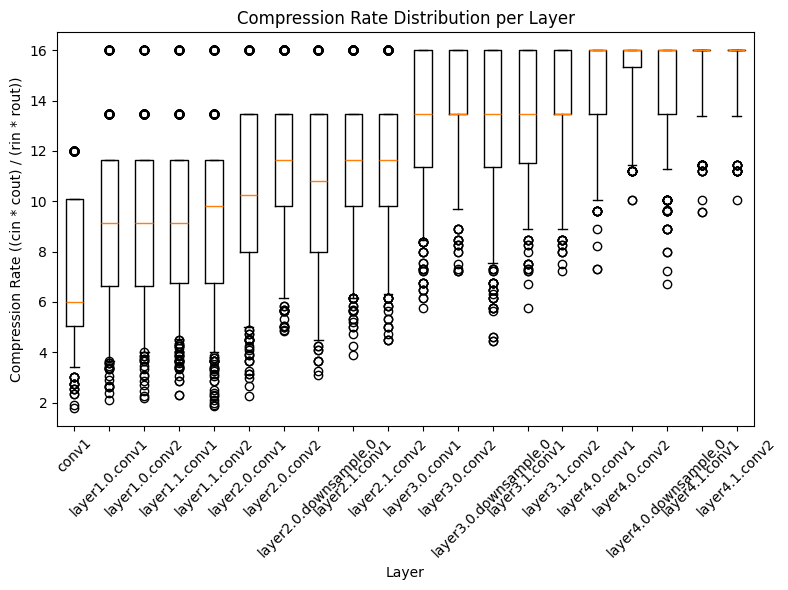

In [117]:
plot_avg_compression_boxplot(layer_dict, configs)

In [123]:
def duplicate_model(model):
    # Check if the model name is valid
    model_name = MODEL_NAME
    
    if model_name == 'vgg':
        model_cp = models.vgg16(weights=None)
        model_cp.classifier[6] = nn.Linear(4096, 10)
        
    elif model_name == 'alexnet':
        model_cp = models.alexnet(weights=None)
        model_cp.classifier[6] = nn.Linear(4096, 10)
        
    elif model_name == 'resnet':
        model_cp = models.resnet18(weights=None)
        model_cp.fc = nn.Linear(512, 10)

    model_cp.load_state_dict(model.state_dict())   
    return model_cp

In [124]:
def process_config(config, device_idx):
    try:        
        # Explicitly create a new scope to help with garbage collection
        with torch.enable_grad():

            config_str = ", ".join([f"{k}:{v}" for k, v in config.items()])
            logger.info(f"Compressing to:{config_str}")
            
            # Apply the configuration
            model.to('cpu')
            compressed_model = duplicate_model(model)
            compressed_model.to(device)

            for name, rank in config.items():
                layer = layer_info[name]['layer']
                compressed_model = replace_conv2d_with_tucker(compressed_model, name, layer, rank)

            # verify compressed model is still on gpu
            compressed_model.to(device)

            # Finetune for 3 epochs 
            if FINETUNE: 
                logger.info(f"finetuning:{config_str}")
                compressed_model = fine_tune(compressed_model, train_loader, device, epochs=3, lr=0.001)
                
            # Evaluate the model
            accuracy = calculate_accuracy(compressed_model, test_loader, device)
            params = count_parameters(compressed_model)
            flops = get_flops(compressed_model)
            inference_time = measure_inference_time(compressed_model, test_loader, device, num_runs=3)
            compression_rate = baseline_params / params if params > 0 else float('inf')
            
            result = {
                'config_str': config_str,
                'params': params,
                'flops': flops,
                'accuracy': accuracy,
                'inference_time': inference_time,
                'compression_rate': compression_rate,
                'accepted': True if accuracy >= acceptance_threshold else False
            }
            result_str = json.dumps(result, indent=4, default=str)
            logger.info(f"compressed_model:\n{result_str}")

            return result
    
    except Exception as e:
        logger.error(f"Error processing config: {config}. Error: {str(e)}")
        return None
    
    finally:
        # Explicit cleanup
        if 'compressed_model' in locals():
            del compressed_model
        
        # Clear CUDA cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

In [126]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import uuid


num_workers = 4
num_gpus = 1  # torch.cuda.device_count() if torch.cuda.is_available() else 0
results = []
tried_count = 0
accepted_models = []

sensitivities = precompute_sensitivities(layer_dict)
configs = generate_configs(layer_dict, sensitivities, num_cfg=500, alpha=1.0, beta=1.0)
acceptance_threshold = ACCU_RQT * baseline_accuracy

with ThreadPoolExecutor(max_workers=num_workers) as executor:
    # Submit tasks with device indices in round-robin
    if num_gpus > 0:
        futures = [executor.submit(process_config, config, 0) for config in configs] #- i % num_gpus) for i, config in enumerate(configs)]
        
        for future in as_completed(futures):
            try:
                result = future.result()
                if result is not None:
                    results.append(result)
                    
                    if result['accepted']:
                        accepted_models.append(result)
                    
                    tried_count += 1
                    if tried_count % 10 == 0:
                        logger.info(f"Evaluated {tried_count} configurations, found {len(accepted_models)} accepted models")
            
            except Exception as e:
                logger.error(f"Error in future processing: {str(e)}")
    else:
        logger.warning('NO GPU')

2025-03-29 18:12:28,680 - MainProcess - INFO - Compressing to:conv1:(2, 16), layer1.0.conv1:(25, 28), layer1.0.conv2:(25, 19), layer1.1.conv1:(16, 19), layer1.1.conv2:(19, 25), layer2.0.conv1:(19, 38), layer2.0.conv2:(38, 32), layer2.0.downsample.0:(16, 51), layer2.1.conv1:(32, 38), layer2.1.conv2:(38, 44), layer3.0.conv1:(38, 64), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(44, 76), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 153), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 153)
2025-03-29 18:12:28,682 - MainProcess - INFO - Compressing to:conv1:(2, 19), layer1.0.conv1:(25, 19), layer1.0.conv2:(16, 19), layer1.1.conv1:(35, 16), layer1.1.conv2:(28, 22), layer2.0.conv1:(19, 32), layer2.0.conv2:(32, 57), layer2.0.downsample.0:(22, 32), layer2.1.conv1:(32, 38), layer2.1.conv2:(32, 32), layer3.0.conv1:(38, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 64), laye

Epoch 1/3, Loss: 0.1327
Epoch 1/3, Loss: 0.1411
Epoch 1/3, Loss: 0.1324
Epoch 1/3, Loss: 0.1304
Epoch 2/3, Loss: 0.0497
Epoch 2/3, Loss: 0.0502
Epoch 2/3, Loss: 0.0498
Epoch 2/3, Loss: 0.0485
Epoch 3/3, Loss: 0.0374
Epoch 3/3, Loss: 0.0374
Epoch 3/3, Loss: 0.0361
Epoch 3/3, Loss: 0.0365


2025-03-29 18:28:02,279 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 19), layer1.0.conv1:(25, 19), layer1.0.conv2:(16, 19), layer1.1.conv1:(35, 16), layer1.1.conv2:(28, 22), layer2.0.conv1:(19, 32), layer2.0.conv2:(32, 57), layer2.0.downsample.0:(22, 32), layer2.1.conv1:(32, 38), layer2.1.conv2:(32, 32), layer3.0.conv1:(38, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(153, 128), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(153, 128), layer4.1.conv2:(128, 128)",
    "params": 1531508,
    "flops": 509313482,
    "accuracy": 0.9909,
    "inference_time": 0.19993132643891998,
    "compression_rate": 7.301066661094817,
    "accepted": true
}
2025-03-29 18:28:02,417 - MainProcess - INFO - Compressing to:conv1:(1, 16), layer1.0.conv1:(19, 28), layer1.0.conv2:(19, 22), layer1.1.conv1:(19, 16), layer1.1.conv2:(19, 16), layer2.0.conv1:(16, 32), layer2.0.con

Epoch 1/3, Loss: 0.1596
Epoch 1/3, Loss: 0.1350
Epoch 1/3, Loss: 0.1392
Epoch 1/3, Loss: 0.1420
Epoch 2/3, Loss: 0.0526
Epoch 2/3, Loss: 0.0498
Epoch 2/3, Loss: 0.0494
Epoch 2/3, Loss: 0.0530
Epoch 3/3, Loss: 0.0402
Epoch 3/3, Loss: 0.0378
Epoch 3/3, Loss: 0.0371
Epoch 3/3, Loss: 0.0398


2025-03-29 18:41:23,922 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 16), layer1.0.conv1:(19, 28), layer1.0.conv2:(19, 22), layer1.1.conv1:(19, 16), layer1.1.conv2:(19, 16), layer2.0.conv1:(16, 32), layer2.0.conv2:(44, 38), layer2.0.downsample.0:(16, 32), layer2.1.conv1:(38, 51), layer2.1.conv2:(32, 38), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 76), layer3.1.conv1:(89, 64), layer3.1.conv2:(76, 64), layer4.0.conv1:(89, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1511702,
    "flops": 500418218,
    "accuracy": 0.9901,
    "inference_time": 0.1823409079492978,
    "compression_rate": 7.396723692897145,
    "accepted": true
}
2025-03-29 18:41:24,050 - MainProcess - INFO - Compressing to:conv1:(2, 16), layer1.0.conv1:(16, 16), layer1.0.conv2:(16, 16), layer1.1.conv1:(22, 16), layer1.1.conv2:(22, 25), layer2.0.conv1:(16, 38), layer2.0.conv

Epoch 1/3, Loss: 0.1250
Epoch 1/3, Loss: 0.1345
Epoch 1/3, Loss: 0.1188
Epoch 1/3, Loss: 0.1582
Epoch 2/3, Loss: 0.0491
Epoch 2/3, Loss: 0.0508
Epoch 2/3, Loss: 0.0463
Epoch 2/3, Loss: 0.0539
Epoch 3/3, Loss: 0.0374
Epoch 3/3, Loss: 0.0372
Epoch 3/3, Loss: 0.0357
Epoch 3/3, Loss: 0.0403


2025-03-29 18:54:09,835 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(16, 16), layer1.0.conv2:(16, 16), layer1.1.conv1:(22, 16), layer1.1.conv2:(22, 25), layer2.0.conv1:(16, 38), layer2.0.conv2:(32, 38), layer2.0.downsample.0:(35, 51), layer2.1.conv1:(32, 38), layer2.1.conv2:(44, 32), layer3.0.conv1:(32, 64), layer3.0.conv2:(115, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(102, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(89, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1519880,
    "flops": 702977946,
    "accuracy": 0.9911,
    "inference_time": 0.1690485877342791,
    "compression_rate": 7.356924230860331,
    "accepted": true
}
2025-03-29 18:54:09,964 - MainProcess - INFO - Compressing to:conv1:(1, 19), layer1.0.conv1:(22, 25), layer1.0.conv2:(28, 19), layer1.1.conv1:(19, 16), layer1.1.conv2:(19, 32), layer2.0.conv1:(22, 44), layer2.0.co

Epoch 1/3, Loss: 0.1280
Epoch 1/3, Loss: 0.1360
Epoch 1/3, Loss: 0.1307
Epoch 1/3, Loss: 0.1171
Epoch 2/3, Loss: 0.0486
Epoch 2/3, Loss: 0.0507
Epoch 2/3, Loss: 0.0499
Epoch 2/3, Loss: 0.0454
Epoch 3/3, Loss: 0.0371
Epoch 3/3, Loss: 0.0385
Epoch 3/3, Loss: 0.0366


2025-03-29 19:06:52,794 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 19), layer1.0.conv1:(22, 25), layer1.0.conv2:(28, 19), layer1.1.conv1:(19, 16), layer1.1.conv2:(19, 32), layer2.0.conv1:(22, 44), layer2.0.conv2:(44, 51), layer2.0.downsample.0:(32, 64), layer2.1.conv1:(32, 44), layer2.1.conv2:(32, 38), layer3.0.conv1:(64, 76), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(44, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 76), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 153), layer4.1.conv2:(128, 128)",
    "params": 1544876,
    "flops": 524830410,
    "accuracy": 0.9908,
    "inference_time": 0.16312303411479714,
    "compression_rate": 7.237889642922798,
    "accepted": true
}
2025-03-29 19:06:52,873 - MainProcess - INFO - Compressing to:conv1:(2, 16), layer1.0.conv1:(19, 16), layer1.0.conv2:(19, 25), layer1.1.conv1:(35, 22), layer1.1.conv2:(19, 22), layer2.0.conv1:(22, 44), layer2.0.con

Epoch 3/3, Loss: 0.0350


2025-03-29 19:07:05,096 - MainProcess - INFO - finetuning:conv1:(2, 16), layer1.0.conv1:(19, 16), layer1.0.conv2:(19, 25), layer1.1.conv1:(35, 22), layer1.1.conv2:(19, 22), layer2.0.conv1:(22, 44), layer2.0.conv2:(32, 38), layer2.0.downsample.0:(19, 32), layer2.1.conv1:(44, 32), layer2.1.conv2:(70, 51), layer3.0.conv1:(38, 64), layer3.0.conv2:(76, 76), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 76), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 153), layer4.1.conv1:(128, 128), layer4.1.conv2:(153, 128)
2025-03-29 19:07:19,404 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(19, 22), layer1.0.conv2:(19, 16), layer1.1.conv1:(19, 19), layer1.1.conv2:(22, 16), layer2.0.conv1:(16, 32), layer2.0.conv2:(44, 38), layer2.0.downsample.0:(19, 38), layer2.1.conv1:(32, 32), layer2.1.conv2:(64, 38), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(102, 76), layer3.1

Epoch 1/3, Loss: 0.1237
Epoch 1/3, Loss: 0.1246
Epoch 1/3, Loss: 0.1413
Epoch 1/3, Loss: 0.1359
Epoch 2/3, Loss: 0.0499
Epoch 2/3, Loss: 0.0473
Epoch 2/3, Loss: 0.0504
Epoch 2/3, Loss: 0.0498
Epoch 3/3, Loss: 0.0371
Epoch 3/3, Loss: 0.0363
Epoch 3/3, Loss: 0.0382


2025-03-29 19:19:41,325 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(19, 16), layer1.0.conv2:(19, 25), layer1.1.conv1:(35, 22), layer1.1.conv2:(19, 22), layer2.0.conv1:(22, 44), layer2.0.conv2:(32, 38), layer2.0.downsample.0:(19, 32), layer2.1.conv1:(44, 32), layer2.1.conv2:(70, 51), layer3.0.conv1:(38, 64), layer3.0.conv2:(76, 76), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 76), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 153), layer4.1.conv1:(128, 128), layer4.1.conv2:(153, 128)",
    "params": 1550106,
    "flops": 337706858,
    "accuracy": 0.9908,
    "inference_time": 0.17300977777776697,
    "compression_rate": 7.21346927242395,
    "accepted": true
}
2025-03-29 19:19:41,444 - MainProcess - INFO - Compressing to:conv1:(1, 19), layer1.0.conv1:(19, 22), layer1.0.conv2:(16, 19), layer1.1.conv1:(38, 19), layer1.1.conv2:(16, 16), layer2.0.conv1:(32, 32), layer2.0.conv

Epoch 3/3, Loss: 0.0366


2025-03-29 19:20:05,013 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 32), layer1.0.conv1:(28, 32), layer1.0.conv2:(25, 25), layer1.1.conv1:(22, 32), layer1.1.conv2:(16, 32), layer2.0.conv1:(22, 32), layer2.0.conv2:(32, 44), layer2.0.downsample.0:(28, 38), layer2.1.conv1:(32, 44), layer2.1.conv2:(51, 38), layer3.0.conv1:(70, 64), layer3.0.conv2:(76, 64), layer3.0.downsample.0:(32, 89), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 153), layer4.0.conv2:(128, 153), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 153)",
    "params": 1605596,
    "flops": 558973610,
    "accuracy": 0.9915,
    "inference_time": 0.16030673869349646,
    "compression_rate": 6.964169068682284,
    "accepted": true
}
2025-03-29 19:20:05,057 - MainProcess - INFO - Compressing to:conv1:(2, 16), layer1.0.conv1:(19, 16), layer1.0.conv2:(25, 16), layer1.1.conv1:(16, 25), layer1.1.conv2:(38, 19), layer2.0.conv1:(19, 38), layer2.0.con

Epoch 1/3, Loss: 0.1481
Epoch 1/3, Loss: 0.1323
Epoch 1/3, Loss: 0.1312
Epoch 1/3, Loss: 0.1238
Epoch 2/3, Loss: 0.0526
Epoch 2/3, Loss: 0.0487
Epoch 2/3, Loss: 0.0492
Epoch 2/3, Loss: 0.0467
Epoch 3/3, Loss: 0.0391
Epoch 3/3, Loss: 0.0371


2025-03-29 19:32:25,234 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 19), layer1.0.conv1:(19, 22), layer1.0.conv2:(16, 19), layer1.1.conv1:(38, 19), layer1.1.conv2:(16, 16), layer2.0.conv1:(32, 32), layer2.0.conv2:(44, 44), layer2.0.downsample.0:(22, 38), layer2.1.conv1:(32, 32), layer2.1.conv2:(44, 32), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(38, 64), layer3.1.conv1:(64, 76), layer3.1.conv2:(64, 76), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(153, 128), layer4.1.conv2:(128, 153)",
    "params": 1546558,
    "flops": 306884682,
    "accuracy": 0.9911,
    "inference_time": 0.16987207993833375,
    "compression_rate": 7.230017884877256,
    "accepted": true
}
2025-03-29 19:32:25,348 - MainProcess - INFO - Compressing to:conv1:(2, 25), layer1.0.conv1:(22, 16), layer1.0.conv2:(16, 32), layer1.1.conv1:(16, 16), layer1.1.conv2:(16, 38), layer2.0.conv1:(16, 38), layer2.0.con

Epoch 3/3, Loss: 0.0366


2025-03-29 19:32:36,887 - MainProcess - INFO - finetuning:conv1:(2, 25), layer1.0.conv1:(22, 16), layer1.0.conv2:(16, 32), layer1.1.conv1:(16, 16), layer1.1.conv2:(16, 38), layer2.0.conv1:(16, 38), layer2.0.conv2:(32, 44), layer2.0.downsample.0:(25, 32), layer2.1.conv1:(32, 32), layer2.1.conv2:(32, 32), layer3.0.conv1:(32, 64), layer3.0.conv2:(115, 64), layer3.0.downsample.0:(76, 64), layer3.1.conv1:(89, 64), layer3.1.conv2:(64, 76), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 153), layer4.1.conv1:(128, 153), layer4.1.conv2:(128, 128)
2025-03-29 19:32:51,707 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(19, 16), layer1.0.conv2:(25, 16), layer1.1.conv1:(16, 25), layer1.1.conv2:(38, 19), layer2.0.conv1:(19, 38), layer2.0.conv2:(38, 38), layer2.0.downsample.0:(16, 38), layer2.1.conv1:(57, 57), layer2.1.conv2:(32, 32), layer3.0.conv1:(32, 64), layer3.0.conv2:(76, 64), layer3.0.downsample.0:(44, 76), layer3.1

Epoch 3/3, Loss: 0.0350


2025-03-29 19:33:03,944 - MainProcess - INFO - finetuning:conv1:(2, 28), layer1.0.conv1:(19, 19), layer1.0.conv2:(16, 19), layer1.1.conv1:(16, 35), layer1.1.conv2:(25, 25), layer2.0.conv1:(25, 51), layer2.0.conv2:(38, 38), layer2.0.downsample.0:(16, 32), layer2.1.conv1:(32, 32), layer2.1.conv2:(32, 32), layer3.0.conv1:(38, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(44, 64), layer3.1.conv1:(76, 89), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(153, 128), layer4.0.downsample.0:(76, 153), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 153)
2025-03-29 19:34:13,018 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 19), layer1.0.conv1:(28, 25), layer1.0.conv2:(28, 16), layer1.1.conv1:(48, 19), layer1.1.conv2:(22, 16), layer2.0.conv1:(38, 44), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(19, 44), layer2.1.conv1:(32, 38), layer2.1.conv2:(32, 70), layer3.0.conv1:(44, 64), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(32, 64), layer3.1.

Epoch 1/3, Loss: 0.1363
Epoch 1/3, Loss: 0.1339
Epoch 1/3, Loss: 0.1286
Epoch 1/3, Loss: 0.1512
Epoch 2/3, Loss: 0.0501
Epoch 2/3, Loss: 0.0491
Epoch 2/3, Loss: 0.0481
Epoch 2/3, Loss: 0.0526
Epoch 3/3, Loss: 0.0372
Epoch 3/3, Loss: 0.0377


2025-03-29 19:44:52,871 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 25), layer1.0.conv1:(22, 16), layer1.0.conv2:(16, 32), layer1.1.conv1:(16, 16), layer1.1.conv2:(16, 38), layer2.0.conv1:(16, 38), layer2.0.conv2:(32, 44), layer2.0.downsample.0:(25, 32), layer2.1.conv1:(32, 32), layer2.1.conv2:(32, 32), layer3.0.conv1:(32, 64), layer3.0.conv2:(115, 64), layer3.0.downsample.0:(76, 64), layer3.1.conv1:(89, 64), layer3.1.conv2:(64, 76), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 153), layer4.1.conv1:(128, 153), layer4.1.conv2:(128, 128)",
    "params": 1562553,
    "flops": 511433418,
    "accuracy": 0.9902,
    "inference_time": 0.17010818570535904,
    "compression_rate": 7.156008148203613,
    "accepted": true
}
2025-03-29 19:44:52,990 - MainProcess - INFO - Compressing to:conv1:(2, 16), layer1.0.conv1:(16, 16), layer1.0.conv2:(16, 16), layer1.1.conv1:(19, 16), layer1.1.conv2:(16, 22), layer2.0.conv1:(16, 44), layer2.0.co

Epoch 3/3, Loss: 0.0368


2025-03-29 19:45:18,596 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 28), layer1.0.conv1:(19, 19), layer1.0.conv2:(16, 19), layer1.1.conv1:(16, 35), layer1.1.conv2:(25, 25), layer2.0.conv1:(25, 51), layer2.0.conv2:(38, 38), layer2.0.downsample.0:(16, 32), layer2.1.conv1:(32, 32), layer2.1.conv2:(32, 32), layer3.0.conv1:(38, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(44, 64), layer3.1.conv1:(76, 89), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(153, 128), layer4.0.downsample.0:(76, 153), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 153)",
    "params": 1575250,
    "flops": 498573270,
    "accuracy": 0.9911,
    "inference_time": 0.15873855542225443,
    "compression_rate": 7.098328519282654,
    "accepted": true
}
2025-03-29 19:45:18,676 - MainProcess - INFO - Compressing to:conv1:(1, 22), layer1.0.conv1:(32, 54), layer1.0.conv2:(19, 22), layer1.1.conv1:(16, 19), layer1.1.conv2:(22, 16), layer2.0.conv1:(22, 32), layer2.0.con

Epoch 3/3, Loss: 0.0394


2025-03-29 19:47:01,009 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 16), layer1.0.conv1:(16, 22), layer1.0.conv2:(19, 19), layer1.1.conv1:(22, 16), layer1.1.conv2:(25, 19), layer2.0.conv1:(22, 38), layer2.0.conv2:(57, 32), layer2.0.downsample.0:(41, 64), layer2.1.conv1:(32, 32), layer2.1.conv2:(32, 38), layer3.0.conv1:(70, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(96, 64), layer3.1.conv1:(76, 64), layer3.1.conv2:(64, 76), layer4.0.conv1:(64, 179), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1553998,
    "flops": 516178186,
    "accuracy": 0.992,
    "inference_time": 0.17006833487508655,
    "compression_rate": 7.195403082886851,
    "accepted": true
}
2025-03-29 19:47:01,049 - MainProcess - INFO - Compressing to:conv1:(2, 22), layer1.0.conv1:(19, 25), layer1.0.conv2:(19, 32), layer1.1.conv1:(28, 28), layer1.1.conv2:(16, 16), layer2.0.conv1:(25, 32), layer2.0.conv

Epoch 1/3, Loss: 0.1283
Epoch 1/3, Loss: 0.1428


2025-03-29 19:50:03,176 - MainProcess - ERROR - Error processing config: {'conv1': (2, 16), 'layer1.0.conv1': (16, 16), 'layer1.0.conv2': (16, 16), 'layer1.1.conv1': (19, 16), 'layer1.1.conv2': (16, 22), 'layer2.0.conv1': (16, 44), 'layer2.0.conv2': (32, 32), 'layer2.0.downsample.0': (16, 32), 'layer2.1.conv1': (44, 44), 'layer2.1.conv2': (32, 38), 'layer3.0.conv1': (32, 76), 'layer3.0.conv2': (76, 64), 'layer3.0.downsample.0': (32, 64), 'layer3.1.conv1': (64, 76), 'layer3.1.conv2': (64, 64), 'layer4.0.conv1': (76, 128), 'layer4.0.conv2': (128, 128), 'layer4.0.downsample.0': (64, 128), 'layer4.1.conv1': (128, 128), 'layer4.1.conv2': (128, 128)}. Error: CUDA out of memory. Tried to allocate 196.00 MiB. GPU 0 has a total capacity of 47.54 GiB of which 145.12 MiB is free. Process 3928929 has 37.66 GiB memory in use. Including non-PyTorch memory, this process has 6.09 GiB memory in use. Process 3530538 has 3.62 GiB memory in use. Of the allocated memory 4.48 GiB is allocated by PyTorch, an

Epoch 1/3, Loss: 0.1465


2025-03-29 19:55:39,067 - MainProcess - ERROR - Error processing config: {'conv1': (1, 22), 'layer1.0.conv1': (16, 22), 'layer1.0.conv2': (19, 19), 'layer1.1.conv1': (22, 22), 'layer1.1.conv2': (16, 16), 'layer2.0.conv1': (22, 32), 'layer2.0.conv2': (32, 44), 'layer2.0.downsample.0': (19, 32), 'layer2.1.conv1': (38, 38), 'layer2.1.conv2': (32, 32), 'layer3.0.conv1': (44, 64), 'layer3.0.conv2': (64, 64), 'layer3.0.downsample.0': (51, 76), 'layer3.1.conv1': (64, 76), 'layer3.1.conv2': (64, 64), 'layer4.0.conv1': (76, 128), 'layer4.0.conv2': (128, 128), 'layer4.0.downsample.0': (64, 128), 'layer4.1.conv1': (153, 128), 'layer4.1.conv2': (128, 128)}. Error: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 47.54 GiB of which 1.12 MiB is free. Process 3928929 has 38.44 GiB memory in use. Including non-PyTorch memory, this process has 5.41 GiB memory in use. Process 3530538 has 3.66 GiB memory in use. Of the allocated memory 4.91 GiB is allocated by PyTorch, and 1

Epoch 1/3, Loss: 0.1257
Epoch 1/3, Loss: 0.1617
Epoch 1/3, Loss: 0.1317
Epoch 1/3, Loss: 0.1262


2025-03-29 20:02:50,544 - MainProcess - ERROR - Error processing config: {'conv1': (1, 19), 'layer1.0.conv1': (22, 25), 'layer1.0.conv2': (16, 32), 'layer1.1.conv1': (16, 19), 'layer1.1.conv2': (22, 16), 'layer2.0.conv1': (19, 38), 'layer2.0.conv2': (51, 38), 'layer2.0.downsample.0': (22, 32), 'layer2.1.conv1': (32, 32), 'layer2.1.conv2': (44, 44), 'layer3.0.conv1': (32, 64), 'layer3.0.conv2': (76, 64), 'layer3.0.downsample.0': (32, 64), 'layer3.1.conv1': (64, 64), 'layer3.1.conv2': (64, 89), 'layer4.0.conv1': (64, 128), 'layer4.0.conv2': (128, 179), 'layer4.0.downsample.0': (76, 128), 'layer4.1.conv1': (128, 153), 'layer4.1.conv2': (128, 128)}. Error: CUDA out of memory. Tried to allocate 30.00 MiB. GPU 0 has a total capacity of 47.54 GiB of which 27.12 MiB is free. Process 3928929 has 38.88 GiB memory in use. Including non-PyTorch memory, this process has 4.95 GiB memory in use. Process 3530538 has 3.66 GiB memory in use. Of the allocated memory 4.41 GiB is allocated by PyTorch, and 

Epoch 2/3, Loss: 0.0552


2025-03-29 20:05:47,855 - MainProcess - ERROR - Error processing config: {'conv1': (1, 16), 'layer1.0.conv1': (16, 16), 'layer1.0.conv2': (25, 16), 'layer1.1.conv1': (16, 22), 'layer1.1.conv2': (22, 16), 'layer2.0.conv1': (16, 32), 'layer2.0.conv2': (32, 32), 'layer2.0.downsample.0': (19, 32), 'layer2.1.conv1': (32, 44), 'layer2.1.conv2': (51, 32), 'layer3.0.conv1': (32, 89), 'layer3.0.conv2': (64, 64), 'layer3.0.downsample.0': (32, 89), 'layer3.1.conv1': (64, 64), 'layer3.1.conv2': (76, 76), 'layer4.0.conv1': (64, 128), 'layer4.0.conv2': (128, 128), 'layer4.0.downsample.0': (64, 128), 'layer4.1.conv1': (128, 128), 'layer4.1.conv2': (128, 128)}. Error: CUDA out of memory. Tried to allocate 50.00 MiB. GPU 0 has a total capacity of 47.54 GiB of which 7.12 MiB is free. Process 3928929 has 38.88 GiB memory in use. Including non-PyTorch memory, this process has 4.97 GiB memory in use. Process 3530538 has 3.66 GiB memory in use. Of the allocated memory 4.44 GiB is allocated by PyTorch, and 1

Epoch 2/3, Loss: 0.0472


2025-03-29 20:06:00,828 - MainProcess - INFO - finetuning:conv1:(2, 19), layer1.0.conv1:(16, 19), layer1.0.conv2:(16, 19), layer1.1.conv1:(16, 19), layer1.1.conv2:(16, 19), layer2.0.conv1:(19, 44), layer2.0.conv2:(38, 32), layer2.0.downsample.0:(25, 32), layer2.1.conv1:(38, 44), layer2.1.conv2:(32, 32), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(51, 64), layer3.1.conv1:(64, 76), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)


Epoch 1/3, Loss: 0.1350
Epoch 3/3, Loss: 0.0407
Epoch 3/3, Loss: 0.0366
Epoch 1/3, Loss: 0.1441


2025-03-29 20:11:30,249 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 16), layer1.0.conv1:(22, 28), layer1.0.conv2:(22, 16), layer1.1.conv1:(16, 16), layer1.1.conv2:(16, 28), layer2.0.conv1:(16, 51), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(16, 38), layer2.1.conv1:(32, 38), layer2.1.conv2:(44, 32), layer3.0.conv1:(32, 76), layer3.0.conv2:(64, 89), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 89), layer3.1.conv2:(64, 89), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 153), layer4.0.downsample.0:(76, 179), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1562274,
    "flops": 626184558,
    "accuracy": 0.9903,
    "inference_time": 0.17086516924977554,
    "compression_rate": 7.15728610986293,
    "accepted": true
}
2025-03-29 20:11:30,297 - MainProcess - INFO - Compressing to:conv1:(1, 19), layer1.0.conv1:(28, 16), layer1.0.conv2:(16, 22), layer1.1.conv1:(35, 16), layer1.1.conv2:(22, 16), layer2.0.conv1:(22, 38), layer2.0.conv

Epoch 2/3, Loss: 0.0497


2025-03-29 20:11:40,922 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(32, 25), layer1.0.conv2:(19, 16), layer1.1.conv1:(19, 32), layer1.1.conv2:(16, 38), layer2.0.conv1:(22, 32), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(16, 32), layer2.1.conv1:(32, 44), layer2.1.conv2:(44, 44), layer3.0.conv1:(38, 76), layer3.0.conv2:(76, 89), layer3.0.downsample.0:(38, 64), layer3.1.conv1:(64, 76), layer3.1.conv2:(76, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(89, 153), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1554270,
    "flops": 738138043,
    "accuracy": 0.9904,
    "inference_time": 0.1670966209120052,
    "compression_rate": 7.19414387461638,
    "accepted": true
}
2025-03-29 20:11:41,004 - MainProcess - INFO - Compressing to:conv1:(2, 19), layer1.0.conv1:(22, 19), layer1.0.conv2:(16, 35), layer1.1.conv1:(32, 25), layer1.1.conv2:(16, 22), layer2.0.conv1:(22, 44), layer2.0.conv2

Epoch 2/3, Loss: 0.0529
Epoch 3/3, Loss: 0.0370
Epoch 1/3, Loss: 0.1303
Epoch 1/3, Loss: 0.1271
Epoch 3/3, Loss: 0.0393


2025-03-29 20:17:20,139 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 32), layer1.0.conv1:(38, 16), layer1.0.conv2:(16, 35), layer1.1.conv1:(19, 25), layer1.1.conv2:(22, 19), layer2.0.conv1:(22, 32), layer2.0.conv2:(32, 44), layer2.0.downsample.0:(16, 32), layer2.1.conv1:(32, 32), layer2.1.conv2:(38, 32), layer3.0.conv1:(32, 76), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(32, 76), layer3.1.conv1:(64, 64), layer3.1.conv2:(76, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(153, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1500590,
    "flops": 513979850,
    "accuracy": 0.9899,
    "inference_time": 0.16930242809773502,
    "compression_rate": 7.451497077816059,
    "accepted": true
}
2025-03-29 20:17:20,246 - MainProcess - INFO - Compressing to:conv1:(1, 25), layer1.0.conv1:(16, 25), layer1.0.conv2:(19, 16), layer1.1.conv1:(41, 16), layer1.1.conv2:(54, 28), layer2.0.conv1:(22, 57), layer2.0.con

Epoch 2/3, Loss: 0.0475


2025-03-29 20:19:08,459 - MainProcess - INFO - finetuning:conv1:(2, 16), layer1.0.conv1:(28, 16), layer1.0.conv2:(35, 25), layer1.1.conv1:(16, 22), layer1.1.conv2:(16, 28), layer2.0.conv1:(41, 32), layer2.0.conv2:(44, 32), layer2.0.downsample.0:(19, 38), layer2.1.conv1:(32, 32), layer2.1.conv2:(32, 32), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(32, 89), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(89, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 153)


Epoch 2/3, Loss: 0.0477
Epoch 1/3, Loss: 0.1346
Epoch 3/3, Loss: 0.0359
Epoch 1/3, Loss: 0.1347
Epoch 3/3, Loss: 0.0374


2025-03-29 20:24:17,904 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 19), layer1.0.conv1:(28, 16), layer1.0.conv2:(16, 22), layer1.1.conv1:(35, 16), layer1.1.conv2:(22, 16), layer2.0.conv1:(22, 38), layer2.0.conv2:(44, 51), layer2.0.downsample.0:(19, 44), layer2.1.conv1:(32, 38), layer2.1.conv2:(32, 38), layer3.0.conv1:(44, 64), layer3.0.conv2:(89, 76), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 76), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(153, 128), layer4.1.conv2:(128, 128)",
    "params": 1565742,
    "flops": 316583546,
    "accuracy": 0.9893,
    "inference_time": 0.17091495418751065,
    "compression_rate": 7.1414332629513675,
    "accepted": true
}
2025-03-29 20:24:18,025 - MainProcess - INFO - Compressing to:conv1:(2, 32), layer1.0.conv1:(35, 16), layer1.0.conv2:(28, 32), layer1.1.conv1:(32, 32), layer1.1.conv2:(28, 19), layer2.0.conv1:(54, 32), layer2.0.co

Epoch 2/3, Loss: 0.0494


2025-03-29 20:24:30,459 - MainProcess - INFO - finetuning:conv1:(2, 32), layer1.0.conv1:(35, 16), layer1.0.conv2:(28, 32), layer1.1.conv1:(32, 32), layer1.1.conv2:(28, 19), layer2.0.conv1:(54, 32), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(16, 32), layer2.1.conv1:(38, 51), layer2.1.conv2:(32, 32), layer3.0.conv1:(44, 64), layer3.0.conv2:(64, 89), layer3.0.downsample.0:(44, 76), layer3.1.conv1:(89, 64), layer3.1.conv2:(76, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 153)
2025-03-29 20:24:38,767 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 19), layer1.0.conv1:(22, 19), layer1.0.conv2:(16, 35), layer1.1.conv1:(32, 25), layer1.1.conv2:(16, 22), layer2.0.conv1:(22, 44), layer2.0.conv2:(32, 38), layer2.0.downsample.0:(16, 32), layer2.1.conv1:(38, 32), layer2.1.conv2:(32, 32), layer3.0.conv1:(44, 64), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(44, 64), layer3.1.

Epoch 2/3, Loss: 0.0489
Epoch 3/3, Loss: 0.0373
Epoch 1/3, Loss: 0.1208
Epoch 1/3, Loss: 0.1336
Epoch 3/3, Loss: 0.0364


2025-03-29 20:30:19,918 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 25), layer1.0.conv1:(16, 25), layer1.0.conv2:(19, 16), layer1.1.conv1:(41, 16), layer1.1.conv2:(54, 28), layer2.0.conv1:(22, 57), layer2.0.conv2:(44, 51), layer2.0.downsample.0:(28, 38), layer2.1.conv1:(32, 38), layer2.1.conv2:(32, 32), layer3.0.conv1:(32, 89), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(153, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1511776,
    "flops": 555630634,
    "accuracy": 0.9906,
    "inference_time": 0.17217799204929618,
    "compression_rate": 7.396361630294435,
    "accepted": true
}
2025-03-29 20:30:20,000 - MainProcess - INFO - Compressing to:conv1:(2, 25), layer1.0.conv1:(19, 16), layer1.0.conv2:(16, 19), layer1.1.conv1:(25, 19), layer1.1.conv2:(25, 22), layer2.0.conv1:(22, 32), layer2.0.con

Epoch 2/3, Loss: 0.0463


2025-03-29 20:31:56,355 - MainProcess - INFO - finetuning:conv1:(2, 38), layer1.0.conv1:(19, 16), layer1.0.conv2:(19, 19), layer1.1.conv1:(16, 32), layer1.1.conv2:(16, 16), layer2.0.conv1:(19, 44), layer2.0.conv2:(38, 32), layer2.0.downsample.0:(41, 38), layer2.1.conv1:(38, 38), layer2.1.conv2:(32, 64), layer3.0.conv1:(38, 64), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(76, 153), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)


Epoch 2/3, Loss: 0.0492
Epoch 1/3, Loss: 0.1265
Epoch 3/3, Loss: 0.0358
Epoch 1/3, Loss: 0.1297
Epoch 3/3, Loss: 0.0365


2025-03-29 20:37:29,518 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 32), layer1.0.conv1:(35, 16), layer1.0.conv2:(28, 32), layer1.1.conv1:(32, 32), layer1.1.conv2:(28, 19), layer2.0.conv1:(54, 32), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(16, 32), layer2.1.conv1:(38, 51), layer2.1.conv2:(32, 32), layer3.0.conv1:(44, 64), layer3.0.conv2:(64, 89), layer3.0.downsample.0:(44, 76), layer3.1.conv1:(89, 64), layer3.1.conv2:(76, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 153)",
    "params": 1589007,
    "flops": 368094698,
    "accuracy": 0.9913,
    "inference_time": 0.1825894615958957,
    "compression_rate": 7.03687397223549,
    "accepted": true
}
2025-03-29 20:37:29,619 - MainProcess - INFO - Compressing to:conv1:(2, 25), layer1.0.conv1:(16, 28), layer1.0.conv2:(19, 22), layer1.1.conv1:(25, 35), layer1.1.conv2:(19, 16), layer2.0.conv1:(16, 32), layer2.0.conv2

Epoch 2/3, Loss: 0.0487


2025-03-29 20:37:51,969 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 16), layer1.0.conv1:(25, 16), layer1.0.conv2:(22, 22), layer1.1.conv1:(16, 19), layer1.1.conv2:(19, 19), layer2.0.conv1:(16, 44), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(22, 38), layer2.1.conv1:(38, 38), layer2.1.conv2:(38, 38), layer3.0.conv1:(44, 64), layer3.0.conv2:(76, 76), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(179, 128), layer4.1.conv2:(128, 128)",
    "params": 1545975,
    "flops": 369510602,
    "accuracy": 0.9911,
    "inference_time": 0.17504429412242462,
    "compression_rate": 7.232744384611653,
    "accepted": true
}
2025-03-29 20:37:52,017 - MainProcess - INFO - Compressing to:conv1:(2, 19), layer1.0.conv1:(22, 35), layer1.0.conv2:(19, 16), layer1.1.conv1:(28, 22), layer1.1.conv2:(16, 16), layer2.0.conv1:(16, 32), layer2.0.con

Epoch 2/3, Loss: 0.0501
Epoch 1/3, Loss: 0.1326
Epoch 3/3, Loss: 0.0371
Epoch 1/3, Loss: 0.1249
Epoch 3/3, Loss: 0.0376


2025-03-29 20:43:17,215 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 25), layer1.0.conv1:(19, 16), layer1.0.conv2:(16, 19), layer1.1.conv1:(25, 19), layer1.1.conv2:(25, 22), layer2.0.conv1:(22, 32), layer2.0.conv2:(44, 38), layer2.0.downsample.0:(25, 32), layer2.1.conv1:(32, 32), layer2.1.conv2:(44, 44), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 76), layer3.1.conv1:(76, 76), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1462954,
    "flops": 502894090,
    "accuracy": 0.9905,
    "inference_time": 0.18100405549294374,
    "compression_rate": 7.643194522862647,
    "accepted": true
}
2025-03-29 20:43:17,284 - MainProcess - INFO - Compressing to:conv1:(2, 25), layer1.0.conv1:(19, 16), layer1.0.conv2:(19, 16), layer1.1.conv1:(16, 22), layer1.1.conv2:(19, 32), layer2.0.conv1:(19, 32), layer2.0.con

Epoch 2/3, Loss: 0.0494


2025-03-29 20:44:50,888 - MainProcess - INFO - finetuning:conv1:(2, 19), layer1.0.conv1:(22, 28), layer1.0.conv2:(19, 22), layer1.1.conv1:(28, 16), layer1.1.conv2:(16, 16), layer2.0.conv1:(32, 38), layer2.0.conv2:(64, 44), layer2.0.downsample.0:(22, 38), layer2.1.conv1:(38, 32), layer2.1.conv2:(38, 32), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(44, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(89, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(153, 153)


Epoch 2/3, Loss: 0.0479
Epoch 1/3, Loss: 0.1111
Epoch 3/3, Loss: 0.0374
Epoch 1/3, Loss: 0.1303
Epoch 3/3, Loss: 0.0356


2025-03-29 20:50:30,738 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 25), layer1.0.conv1:(16, 28), layer1.0.conv2:(19, 22), layer1.1.conv1:(25, 35), layer1.1.conv2:(19, 16), layer2.0.conv1:(16, 32), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(19, 57), layer2.1.conv1:(44, 32), layer2.1.conv2:(32, 32), layer3.0.conv1:(38, 64), layer3.0.conv2:(89, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1474649,
    "flops": 482998522,
    "accuracy": 0.9901,
    "inference_time": 0.17222954766259324,
    "compression_rate": 7.582578633966456,
    "accepted": true
}
2025-03-29 20:50:30,792 - MainProcess - INFO - Compressing to:conv1:(1, 28), layer1.0.conv1:(54, 16), layer1.0.conv2:(16, 16), layer1.1.conv1:(22, 16), layer1.1.conv2:(22, 32), layer2.0.conv1:(16, 32), layer2.0.con

Epoch 2/3, Loss: 0.0449


2025-03-29 20:51:00,106 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 19), layer1.0.conv1:(22, 35), layer1.0.conv2:(19, 16), layer1.1.conv1:(28, 22), layer1.1.conv2:(16, 16), layer2.0.conv1:(16, 32), layer2.0.conv2:(32, 44), layer2.0.downsample.0:(16, 38), layer2.1.conv1:(32, 51), layer2.1.conv2:(32, 51), layer3.0.conv1:(38, 64), layer3.0.conv2:(64, 89), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(102, 64), layer3.1.conv2:(64, 89), layer4.0.conv1:(64, 128), layer4.0.conv2:(153, 179), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1657494,
    "flops": 329552621,
    "accuracy": 0.9921,
    "inference_time": 0.167951159163392,
    "compression_rate": 6.746113108101749,
    "accepted": true
}
2025-03-29 20:51:00,185 - MainProcess - INFO - Compressing to:conv1:(2, 19), layer1.0.conv1:(16, 28), layer1.0.conv2:(35, 35), layer1.1.conv1:(16, 25), layer1.1.conv2:(19, 22), layer2.0.conv1:(22, 44), layer2.0.conv

Epoch 2/3, Loss: 0.0493
Epoch 1/3, Loss: 0.1254
Epoch 3/3, Loss: 0.0341
Epoch 1/3, Loss: 0.1299
Epoch 3/3, Loss: 0.0368


2025-03-29 20:56:31,987 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 25), layer1.0.conv1:(19, 16), layer1.0.conv2:(19, 16), layer1.1.conv1:(16, 22), layer1.1.conv2:(19, 32), layer2.0.conv1:(19, 32), layer2.0.conv2:(32, 38), layer2.0.downsample.0:(16, 76), layer2.1.conv1:(32, 38), layer2.1.conv2:(32, 44), layer3.0.conv1:(96, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(89, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(76, 153), layer4.0.conv2:(153, 153), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1635838,
    "flops": 316976575,
    "accuracy": 0.9915,
    "inference_time": 0.18017222825635515,
    "compression_rate": 6.835421355904436,
    "accepted": true
}
2025-03-29 20:56:32,080 - MainProcess - INFO - Compressing to:conv1:(1, 22), layer1.0.conv1:(35, 16), layer1.0.conv2:(22, 16), layer1.1.conv1:(16, 25), layer1.1.conv2:(19, 16), layer2.0.conv1:(22, 57), layer2.0.con

Epoch 2/3, Loss: 0.0494


2025-03-29 20:57:49,601 - MainProcess - INFO - finetuning:conv1:(2, 19), layer1.0.conv1:(25, 16), layer1.0.conv2:(22, 19), layer1.1.conv1:(16, 22), layer1.1.conv2:(28, 25), layer2.0.conv1:(35, 32), layer2.0.conv2:(64, 38), layer2.0.downsample.0:(28, 32), layer2.1.conv1:(38, 44), layer2.1.conv2:(57, 32), layer3.0.conv1:(51, 64), layer3.0.conv2:(89, 89), layer3.0.downsample.0:(32, 89), layer3.1.conv1:(76, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)


Epoch 2/3, Loss: 0.0485
Epoch 1/3, Loss: 0.1384
Epoch 3/3, Loss: 0.0376
Epoch 1/3, Loss: 0.1204
Epoch 3/3, Loss: 0.0375


2025-03-29 21:03:11,930 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 28), layer1.0.conv1:(54, 16), layer1.0.conv2:(16, 16), layer1.1.conv1:(22, 16), layer1.1.conv2:(22, 32), layer2.0.conv1:(16, 32), layer2.0.conv2:(38, 32), layer2.0.downsample.0:(22, 32), layer2.1.conv1:(32, 32), layer2.1.conv2:(38, 32), layer3.0.conv1:(44, 64), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(38, 76), layer3.1.conv1:(76, 76), layer3.1.conv2:(64, 89), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(153, 128), layer4.1.conv2:(153, 128)",
    "params": 1605950,
    "flops": 437268586,
    "accuracy": 0.9913,
    "inference_time": 0.1697429709626864,
    "compression_rate": 6.9626339549799185,
    "accepted": true
}
2025-03-29 21:03:12,022 - MainProcess - INFO - Compressing to:conv1:(2, 16), layer1.0.conv1:(25, 16), layer1.0.conv2:(22, 19), layer1.1.conv1:(22, 28), layer1.1.conv2:(25, 19), layer2.0.conv1:(16, 32), layer2.0.con

Epoch 2/3, Loss: 0.0508


2025-03-29 21:04:06,821 - MainProcess - INFO - finetuning:conv1:(2, 19), layer1.0.conv1:(22, 22), layer1.0.conv2:(19, 19), layer1.1.conv1:(22, 16), layer1.1.conv2:(22, 25), layer2.0.conv1:(16, 32), layer2.0.conv2:(32, 44), layer2.0.downsample.0:(51, 32), layer2.1.conv1:(44, 51), layer2.1.conv2:(38, 32), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 76), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 153), layer4.1.conv2:(128, 128)


Epoch 2/3, Loss: 0.0471
Epoch 1/3, Loss: 0.1370
Epoch 3/3, Loss: 0.0381
Epoch 1/3, Loss: 0.1345
Epoch 3/3, Loss: 0.0354


2025-03-29 21:09:51,883 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 22), layer1.0.conv1:(35, 16), layer1.0.conv2:(22, 16), layer1.1.conv1:(16, 25), layer1.1.conv2:(19, 16), layer2.0.conv1:(22, 57), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(22, 32), layer2.1.conv1:(32, 64), layer2.1.conv2:(32, 32), layer3.0.conv1:(32, 76), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(76, 102), layer3.1.conv2:(64, 76), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 153), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1538260,
    "flops": 515924170,
    "accuracy": 0.9913,
    "inference_time": 0.1796295880765166,
    "compression_rate": 7.269019541559945,
    "accepted": true
}
2025-03-29 21:09:52,014 - MainProcess - INFO - Compressing to:conv1:(2, 25), layer1.0.conv1:(19, 16), layer1.0.conv2:(22, 16), layer1.1.conv1:(28, 16), layer1.1.conv2:(25, 16), layer2.0.conv1:(22, 38), layer2.0.con

Epoch 2/3, Loss: 0.0502


2025-03-29 21:10:55,405 - MainProcess - INFO - finetuning:conv1:(2, 16), layer1.0.conv1:(28, 22), layer1.0.conv2:(32, 16), layer1.1.conv1:(16, 35), layer1.1.conv2:(16, 38), layer2.0.conv1:(16, 44), layer2.0.conv2:(44, 70), layer2.0.downsample.0:(16, 38), layer2.1.conv1:(64, 44), layer2.1.conv2:(38, 32), layer3.0.conv1:(32, 76), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(44, 89), layer3.1.conv1:(89, 76), layer3.1.conv2:(64, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(153, 128), layer4.1.conv2:(128, 128)


Epoch 2/3, Loss: 0.0512
Epoch 1/3, Loss: 0.1272
Epoch 3/3, Loss: 0.0375
Epoch 1/3, Loss: 0.1388
Epoch 3/3, Loss: 0.0389


2025-03-29 21:15:54,141 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(25, 16), layer1.0.conv2:(22, 19), layer1.1.conv1:(22, 28), layer1.1.conv2:(25, 19), layer2.0.conv1:(16, 32), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(16, 38), layer2.1.conv1:(32, 44), layer2.1.conv2:(32, 32), layer3.0.conv1:(38, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(44, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 76), layer4.0.conv1:(64, 128), layer4.0.conv2:(153, 128), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1493430,
    "flops": 461094346,
    "accuracy": 0.9901,
    "inference_time": 0.17051124572753906,
    "compression_rate": 7.48722203250236,
    "accepted": true
}
2025-03-29 21:15:54,226 - MainProcess - INFO - Compressing to:conv1:(2, 22), layer1.0.conv1:(22, 16), layer1.0.conv2:(25, 22), layer1.1.conv1:(44, 28), layer1.1.conv2:(22, 19), layer2.0.conv1:(16, 32), layer2.0.conv

Epoch 2/3, Loss: 0.0462


2025-03-29 21:17:04,989 - MainProcess - INFO - finetuning:conv1:(2, 16), layer1.0.conv1:(19, 19), layer1.0.conv2:(28, 16), layer1.1.conv1:(38, 19), layer1.1.conv2:(16, 16), layer2.0.conv1:(19, 38), layer2.0.conv2:(38, 32), layer2.0.downsample.0:(25, 32), layer2.1.conv1:(38, 32), layer2.1.conv2:(32, 44), layer3.0.conv1:(32, 64), layer3.0.conv2:(76, 64), layer3.0.downsample.0:(51, 64), layer3.1.conv1:(64, 76), layer3.1.conv2:(76, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(204, 153), layer4.1.conv2:(128, 128)


Epoch 2/3, Loss: 0.0507
Epoch 1/3, Loss: 0.1185
Epoch 3/3, Loss: 0.0361
Epoch 1/3, Loss: 0.1312
Epoch 3/3, Loss: 0.0380


2025-03-29 21:22:56,255 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 25), layer1.0.conv1:(19, 16), layer1.0.conv2:(22, 16), layer1.1.conv1:(28, 16), layer1.1.conv2:(25, 16), layer2.0.conv1:(22, 38), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(22, 38), layer2.1.conv1:(38, 44), layer2.1.conv2:(38, 32), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(153, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 179)",
    "params": 1577673,
    "flops": 485319946,
    "accuracy": 0.989,
    "inference_time": 0.18058643978872116,
    "compression_rate": 7.087426862220498,
    "accepted": true
}
2025-03-29 21:22:56,347 - MainProcess - INFO - Compressing to:conv1:(2, 16), layer1.0.conv1:(22, 25), layer1.0.conv2:(16, 19), layer1.1.conv1:(22, 32), layer1.1.conv2:(22, 22), layer2.0.conv1:(19, 32), layer2.0.conv

Epoch 2/3, Loss: 0.0481


2025-03-29 21:23:26,822 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(28, 22), layer1.0.conv2:(32, 16), layer1.1.conv1:(16, 35), layer1.1.conv2:(16, 38), layer2.0.conv1:(16, 44), layer2.0.conv2:(44, 70), layer2.0.downsample.0:(16, 38), layer2.1.conv1:(64, 44), layer2.1.conv2:(38, 32), layer3.0.conv1:(32, 76), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(44, 89), layer3.1.conv1:(89, 76), layer3.1.conv2:(64, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(153, 128), layer4.1.conv2:(128, 128)",
    "params": 1595377,
    "flops": 366056298,
    "accuracy": 0.9896,
    "inference_time": 0.16799905851894628,
    "compression_rate": 7.008777235725474,
    "accepted": true
}
2025-03-29 21:23:26,881 - MainProcess - INFO - Compressing to:conv1:(2, 22), layer1.0.conv1:(19, 16), layer1.0.conv2:(22, 41), layer1.1.conv1:(16, 19), layer1.1.conv2:(22, 19), layer2.0.conv1:(16, 32), layer2.0.con

Epoch 2/3, Loss: 0.0493
Epoch 1/3, Loss: 0.1330
Epoch 3/3, Loss: 0.0363
Epoch 1/3, Loss: 0.1297
Epoch 3/3, Loss: 0.0372


2025-03-29 21:29:03,022 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 22), layer1.0.conv1:(22, 16), layer1.0.conv2:(25, 22), layer1.1.conv1:(44, 28), layer1.1.conv2:(22, 19), layer2.0.conv1:(16, 32), layer2.0.conv2:(32, 38), layer2.0.downsample.0:(35, 38), layer2.1.conv1:(51, 32), layer2.1.conv2:(32, 57), layer3.0.conv1:(70, 89), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(38, 64), layer3.1.conv1:(64, 76), layer3.1.conv2:(64, 76), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 153), layer4.1.conv1:(128, 128), layer4.1.conv2:(153, 128)",
    "params": 1583529,
    "flops": 553972866,
    "accuracy": 0.9908,
    "inference_time": 0.16821342162518996,
    "compression_rate": 7.061217066438316,
    "accepted": true
}
2025-03-29 21:29:03,152 - MainProcess - INFO - Compressing to:conv1:(1, 19), layer1.0.conv1:(22, 19), layer1.0.conv2:(25, 16), layer1.1.conv1:(28, 16), layer1.1.conv2:(16, 28), layer2.0.conv1:(19, 32), layer2.0.con

Epoch 2/3, Loss: 0.0487
Epoch 2/3, Loss: 0.0491
Epoch 1/3, Loss: 0.1355
Epoch 1/3, Loss: 0.1264
Epoch 3/3, Loss: 0.0371
Epoch 3/3, Loss: 0.0372


2025-03-29 21:35:56,692 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(22, 25), layer1.0.conv2:(16, 19), layer1.1.conv1:(22, 32), layer1.1.conv2:(22, 22), layer2.0.conv1:(19, 32), layer2.0.conv2:(51, 38), layer2.0.downsample.0:(25, 44), layer2.1.conv1:(44, 32), layer2.1.conv2:(32, 38), layer3.0.conv1:(32, 89), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 76), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1494321,
    "flops": 495591914,
    "accuracy": 0.9907,
    "inference_time": 0.18005932162015556,
    "compression_rate": 7.482757720730686,
    "accepted": true
}
2025-03-29 21:35:56,808 - MainProcess - INFO - Compressing to:conv1:(1, 16), layer1.0.conv1:(22, 19), layer1.0.conv2:(19, 22), layer1.1.conv1:(35, 25), layer1.1.conv2:(22, 16), layer2.0.conv1:(16, 32), layer2.0.con

Epoch 2/3, Loss: 0.0506


2025-03-29 21:36:09,625 - MainProcess - INFO - finetuning:conv1:(1, 16), layer1.0.conv1:(22, 19), layer1.0.conv2:(19, 22), layer1.1.conv1:(35, 25), layer1.1.conv2:(22, 16), layer2.0.conv1:(16, 32), layer2.0.conv2:(44, 44), layer2.0.downsample.0:(38, 44), layer2.1.conv1:(44, 32), layer2.1.conv2:(38, 51), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(76, 64), layer3.1.conv2:(76, 64), layer4.0.conv1:(89, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)
2025-03-29 21:36:09,928 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 22), layer1.0.conv1:(19, 16), layer1.0.conv2:(22, 41), layer1.1.conv1:(16, 19), layer1.1.conv2:(22, 19), layer2.0.conv1:(16, 32), layer2.0.conv2:(44, 32), layer2.0.downsample.0:(19, 32), layer2.1.conv1:(38, 38), layer2.1.conv2:(44, 44), layer3.0.conv1:(38, 76), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(44, 64), layer3.1.

Epoch 2/3, Loss: 0.0495
Epoch 3/3, Loss: 0.0370
Epoch 1/3, Loss: 0.1387
Epoch 1/3, Loss: 0.1195
Epoch 3/3, Loss: 0.0367


2025-03-29 21:41:40,887 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 19), layer1.0.conv1:(22, 19), layer1.0.conv2:(25, 16), layer1.1.conv1:(28, 16), layer1.1.conv2:(16, 28), layer2.0.conv1:(19, 32), layer2.0.conv2:(57, 32), layer2.0.downsample.0:(16, 32), layer2.1.conv1:(57, 44), layer2.1.conv2:(32, 38), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(38, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(76, 64), layer4.0.conv1:(89, 128), layer4.0.conv2:(153, 128), layer4.0.downsample.0:(76, 153), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1560832,
    "flops": 313287414,
    "accuracy": 0.9916,
    "inference_time": 0.17076528198906316,
    "compression_rate": 7.163898484910612,
    "accepted": true
}
2025-03-29 21:41:40,968 - MainProcess - INFO - Compressing to:conv1:(2, 22), layer1.0.conv1:(16, 16), layer1.0.conv2:(19, 19), layer1.1.conv1:(16, 22), layer1.1.conv2:(19, 16), layer2.0.conv1:(32, 57), layer2.0.con

Epoch 2/3, Loss: 0.0490
Epoch 2/3, Loss: 0.0471
Epoch 1/3, Loss: 0.1269
Epoch 1/3, Loss: 0.1370
Epoch 3/3, Loss: 0.0370
Epoch 3/3, Loss: 0.0357
Epoch 2/3, Loss: 0.0478


2025-03-29 21:49:14,994 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 16), layer1.0.conv1:(22, 19), layer1.0.conv2:(19, 22), layer1.1.conv1:(35, 25), layer1.1.conv2:(22, 16), layer2.0.conv1:(16, 32), layer2.0.conv2:(44, 44), layer2.0.downsample.0:(38, 44), layer2.1.conv1:(44, 32), layer2.1.conv2:(38, 51), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(76, 64), layer3.1.conv2:(76, 64), layer4.0.conv1:(89, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1515303,
    "flops": 324930794,
    "accuracy": 0.99,
    "inference_time": 0.18114865762666024,
    "compression_rate": 7.379145952987621,
    "accepted": true
}
2025-03-29 21:49:15,063 - MainProcess - INFO - Compressing to:conv1:(2, 22), layer1.0.conv1:(25, 25), layer1.0.conv2:(22, 41), layer1.1.conv1:(32, 22), layer1.1.conv2:(19, 32), layer2.0.conv1:(19, 38), layer2.0.conv2

Epoch 2/3, Loss: 0.0510
Epoch 3/3, Loss: 0.0357
Epoch 1/3, Loss: 0.1456
Epoch 1/3, Loss: 0.1276
Epoch 3/3, Loss: 0.0383


2025-03-29 21:54:15,921 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 22), layer1.0.conv1:(16, 16), layer1.0.conv2:(19, 19), layer1.1.conv1:(16, 22), layer1.1.conv2:(19, 16), layer2.0.conv1:(32, 57), layer2.0.conv2:(44, 32), layer2.0.downsample.0:(16, 44), layer2.1.conv1:(51, 64), layer2.1.conv2:(44, 38), layer3.0.conv1:(32, 76), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(38, 64), layer3.1.conv1:(76, 115), layer3.1.conv2:(64, 64), layer4.0.conv1:(89, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1584678,
    "flops": 331923290,
    "accuracy": 0.9915,
    "inference_time": 0.16962507474700864,
    "compression_rate": 7.056097200819346,
    "accepted": true
}
2025-03-29 21:54:16,021 - MainProcess - INFO - Compressing to:conv1:(2, 28), layer1.0.conv1:(25, 16), layer1.0.conv2:(38, 16), layer1.1.conv1:(41, 16), layer1.1.conv2:(19, 35), layer2.0.conv1:(28, 51), layer2.0.co

Epoch 2/3, Loss: 0.0528
Epoch 2/3, Loss: 0.0478
Epoch 1/3, Loss: 0.1232
Epoch 1/3, Loss: 0.1436
Epoch 3/3, Loss: 0.0399
Epoch 3/3, Loss: 0.0372
Epoch 2/3, Loss: 0.0477


2025-03-29 22:02:10,921 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 16), layer1.0.conv1:(22, 16), layer1.0.conv2:(16, 16), layer1.1.conv1:(32, 38), layer1.1.conv2:(25, 16), layer2.0.conv1:(16, 38), layer2.0.conv2:(32, 64), layer2.0.downsample.0:(19, 32), layer2.1.conv1:(32, 38), layer2.1.conv2:(32, 32), layer3.0.conv1:(32, 76), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 76), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1447254,
    "flops": 314295050,
    "accuracy": 0.9902,
    "inference_time": 0.1746376932553172,
    "compression_rate": 7.726108893117587,
    "accepted": true
}
2025-03-29 22:02:11,019 - MainProcess - INFO - Compressing to:conv1:(2, 32), layer1.0.conv1:(41, 19), layer1.0.conv2:(22, 25), layer1.1.conv1:(16, 19), layer1.1.conv2:(19, 22), layer2.0.conv1:(16, 38), layer2.0.conv

Epoch 2/3, Loss: 0.0510
Epoch 3/3, Loss: 0.0366
Epoch 1/3, Loss: 0.1188
Epoch 1/3, Loss: 0.1239
Epoch 3/3, Loss: 0.0375


2025-03-29 22:07:11,766 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 28), layer1.0.conv1:(25, 16), layer1.0.conv2:(38, 16), layer1.1.conv1:(41, 16), layer1.1.conv2:(19, 35), layer2.0.conv1:(28, 51), layer2.0.conv2:(32, 38), layer2.0.downsample.0:(16, 57), layer2.1.conv1:(38, 32), layer2.1.conv2:(32, 57), layer3.0.conv1:(44, 64), layer3.0.conv2:(76, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 153), layer4.1.conv2:(128, 153)",
    "params": 1577086,
    "flops": 511944586,
    "accuracy": 0.9905,
    "inference_time": 0.16687110680177208,
    "compression_rate": 7.090064841105685,
    "accepted": true
}
2025-03-29 22:07:11,880 - MainProcess - INFO - Compressing to:conv1:(2, 22), layer1.0.conv1:(25, 19), layer1.0.conv2:(32, 19), layer1.1.conv1:(16, 22), layer1.1.conv2:(25, 22), layer2.0.conv1:(16, 38), layer2.0.con

Epoch 2/3, Loss: 0.0470
Epoch 2/3, Loss: 0.0482
Epoch 1/3, Loss: 0.1360
Epoch 1/3, Loss: 0.1314
Epoch 3/3, Loss: 0.0359
Epoch 3/3, Loss: 0.0363
Epoch 2/3, Loss: 0.0488


2025-03-29 22:14:51,283 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 32), layer1.0.conv1:(41, 19), layer1.0.conv2:(22, 25), layer1.1.conv1:(16, 19), layer1.1.conv2:(19, 22), layer2.0.conv1:(16, 38), layer2.0.conv2:(51, 44), layer2.0.downsample.0:(19, 32), layer2.1.conv1:(38, 51), layer2.1.conv2:(38, 32), layer3.0.conv1:(76, 64), layer3.0.conv2:(76, 64), layer3.0.downsample.0:(51, 64), layer3.1.conv1:(89, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 153), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1587226,
    "flops": 537661354,
    "accuracy": 0.9913,
    "inference_time": 0.17330743704631826,
    "compression_rate": 7.044769931944159,
    "accepted": true
}
2025-03-29 22:14:51,385 - MainProcess - INFO - Compressing to:conv1:(1, 16), layer1.0.conv1:(19, 32), layer1.0.conv2:(19, 16), layer1.1.conv1:(16, 19), layer1.1.conv2:(16, 25), layer2.0.conv1:(32, 44), layer2.0.con

Epoch 2/3, Loss: 0.0507
Epoch 3/3, Loss: 0.0372
Epoch 1/3, Loss: 0.1356
Epoch 1/3, Loss: 0.1358


2025-03-29 22:19:55,798 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 22), layer1.0.conv1:(25, 19), layer1.0.conv2:(32, 19), layer1.1.conv1:(16, 22), layer1.1.conv2:(25, 22), layer2.0.conv1:(16, 38), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(38, 32), layer2.1.conv1:(64, 32), layer2.1.conv2:(32, 51), layer3.0.conv1:(32, 76), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(89, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1490242,
    "flops": 508002634,
    "accuracy": 0.989,
    "inference_time": 0.1684075576231485,
    "compression_rate": 7.503239071238094,
    "accepted": true
}
2025-03-29 22:19:55,926 - MainProcess - INFO - Compressing to:conv1:(2, 16), layer1.0.conv1:(19, 19), layer1.0.conv2:(16, 22), layer1.1.conv1:(22, 28), layer1.1.conv2:(19, 19), layer2.0.conv1:(25, 32), layer2.0.conv2

Epoch 3/3, Loss: 0.0372


2025-03-29 22:20:08,149 - MainProcess - INFO - finetuning:conv1:(2, 16), layer1.0.conv1:(19, 19), layer1.0.conv2:(16, 22), layer1.1.conv1:(22, 28), layer1.1.conv2:(19, 19), layer2.0.conv1:(25, 32), layer2.0.conv2:(44, 32), layer2.0.downsample.0:(25, 32), layer2.1.conv1:(38, 38), layer2.1.conv2:(32, 32), layer3.0.conv1:(32, 76), layer3.0.conv2:(89, 76), layer3.0.downsample.0:(51, 76), layer3.1.conv1:(64, 76), layer3.1.conv2:(89, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)
2025-03-29 22:21:47,321 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 16), layer1.0.conv1:(16, 54), layer1.0.conv2:(19, 16), layer1.1.conv1:(28, 25), layer1.1.conv2:(16, 16), layer2.0.conv1:(16, 44), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(22, 32), layer2.1.conv1:(51, 44), layer2.1.conv2:(32, 32), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 64), layer3.1.

Epoch 2/3, Loss: 0.0496
Epoch 2/3, Loss: 0.0491
Epoch 1/3, Loss: 0.1391
Epoch 3/3, Loss: 0.0369
Epoch 1/3, Loss: 0.1222
Epoch 3/3, Loss: 0.0364
Epoch 2/3, Loss: 0.0496


2025-03-29 22:27:31,676 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 16), layer1.0.conv1:(19, 32), layer1.0.conv2:(19, 16), layer1.1.conv1:(16, 19), layer1.1.conv2:(16, 25), layer2.0.conv1:(32, 44), layer2.0.conv2:(38, 32), layer2.0.downsample.0:(25, 51), layer2.1.conv1:(44, 38), layer2.1.conv2:(32, 32), layer3.0.conv1:(38, 64), layer3.0.conv2:(89, 64), layer3.0.downsample.0:(32, 76), layer3.1.conv1:(64, 76), layer3.1.conv2:(76, 76), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 153), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1541321,
    "flops": 493823994,
    "accuracy": 0.9881,
    "inference_time": 0.17240405234561604,
    "compression_rate": 7.254583568250871,
    "accepted": true
}
2025-03-29 22:27:31,797 - MainProcess - INFO - Compressing to:conv1:(1, 16), layer1.0.conv1:(16, 19), layer1.0.conv2:(35, 16), layer1.1.conv1:(16, 16), layer1.1.conv2:(32, 32), layer2.0.conv1:(16, 38), layer2.0.con

Epoch 2/3, Loss: 0.0471
Epoch 3/3, Loss: 0.0370
Epoch 1/3, Loss: 0.1174
Epoch 1/3, Loss: 0.1164


2025-03-29 22:32:26,361 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(19, 19), layer1.0.conv2:(16, 22), layer1.1.conv1:(22, 28), layer1.1.conv2:(19, 19), layer2.0.conv1:(25, 32), layer2.0.conv2:(44, 32), layer2.0.downsample.0:(25, 32), layer2.1.conv1:(38, 38), layer2.1.conv2:(32, 32), layer3.0.conv1:(32, 76), layer3.0.conv2:(89, 76), layer3.0.downsample.0:(51, 76), layer3.1.conv1:(64, 76), layer3.1.conv2:(89, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1517783,
    "flops": 510865802,
    "accuracy": 0.991,
    "inference_time": 0.17201263332569425,
    "compression_rate": 7.367088707674285,
    "accepted": true
}
2025-03-29 22:32:26,429 - MainProcess - INFO - Compressing to:conv1:(2, 19), layer1.0.conv1:(16, 22), layer1.0.conv2:(41, 16), layer1.1.conv1:(41, 32), layer1.1.conv2:(16, 25), layer2.0.conv1:(19, 44), layer2.0.conv

Epoch 3/3, Loss: 0.0349


2025-03-29 22:34:32,514 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 32), layer1.0.conv1:(22, 32), layer1.0.conv2:(16, 19), layer1.1.conv1:(22, 16), layer1.1.conv2:(28, 19), layer2.0.conv1:(32, 44), layer2.0.conv2:(38, 32), layer2.0.downsample.0:(16, 32), layer2.1.conv1:(32, 38), layer2.1.conv2:(32, 51), layer3.0.conv1:(64, 76), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(115, 76), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(153, 128)",
    "params": 1577953,
    "flops": 530673562,
    "accuracy": 0.99,
    "inference_time": 0.1702799154188476,
    "compression_rate": 7.086169233177414,
    "accepted": true
}
2025-03-29 22:34:32,577 - MainProcess - INFO - Compressing to:conv1:(1, 19), layer1.0.conv1:(19, 16), layer1.0.conv2:(16, 22), layer1.1.conv1:(25, 19), layer1.1.conv2:(16, 16), layer2.0.conv1:(22, 38), layer2.0.conv2

Epoch 2/3, Loss: 0.0470


2025-03-29 22:34:44,820 - MainProcess - INFO - finetuning:conv1:(1, 19), layer1.0.conv1:(19, 16), layer1.0.conv2:(16, 22), layer1.1.conv1:(25, 19), layer1.1.conv2:(16, 16), layer2.0.conv1:(22, 38), layer2.0.conv2:(51, 70), layer2.0.downsample.0:(19, 44), layer2.1.conv1:(44, 32), layer2.1.conv2:(32, 38), layer3.0.conv1:(32, 76), layer3.0.conv2:(89, 115), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 153), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(153, 128)


Epoch 2/3, Loss: 0.0476
Epoch 1/3, Loss: 0.1244
Epoch 3/3, Loss: 0.0357
Epoch 1/3, Loss: 0.1422
Epoch 3/3, Loss: 0.0353
Epoch 2/3, Loss: 0.0500


2025-03-29 22:40:19,499 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 16), layer1.0.conv1:(16, 19), layer1.0.conv2:(35, 16), layer1.1.conv1:(16, 16), layer1.1.conv2:(32, 32), layer2.0.conv1:(16, 38), layer2.0.conv2:(44, 38), layer2.0.downsample.0:(22, 32), layer2.1.conv1:(32, 32), layer2.1.conv2:(32, 38), layer3.0.conv1:(44, 64), layer3.0.conv2:(89, 64), layer3.0.downsample.0:(44, 76), layer3.1.conv1:(64, 76), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(204, 128), layer4.0.downsample.0:(76, 153), layer4.1.conv1:(128, 204), layer4.1.conv2:(128, 128)",
    "params": 1750570,
    "flops": 730971254,
    "accuracy": 0.9911,
    "inference_time": 0.1755098238619017,
    "compression_rate": 6.387429237334126,
    "accepted": true
}
2025-03-29 22:40:19,578 - MainProcess - INFO - Compressing to:conv1:(2, 19), layer1.0.conv1:(25, 19), layer1.0.conv2:(16, 22), layer1.1.conv1:(16, 25), layer1.1.conv2:(16, 44), layer2.0.conv1:(22, 38), layer2.0.conv

Epoch 2/3, Loss: 0.0517
Epoch 3/3, Loss: 0.0386
Epoch 1/3, Loss: 0.1366


2025-03-29 22:45:13,767 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 19), layer1.0.conv1:(16, 22), layer1.0.conv2:(41, 16), layer1.1.conv1:(41, 32), layer1.1.conv2:(16, 25), layer2.0.conv1:(19, 44), layer2.0.conv2:(32, 38), layer2.0.downsample.0:(38, 51), layer2.1.conv1:(38, 32), layer2.1.conv2:(51, 44), layer3.0.conv1:(38, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(64, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(102, 76), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 153)",
    "params": 1568955,
    "flops": 561578058,
    "accuracy": 0.9897,
    "inference_time": 0.17086341578489658,
    "compression_rate": 7.126808608277484,
    "accepted": true
}
2025-03-29 22:45:13,834 - MainProcess - INFO - Compressing to:conv1:(1, 16), layer1.0.conv1:(25, 16), layer1.0.conv2:(41, 32), layer1.1.conv1:(22, 16), layer1.1.conv2:(35, 22), layer2.0.conv1:(41, 32), layer2.0.co

Epoch 1/3, Loss: 0.1270


2025-03-29 22:45:26,397 - MainProcess - INFO - finetuning:conv1:(1, 16), layer1.0.conv1:(25, 16), layer1.0.conv2:(41, 32), layer1.1.conv1:(22, 16), layer1.1.conv2:(35, 22), layer2.0.conv1:(41, 32), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(35, 32), layer2.1.conv1:(32, 44), layer2.1.conv2:(32, 38), layer3.0.conv1:(32, 102), layer3.0.conv2:(102, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 89), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 153), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)


Epoch 3/3, Loss: 0.0385


2025-03-29 22:47:30,361 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 19), layer1.0.conv1:(19, 16), layer1.0.conv2:(16, 22), layer1.1.conv1:(25, 19), layer1.1.conv2:(16, 16), layer2.0.conv1:(22, 38), layer2.0.conv2:(51, 70), layer2.0.downsample.0:(19, 44), layer2.1.conv1:(44, 32), layer2.1.conv2:(32, 38), layer3.0.conv1:(32, 76), layer3.0.conv2:(89, 115), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 153), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(153, 128)",
    "params": 1598566,
    "flops": 506612406,
    "accuracy": 0.9905,
    "inference_time": 0.17296829496978952,
    "compression_rate": 6.99479533531928,
    "accepted": true
}
2025-03-29 22:47:30,438 - MainProcess - INFO - Compressing to:conv1:(1, 22), layer1.0.conv1:(16, 35), layer1.0.conv2:(19, 16), layer1.1.conv1:(28, 19), layer1.1.conv2:(16, 16), layer2.0.conv1:(25, 38), layer2.0.con

Epoch 2/3, Loss: 0.0495


2025-03-29 22:47:44,559 - MainProcess - INFO - finetuning:conv1:(1, 22), layer1.0.conv1:(16, 35), layer1.0.conv2:(19, 16), layer1.1.conv1:(28, 19), layer1.1.conv2:(16, 16), layer2.0.conv1:(25, 38), layer2.0.conv2:(38, 38), layer2.0.downsample.0:(19, 32), layer2.1.conv1:(32, 32), layer2.1.conv2:(32, 38), layer3.0.conv1:(57, 89), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(32, 76), layer3.1.conv1:(64, 76), layer3.1.conv2:(76, 64), layer4.0.conv1:(89, 128), layer4.0.conv2:(153, 179), layer4.0.downsample.0:(102, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)


Epoch 2/3, Loss: 0.0499
Epoch 1/3, Loss: 0.1334
Epoch 3/3, Loss: 0.0374
Epoch 1/3, Loss: 0.1209
Epoch 3/3, Loss: 0.0383
Epoch 2/3, Loss: 0.0487


2025-03-29 22:53:07,206 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 19), layer1.0.conv1:(25, 19), layer1.0.conv2:(16, 22), layer1.1.conv1:(16, 25), layer1.1.conv2:(16, 44), layer2.0.conv1:(22, 38), layer2.0.conv2:(38, 44), layer2.0.downsample.0:(28, 32), layer2.1.conv1:(38, 44), layer2.1.conv2:(51, 38), layer3.0.conv1:(38, 76), layer3.0.conv2:(76, 76), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(153, 128), layer4.0.downsample.0:(76, 153), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1543670,
    "flops": 526983862,
    "accuracy": 0.991,
    "inference_time": 0.18385842347600656,
    "compression_rate": 7.2435442808372255,
    "accepted": true
}
2025-03-29 22:53:07,335 - MainProcess - INFO - Compressing to:conv1:(2, 16), layer1.0.conv1:(19, 22), layer1.0.conv2:(19, 32), layer1.1.conv1:(38, 16), layer1.1.conv2:(25, 19), layer2.0.conv1:(22, 32), layer2.0.con

Epoch 2/3, Loss: 0.0473
Epoch 3/3, Loss: 0.0367
Epoch 1/3, Loss: 0.1313


2025-03-29 22:58:13,164 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 16), layer1.0.conv1:(25, 16), layer1.0.conv2:(41, 32), layer1.1.conv1:(22, 16), layer1.1.conv2:(35, 22), layer2.0.conv1:(41, 32), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(35, 32), layer2.1.conv1:(32, 44), layer2.1.conv2:(32, 38), layer3.0.conv1:(32, 102), layer3.0.conv2:(102, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 89), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 153), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1580808,
    "flops": 354975242,
    "accuracy": 0.9914,
    "inference_time": 0.1932850486407108,
    "compression_rate": 7.07337133921387,
    "accepted": true
}
2025-03-29 22:58:13,302 - MainProcess - INFO - Compressing to:conv1:(2, 25), layer1.0.conv1:(25, 22), layer1.0.conv2:(16, 22), layer1.1.conv1:(16, 41), layer1.1.conv2:(16, 19), layer2.0.conv1:(19, 32), layer2.0.con

Epoch 1/3, Loss: 0.1326
Epoch 3/3, Loss: 0.0348
Epoch 2/3, Loss: 0.0491


2025-03-29 23:00:55,436 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 22), layer1.0.conv1:(16, 35), layer1.0.conv2:(19, 16), layer1.1.conv1:(28, 19), layer1.1.conv2:(16, 16), layer2.0.conv1:(25, 38), layer2.0.conv2:(38, 38), layer2.0.downsample.0:(19, 32), layer2.1.conv1:(32, 32), layer2.1.conv2:(32, 38), layer3.0.conv1:(57, 89), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(32, 76), layer3.1.conv1:(64, 76), layer3.1.conv2:(76, 64), layer4.0.conv1:(89, 128), layer4.0.conv2:(153, 179), layer4.0.downsample.0:(102, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1702960,
    "flops": 515768497,
    "accuracy": 0.9912,
    "inference_time": 0.1988555691550998,
    "compression_rate": 6.566003899093343,
    "accepted": true
}
2025-03-29 23:00:55,594 - MainProcess - INFO - Compressing to:conv1:(2, 16), layer1.0.conv1:(35, 16), layer1.0.conv2:(25, 22), layer1.1.conv1:(16, 19), layer1.1.conv2:(22, 35), layer2.0.conv1:(19, 38), layer2.0.con

Epoch 1/3, Loss: 0.1546
Epoch 2/3, Loss: 0.0485
Epoch 3/3, Loss: 0.0361
Epoch 1/3, Loss: 0.1220
Epoch 2/3, Loss: 0.0522
Epoch 3/3, Loss: 0.0369


2025-03-29 23:06:24,545 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(19, 22), layer1.0.conv2:(19, 32), layer1.1.conv1:(38, 16), layer1.1.conv2:(25, 19), layer2.0.conv1:(22, 32), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(28, 32), layer2.1.conv1:(38, 44), layer2.1.conv2:(38, 64), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(32, 89), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(153, 128)",
    "params": 1508230,
    "flops": 528643786,
    "accuracy": 0.991,
    "inference_time": 0.1776551952281069,
    "compression_rate": 7.413751218315509,
    "accepted": true
}
2025-03-29 23:06:24,650 - MainProcess - INFO - Compressing to:conv1:(2, 22), layer1.0.conv1:(28, 25), layer1.0.conv2:(22, 19), layer1.1.conv1:(22, 16), layer1.1.conv2:(19, 28), layer2.0.conv1:(22, 32), layer2.0.conv2

Epoch 2/3, Loss: 0.0470
Epoch 3/3, Loss: 0.0389
Epoch 1/3, Loss: 0.1228


2025-03-29 23:11:51,198 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 25), layer1.0.conv1:(25, 22), layer1.0.conv2:(16, 22), layer1.1.conv1:(16, 41), layer1.1.conv2:(16, 19), layer2.0.conv1:(19, 32), layer2.0.conv2:(38, 32), layer2.0.downsample.0:(16, 51), layer2.1.conv1:(32, 38), layer2.1.conv2:(32, 44), layer3.0.conv1:(32, 76), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(57, 76), layer3.1.conv1:(64, 76), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1467435,
    "flops": 678964026,
    "accuracy": 0.9915,
    "inference_time": 0.20585361964636797,
    "compression_rate": 7.619855053205082,
    "accepted": true
}
2025-03-29 23:11:51,348 - MainProcess - INFO - Compressing to:conv1:(2, 16), layer1.0.conv1:(16, 16), layer1.0.conv2:(16, 22), layer1.1.conv1:(19, 19), layer1.1.conv2:(22, 16), layer2.0.conv1:(19, 32), layer2.0.con

Epoch 1/3, Loss: 0.1280
Epoch 3/3, Loss: 0.0360
Epoch 2/3, Loss: 0.0478


2025-03-29 23:14:59,096 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(35, 16), layer1.0.conv2:(25, 22), layer1.1.conv1:(16, 19), layer1.1.conv2:(22, 35), layer2.0.conv1:(19, 38), layer2.0.conv2:(38, 51), layer2.0.downsample.0:(41, 32), layer2.1.conv1:(32, 32), layer2.1.conv2:(51, 32), layer3.0.conv1:(32, 64), layer3.0.conv2:(128, 76), layer3.0.downsample.0:(51, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(89, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(179, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(153, 128)",
    "params": 1692677,
    "flops": 347276362,
    "accuracy": 0.9912,
    "inference_time": 0.2081388956422259,
    "compression_rate": 6.605892323225282,
    "accepted": true
}
2025-03-29 23:14:59,192 - MainProcess - INFO - Compressing to:conv1:(2, 28), layer1.0.conv1:(16, 22), layer1.0.conv2:(25, 32), layer1.1.conv1:(16, 16), layer1.1.conv2:(28, 48), layer2.0.conv1:(16, 70), layer2.0.con

Epoch 1/3, Loss: 0.1305
Epoch 2/3, Loss: 0.0481
Epoch 3/3, Loss: 0.0359
Epoch 1/3, Loss: 0.1306
Epoch 2/3, Loss: 0.0502


2025-03-29 23:20:26,070 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 22), layer1.0.conv1:(28, 25), layer1.0.conv2:(22, 19), layer1.1.conv1:(22, 16), layer1.1.conv2:(19, 28), layer2.0.conv1:(22, 32), layer2.0.conv2:(32, 38), layer2.0.downsample.0:(22, 38), layer2.1.conv1:(32, 32), layer2.1.conv2:(38, 32), layer3.0.conv1:(38, 64), layer3.0.conv2:(76, 76), layer3.0.downsample.0:(44, 64), layer3.1.conv1:(76, 76), layer3.1.conv2:(115, 89), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(153, 128)",
    "params": 1597522,
    "flops": 481281366,
    "accuracy": 0.9921,
    "inference_time": 0.20494204367295446,
    "compression_rate": 6.9993665188961405,
    "accepted": true
}
2025-03-29 23:20:26,182 - MainProcess - INFO - Compressing to:conv1:(2, 22), layer1.0.conv1:(19, 16), layer1.0.conv2:(16, 16), layer1.1.conv1:(16, 22), layer1.1.conv2:(25, 22), layer2.0.conv1:(16, 38), layer2.0.c

Epoch 3/3, Loss: 0.0364


2025-03-29 23:23:00,383 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 19), layer1.0.conv1:(16, 25), layer1.0.conv2:(38, 22), layer1.1.conv1:(16, 28), layer1.1.conv2:(22, 22), layer2.0.conv1:(22, 32), layer2.0.conv2:(32, 57), layer2.0.downsample.0:(25, 51), layer2.1.conv1:(32, 32), layer2.1.conv2:(32, 38), layer3.0.conv1:(64, 76), layer3.0.conv2:(89, 64), layer3.0.downsample.0:(44, 76), layer3.1.conv1:(64, 76), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 153), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1533897,
    "flops": 529213754,
    "accuracy": 0.9913,
    "inference_time": 0.21558051352288313,
    "compression_rate": 7.289695461950835,
    "accepted": true
}
2025-03-29 23:23:00,474 - MainProcess - INFO - Compressing to:conv1:(2, 16), layer1.0.conv1:(16, 16), layer1.0.conv2:(19, 19), layer1.1.conv1:(28, 16), layer1.1.conv2:(16, 16), layer2.0.conv1:(16, 57), layer2.0.con

Epoch 2/3, Loss: 0.0485


2025-03-29 23:23:17,963 - MainProcess - INFO - finetuning:conv1:(2, 16), layer1.0.conv1:(16, 16), layer1.0.conv2:(19, 19), layer1.1.conv1:(28, 16), layer1.1.conv2:(16, 16), layer2.0.conv1:(16, 57), layer2.0.conv2:(38, 32), layer2.0.downsample.0:(16, 38), layer2.1.conv1:(32, 32), layer2.1.conv2:(51, 64), layer3.0.conv1:(44, 76), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(38, 76), layer3.1.conv1:(64, 64), layer3.1.conv2:(89, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 153), layer4.0.downsample.0:(102, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)


Epoch 3/3, Loss: 0.0373
Epoch 1/3, Loss: 0.1280


2025-03-29 23:26:01,222 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(16, 16), layer1.0.conv2:(16, 22), layer1.1.conv1:(19, 19), layer1.1.conv2:(22, 16), layer2.0.conv1:(19, 32), layer2.0.conv2:(32, 38), layer2.0.downsample.0:(32, 38), layer2.1.conv1:(32, 44), layer2.1.conv2:(51, 51), layer3.0.conv1:(32, 76), layer3.0.conv2:(76, 64), layer3.0.downsample.0:(38, 64), layer3.1.conv1:(64, 76), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 153), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(89, 128), layer4.1.conv1:(153, 128), layer4.1.conv2:(128, 128)",
    "params": 1548859,
    "flops": 302723994,
    "accuracy": 0.9889,
    "inference_time": 0.20704620000916174,
    "compression_rate": 7.219276899963134,
    "accepted": true
}
2025-03-29 23:26:01,347 - MainProcess - INFO - Compressing to:conv1:(1, 16), layer1.0.conv1:(22, 19), layer1.0.conv2:(19, 28), layer1.1.conv1:(16, 16), layer1.1.conv2:(19, 25), layer2.0.conv1:(19, 32), layer2.0.con

Epoch 3/3, Loss: 0.0367
Epoch 1/3, Loss: 0.1233
Epoch 2/3, Loss: 0.0489


2025-03-29 23:29:32,175 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 28), layer1.0.conv1:(16, 22), layer1.0.conv2:(25, 32), layer1.1.conv1:(16, 16), layer1.1.conv2:(28, 48), layer2.0.conv1:(16, 70), layer2.0.conv2:(70, 32), layer2.0.downsample.0:(19, 38), layer2.1.conv1:(32, 70), layer2.1.conv2:(32, 32), layer3.0.conv1:(38, 76), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(76, 64), layer3.1.conv2:(115, 76), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 179), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1631831,
    "flops": 375394522,
    "accuracy": 0.9905,
    "inference_time": 0.2089421885788061,
    "compression_rate": 6.8522058963213714,
    "accepted": true
}
2025-03-29 23:29:32,318 - MainProcess - INFO - Compressing to:conv1:(2, 19), layer1.0.conv1:(19, 25), layer1.0.conv2:(22, 16), layer1.1.conv1:(16, 41), layer1.1.conv2:(22, 16), layer2.0.conv1:(32, 44), layer2.0.co

Epoch 1/3, Loss: 0.1316
Epoch 2/3, Loss: 0.0475
Epoch 3/3, Loss: 0.0362
Epoch 1/3, Loss: 0.1304
Epoch 2/3, Loss: 0.0493


2025-03-29 23:34:42,019 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 22), layer1.0.conv1:(19, 16), layer1.0.conv2:(16, 16), layer1.1.conv1:(16, 22), layer1.1.conv2:(25, 22), layer2.0.conv1:(16, 38), layer2.0.conv2:(51, 57), layer2.0.downsample.0:(35, 38), layer2.1.conv1:(38, 38), layer2.1.conv2:(44, 57), layer3.0.conv1:(32, 64), layer3.0.conv2:(89, 64), layer3.0.downsample.0:(44, 89), layer3.1.conv1:(64, 76), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1504096,
    "flops": 382408970,
    "accuracy": 0.99,
    "inference_time": 0.20555918434369844,
    "compression_rate": 7.434127874816501,
    "accepted": true
}
2025-03-29 23:34:42,124 - MainProcess - INFO - Compressing to:conv1:(2, 22), layer1.0.conv1:(19, 19), layer1.0.conv2:(19, 16), layer1.1.conv1:(16, 16), layer1.1.conv2:(25, 16), layer2.0.conv1:(19, 38), layer2.0.conv2

Epoch 3/3, Loss: 0.0357


2025-03-29 23:37:49,355 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(16, 16), layer1.0.conv2:(19, 19), layer1.1.conv1:(28, 16), layer1.1.conv2:(16, 16), layer2.0.conv1:(16, 57), layer2.0.conv2:(38, 32), layer2.0.downsample.0:(16, 38), layer2.1.conv1:(32, 32), layer2.1.conv2:(51, 64), layer3.0.conv1:(44, 76), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(38, 76), layer3.1.conv1:(64, 64), layer3.1.conv2:(89, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 153), layer4.0.downsample.0:(102, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1554418,
    "flops": 311687466,
    "accuracy": 0.9917,
    "inference_time": 0.2329309720648828,
    "compression_rate": 7.193458902302984,
    "accepted": true
}
2025-03-29 23:37:49,477 - MainProcess - INFO - Compressing to:conv1:(2, 54), layer1.0.conv1:(19, 16), layer1.0.conv2:(16, 16), layer1.1.conv1:(16, 16), layer1.1.conv2:(25, 22), layer2.0.conv1:(44, 32), layer2.0.con

Epoch 2/3, Loss: 0.0486
Epoch 3/3, Loss: 0.0376


2025-03-29 23:38:09,076 - MainProcess - INFO - finetuning:conv1:(2, 54), layer1.0.conv1:(19, 16), layer1.0.conv2:(16, 16), layer1.1.conv1:(16, 16), layer1.1.conv2:(25, 22), layer2.0.conv1:(44, 32), layer2.0.conv2:(44, 32), layer2.0.downsample.0:(16, 57), layer2.1.conv1:(32, 32), layer2.1.conv2:(32, 38), layer3.0.conv1:(32, 64), layer3.0.conv2:(89, 64), layer3.0.downsample.0:(38, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(153, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(153, 128)


Epoch 1/3, Loss: 0.1288


2025-03-29 23:40:26,138 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 16), layer1.0.conv1:(22, 19), layer1.0.conv2:(19, 28), layer1.1.conv1:(16, 16), layer1.1.conv2:(19, 25), layer2.0.conv1:(19, 32), layer2.0.conv2:(38, 32), layer2.0.downsample.0:(16, 38), layer2.1.conv1:(64, 44), layer2.1.conv2:(44, 32), layer3.0.conv1:(44, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(44, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(76, 89), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1495115,
    "flops": 466346362,
    "accuracy": 0.9912,
    "inference_time": 0.2146313413186691,
    "compression_rate": 7.478783906254703,
    "accepted": true
}
2025-03-29 23:40:26,278 - MainProcess - INFO - Compressing to:conv1:(2, 48), layer1.0.conv1:(22, 22), layer1.0.conv2:(32, 57), layer1.1.conv1:(28, 16), layer1.1.conv2:(25, 16), layer2.0.conv1:(19, 38), layer2.0.conv

Epoch 3/3, Loss: 0.0373
Epoch 1/3, Loss: 0.1283
Epoch 2/3, Loss: 0.0489


2025-03-29 23:44:24,098 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 19), layer1.0.conv1:(19, 25), layer1.0.conv2:(22, 16), layer1.1.conv1:(16, 41), layer1.1.conv2:(22, 16), layer2.0.conv1:(32, 44), layer2.0.conv2:(32, 51), layer2.0.downsample.0:(19, 32), layer2.1.conv1:(44, 32), layer2.1.conv2:(32, 38), layer3.0.conv1:(51, 64), layer3.0.conv2:(76, 64), layer3.0.downsample.0:(32, 89), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 89), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1496604,
    "flops": 321924938,
    "accuracy": 0.9904,
    "inference_time": 0.2062189072813451,
    "compression_rate": 7.471343120825549,
    "accepted": true
}
2025-03-29 23:44:24,192 - MainProcess - INFO - Compressing to:conv1:(1, 19), layer1.0.conv1:(28, 16), layer1.0.conv2:(16, 16), layer1.1.conv1:(25, 16), layer1.1.conv2:(16, 16), layer2.0.conv1:(22, 32), layer2.0.conv

Epoch 1/3, Loss: 0.1224
Epoch 2/3, Loss: 0.0497
Epoch 3/3, Loss: 0.0367
Epoch 2/3, Loss: 0.0490
Epoch 1/3, Loss: 0.1492


2025-03-29 23:48:40,746 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 22), layer1.0.conv1:(19, 19), layer1.0.conv2:(19, 16), layer1.1.conv1:(16, 16), layer1.1.conv2:(25, 16), layer2.0.conv1:(19, 38), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(25, 32), layer2.1.conv1:(32, 44), layer2.1.conv2:(44, 70), layer3.0.conv1:(44, 76), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(32, 89), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1496868,
    "flops": 504570282,
    "accuracy": 0.9895,
    "inference_time": 0.18103911719757534,
    "compression_rate": 7.470025413062475,
    "accepted": true
}
2025-03-29 23:48:40,862 - MainProcess - INFO - Compressing to:conv1:(2, 25), layer1.0.conv1:(25, 16), layer1.0.conv2:(32, 22), layer1.1.conv1:(22, 16), layer1.1.conv2:(22, 19), layer2.0.conv1:(32, 32), layer2.0.con

Epoch 3/3, Loss: 0.0370
Epoch 3/3, Loss: 0.0368
Epoch 2/3, Loss: 0.0524


2025-03-29 23:52:11,315 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 54), layer1.0.conv1:(19, 16), layer1.0.conv2:(16, 16), layer1.1.conv1:(16, 16), layer1.1.conv2:(25, 22), layer2.0.conv1:(44, 32), layer2.0.conv2:(44, 32), layer2.0.downsample.0:(16, 57), layer2.1.conv1:(32, 32), layer2.1.conv2:(32, 38), layer3.0.conv1:(32, 64), layer3.0.conv2:(89, 64), layer3.0.downsample.0:(38, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(153, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(153, 128)",
    "params": 1560079,
    "flops": 318603914,
    "accuracy": 0.9901,
    "inference_time": 0.2065650176596996,
    "compression_rate": 7.167356268496659,
    "accepted": true
}
2025-03-29 23:52:11,413 - MainProcess - INFO - Compressing to:conv1:(1, 19), layer1.0.conv1:(19, 16), layer1.0.conv2:(16, 19), layer1.1.conv1:(19, 19), layer1.1.conv2:(25, 22), layer2.0.conv1:(19, 32), layer2.0.conv

Epoch 1/3, Loss: 0.1222


2025-03-29 23:54:07,721 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 48), layer1.0.conv1:(22, 22), layer1.0.conv2:(32, 57), layer1.1.conv1:(28, 16), layer1.1.conv2:(25, 16), layer2.0.conv1:(19, 38), layer2.0.conv2:(51, 38), layer2.0.downsample.0:(32, 38), layer2.1.conv1:(32, 32), layer2.1.conv2:(38, 44), layer3.0.conv1:(51, 64), layer3.0.conv2:(76, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 76), layer3.1.conv2:(64, 89), layer4.0.conv1:(64, 153), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(153, 153), layer4.1.conv2:(128, 128)",
    "params": 1625330,
    "flops": 371946931,
    "accuracy": 0.991,
    "inference_time": 0.19909078300378882,
    "compression_rate": 6.879613370823156,
    "accepted": true
}
2025-03-29 23:54:07,779 - MainProcess - INFO - Compressing to:conv1:(2, 16), layer1.0.conv1:(22, 22), layer1.0.conv2:(22, 32), layer1.1.conv1:(28, 22), layer1.1.conv2:(19, 16), layer2.0.conv1:(22, 32), layer2.0.conv

Epoch 3/3, Loss: 0.0400
Epoch 1/3, Loss: 0.1369
Epoch 2/3, Loss: 0.0467


2025-03-29 23:58:03,374 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 19), layer1.0.conv1:(28, 16), layer1.0.conv2:(16, 16), layer1.1.conv1:(25, 16), layer1.1.conv2:(16, 16), layer2.0.conv1:(22, 32), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(16, 44), layer2.1.conv1:(32, 38), layer2.1.conv2:(32, 32), layer3.0.conv1:(32, 76), layer3.0.conv2:(76, 76), layer3.0.downsample.0:(51, 64), layer3.1.conv1:(64, 89), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1472070,
    "flops": 480957770,
    "accuracy": 0.9895,
    "inference_time": 0.20241664574657528,
    "compression_rate": 7.595862968472967,
    "accepted": true
}
2025-03-29 23:58:03,441 - MainProcess - INFO - Compressing to:conv1:(2, 16), layer1.0.conv1:(22, 25), layer1.0.conv2:(22, 16), layer1.1.conv1:(16, 19), layer1.1.conv2:(16, 16), layer2.0.conv1:(16, 32), layer2.0.con

Epoch 1/3, Loss: 0.1271


2025-03-29 23:58:19,004 - MainProcess - INFO - finetuning:conv1:(2, 16), layer1.0.conv1:(22, 25), layer1.0.conv2:(22, 16), layer1.1.conv1:(16, 19), layer1.1.conv2:(16, 16), layer2.0.conv1:(16, 32), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(41, 51), layer2.1.conv1:(38, 57), layer2.1.conv2:(32, 38), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 76), layer3.1.conv2:(64, 76), layer4.0.conv1:(64, 128), layer4.0.conv2:(153, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)


Epoch 2/3, Loss: 0.0494
Epoch 3/3, Loss: 0.0353
Epoch 2/3, Loss: 0.0483
Epoch 1/3, Loss: 0.1424


2025-03-30 00:02:21,128 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 25), layer1.0.conv1:(25, 16), layer1.0.conv2:(32, 22), layer1.1.conv1:(22, 16), layer1.1.conv2:(22, 19), layer2.0.conv1:(32, 32), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(16, 44), layer2.1.conv1:(44, 32), layer2.1.conv2:(44, 38), layer3.0.conv1:(32, 76), layer3.0.conv2:(89, 64), layer3.0.downsample.0:(32, 76), layer3.1.conv1:(64, 64), layer3.1.conv2:(102, 76), layer4.0.conv1:(89, 128), layer4.0.conv2:(128, 153), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(153, 128), layer4.1.conv2:(153, 128)",
    "params": 1679979,
    "flops": 530969130,
    "accuracy": 0.9914,
    "inference_time": 0.1983708510226758,
    "compression_rate": 6.65582248349533,
    "accepted": true
}
2025-03-30 00:02:21,244 - MainProcess - INFO - Compressing to:conv1:(1, 19), layer1.0.conv1:(19, 19), layer1.0.conv2:(19, 28), layer1.1.conv1:(28, 25), layer1.1.conv2:(16, 16), layer2.0.conv1:(19, 32), layer2.0.conv

Epoch 3/3, Loss: 0.0377
Epoch 3/3, Loss: 0.0361
Epoch 2/3, Loss: 0.0503


2025-03-30 00:06:18,032 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 19), layer1.0.conv1:(19, 16), layer1.0.conv2:(16, 19), layer1.1.conv1:(19, 19), layer1.1.conv2:(25, 22), layer2.0.conv1:(19, 32), layer2.0.conv2:(32, 38), layer2.0.downsample.0:(44, 32), layer2.1.conv1:(32, 38), layer2.1.conv2:(57, 32), layer3.0.conv1:(38, 89), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(38, 76), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(153, 128)",
    "params": 1498171,
    "flops": 296795778,
    "accuracy": 0.9901,
    "inference_time": 0.20674082630505733,
    "compression_rate": 7.4635285291198405,
    "accepted": true
}
2025-03-30 00:06:18,128 - MainProcess - INFO - Compressing to:conv1:(1, 16), layer1.0.conv1:(25, 19), layer1.0.conv2:(28, 19), layer1.1.conv1:(19, 32), layer1.1.conv2:(16, 19), layer2.0.conv1:(32, 32), layer2.0.co

Epoch 1/3, Loss: 0.1321


2025-03-30 00:06:33,848 - MainProcess - INFO - finetuning:conv1:(1, 16), layer1.0.conv1:(25, 19), layer1.0.conv2:(28, 19), layer1.1.conv1:(19, 32), layer1.1.conv2:(16, 19), layer2.0.conv1:(32, 32), layer2.0.conv2:(32, 38), layer2.0.downsample.0:(16, 38), layer2.1.conv1:(38, 32), layer2.1.conv2:(38, 44), layer3.0.conv1:(38, 76), layer3.0.conv2:(76, 89), layer3.0.downsample.0:(38, 76), layer3.1.conv1:(89, 64), layer3.1.conv2:(64, 76), layer4.0.conv1:(102, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(153, 153)
2025-03-30 00:07:47,245 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(22, 22), layer1.0.conv2:(22, 32), layer1.1.conv1:(28, 22), layer1.1.conv2:(19, 16), layer2.0.conv1:(22, 32), layer2.0.conv2:(32, 38), layer2.0.downsample.0:(16, 32), layer2.1.conv1:(32, 38), layer2.1.conv2:(32, 32), layer3.0.conv1:(38, 76), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 76), layer3.1

Epoch 1/3, Loss: 0.1375


2025-03-30 00:11:00,800 - MainProcess - ERROR - Error processing config: {'conv1': (2, 28), 'layer1.0.conv1': (32, 28), 'layer1.0.conv2': (16, 28), 'layer1.1.conv1': (35, 35), 'layer1.1.conv2': (16, 28), 'layer2.0.conv1': (16, 32), 'layer2.0.conv2': (32, 38), 'layer2.0.downsample.0': (22, 32), 'layer2.1.conv1': (32, 38), 'layer2.1.conv2': (32, 32), 'layer3.0.conv1': (32, 64), 'layer3.0.conv2': (64, 89), 'layer3.0.downsample.0': (32, 64), 'layer3.1.conv1': (76, 64), 'layer3.1.conv2': (64, 64), 'layer4.0.conv1': (64, 128), 'layer4.0.conv2': (128, 128), 'layer4.0.downsample.0': (64, 128), 'layer4.1.conv1': (128, 128), 'layer4.1.conv2': (153, 128)}. Error: CUDA out of memory. Tried to allocate 26.00 MiB. GPU 0 has a total capacity of 47.54 GiB of which 7.12 MiB is free. Process 3928929 has 38.80 GiB memory in use. Including non-PyTorch memory, this process has 5.05 GiB memory in use. Process 3530538 has 3.66 GiB memory in use. Of the allocated memory 4.54 GiB is allocated by PyTorch, and 1

Epoch 1/3, Loss: 0.1392


2025-03-30 00:15:16,476 - MainProcess - INFO - finetuning:conv1:(2, 22), layer1.0.conv1:(19, 16), layer1.0.conv2:(25, 22), layer1.1.conv1:(16, 22), layer1.1.conv2:(16, 16), layer2.0.conv1:(25, 32), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(25, 57), layer2.1.conv1:(32, 32), layer2.1.conv2:(38, 32), layer3.0.conv1:(32, 64), layer3.0.conv2:(76, 64), layer3.0.downsample.0:(32, 76), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 89), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)
2025-03-30 00:15:17,833 - MainProcess - INFO - finetuning:conv1:(2, 25), layer1.0.conv1:(25, 28), layer1.0.conv2:(16, 16), layer1.1.conv1:(19, 19), layer1.1.conv2:(28, 16), layer2.0.conv1:(25, 44), layer2.0.conv2:(51, 44), layer2.0.downsample.0:(25, 32), layer2.1.conv1:(32, 32), layer2.1.conv2:(32, 44), layer3.0.conv1:(70, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(57, 64), layer3.1.conv1:(64, 64), layer3.1.con

Epoch 1/3, Loss: 0.1445
Epoch 1/3, Loss: 0.1407
Epoch 1/3, Loss: 0.1176
Epoch 1/3, Loss: 0.1195
Epoch 2/3, Loss: 0.0513
Epoch 2/3, Loss: 0.0515
Epoch 2/3, Loss: 0.0473
Epoch 2/3, Loss: 0.0481
Epoch 3/3, Loss: 0.0385
Epoch 3/3, Loss: 0.0398
Epoch 3/3, Loss: 0.0351
Epoch 3/3, Loss: 0.0363


2025-03-30 00:37:13,040 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 16), layer1.0.conv1:(25, 19), layer1.0.conv2:(19, 16), layer1.1.conv1:(16, 25), layer1.1.conv2:(16, 19), layer2.0.conv1:(22, 38), layer2.0.conv2:(38, 32), layer2.0.downsample.0:(25, 32), layer2.1.conv1:(44, 51), layer2.1.conv2:(44, 38), layer3.0.conv1:(38, 76), layer3.0.conv2:(76, 76), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 89), layer3.1.conv2:(64, 64), layer4.0.conv1:(89, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 153), layer4.1.conv2:(128, 128)",
    "params": 1581457,
    "flops": 511638826,
    "accuracy": 0.991,
    "inference_time": 0.19850856787080218,
    "compression_rate": 7.07046856158593,
    "accepted": true
}
2025-03-30 00:37:13,140 - MainProcess - INFO - Compressing to:conv1:(1, 19), layer1.0.conv1:(41, 19), layer1.0.conv2:(16, 22), layer1.1.conv1:(25, 16), layer1.1.conv2:(25, 25), layer2.0.conv1:(16, 38), layer2.0.conv2

Epoch 1/3, Loss: 0.1334
Epoch 1/3, Loss: 0.1288
Epoch 1/3, Loss: 0.1350
Epoch 1/3, Loss: 0.1338
Epoch 2/3, Loss: 0.0480
Epoch 2/3, Loss: 0.0489
Epoch 2/3, Loss: 0.0488
Epoch 2/3, Loss: 0.0484
Epoch 3/3, Loss: 0.0372
Epoch 3/3, Loss: 0.0369
Epoch 3/3, Loss: 0.0367
Epoch 3/3, Loss: 0.0369


2025-03-30 00:49:46,017 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 19), layer1.0.conv1:(41, 19), layer1.0.conv2:(16, 22), layer1.1.conv1:(25, 16), layer1.1.conv2:(25, 25), layer2.0.conv1:(16, 38), layer2.0.conv2:(38, 64), layer2.0.downsample.0:(25, 32), layer2.1.conv1:(51, 32), layer2.1.conv2:(38, 38), layer3.0.conv1:(38, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(44, 64), layer3.1.conv1:(76, 64), layer3.1.conv2:(140, 89), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1576098,
    "flops": 547506042,
    "accuracy": 0.9891,
    "inference_time": 0.19767324939654887,
    "compression_rate": 7.094509351575854,
    "accepted": true
}
2025-03-30 00:49:46,092 - MainProcess - INFO - Compressing to:conv1:(2, 16), layer1.0.conv1:(35, 41), layer1.0.conv2:(19, 16), layer1.1.conv1:(32, 25), layer1.1.conv2:(28, 35), layer2.0.conv1:(22, 38), layer2.0.co

Epoch 1/3, Loss: 0.1261
Epoch 1/3, Loss: 0.1329
Epoch 1/3, Loss: 0.1210
Epoch 1/3, Loss: 0.1457
Epoch 2/3, Loss: 0.0477
Epoch 2/3, Loss: 0.0486
Epoch 2/3, Loss: 0.0469
Epoch 2/3, Loss: 0.0517
Epoch 3/3, Loss: 0.0355
Epoch 3/3, Loss: 0.0363
Epoch 3/3, Loss: 0.0359
Epoch 3/3, Loss: 0.0383


2025-03-30 01:01:53,800 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(35, 41), layer1.0.conv2:(19, 16), layer1.1.conv1:(32, 25), layer1.1.conv2:(28, 35), layer2.0.conv1:(22, 38), layer2.0.conv2:(38, 38), layer2.0.downsample.0:(16, 32), layer2.1.conv1:(32, 38), layer2.1.conv2:(38, 57), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(38, 64), layer3.1.conv1:(64, 76), layer3.1.conv2:(64, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(153, 128), layer4.1.conv2:(128, 128)",
    "params": 1547454,
    "flops": 575111466,
    "accuracy": 0.9917,
    "inference_time": 0.19334430856562976,
    "compression_rate": 7.2258315917629865,
    "accepted": true
}
2025-03-30 01:01:53,930 - MainProcess - INFO - Compressing to:conv1:(1, 22), layer1.0.conv1:(16, 19), layer1.0.conv2:(22, 19), layer1.1.conv1:(16, 16), layer1.1.conv2:(19, 35), layer2.0.conv1:(22, 38), layer2.0.co

Epoch 1/3, Loss: 0.1360
Epoch 1/3, Loss: 0.1329
Epoch 1/3, Loss: 0.1195
Epoch 1/3, Loss: 0.1254
Epoch 2/3, Loss: 0.0487
Epoch 2/3, Loss: 0.0481
Epoch 2/3, Loss: 0.0467
Epoch 2/3, Loss: 0.0484
Epoch 3/3, Loss: 0.0369
Epoch 3/3, Loss: 0.0374
Epoch 3/3, Loss: 0.0355


2025-03-30 01:14:39,753 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 22), layer1.0.conv1:(16, 19), layer1.0.conv2:(22, 19), layer1.1.conv1:(16, 16), layer1.1.conv2:(19, 35), layer2.0.conv1:(22, 38), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(44, 32), layer2.1.conv1:(44, 32), layer2.1.conv2:(32, 38), layer3.0.conv1:(38, 76), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(76, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(153, 128), layer4.0.downsample.0:(64, 153), layer4.1.conv1:(128, 153), layer4.1.conv2:(128, 128)",
    "params": 1574165,
    "flops": 498922346,
    "accuracy": 0.9912,
    "inference_time": 0.19342453413961294,
    "compression_rate": 7.103221072759209,
    "accepted": true
}
2025-03-30 01:14:39,839 - MainProcess - INFO - Compressing to:conv1:(1, 16), layer1.0.conv1:(22, 16), layer1.0.conv2:(22, 28), layer1.1.conv1:(28, 35), layer1.1.conv2:(19, 19), layer2.0.conv1:(22, 32), layer2.0.con

Epoch 3/3, Loss: 0.0368


2025-03-30 01:14:52,023 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(19, 16), layer1.0.conv2:(19, 44), layer1.1.conv1:(16, 35), layer1.1.conv2:(22, 22), layer2.0.conv1:(48, 32), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(19, 32), layer2.1.conv1:(38, 44), layer2.1.conv2:(38, 64), layer3.0.conv1:(38, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 76), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1489769,
    "flops": 535288970,
    "accuracy": 0.9906,
    "inference_time": 0.18956364846280174,
    "compression_rate": 7.505621341295194,
    "accepted": true
}
2025-03-30 01:14:52,060 - MainProcess - INFO - Compressing to:conv1:(2, 22), layer1.0.conv1:(44, 28), layer1.0.conv2:(19, 28), layer1.1.conv1:(28, 19), layer1.1.conv2:(16, 19), layer2.0.conv1:(19, 38), layer2.0.con

Epoch 1/3, Loss: 0.1349
Epoch 1/3, Loss: 0.1211
Epoch 1/3, Loss: 0.1338
Epoch 1/3, Loss: 0.1408
Epoch 2/3, Loss: 0.0472
Epoch 2/3, Loss: 0.0459
Epoch 2/3, Loss: 0.0514
Epoch 2/3, Loss: 0.0504
Epoch 3/3, Loss: 0.0358
Epoch 3/3, Loss: 0.0352


2025-03-30 01:27:14,106 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 16), layer1.0.conv1:(22, 16), layer1.0.conv2:(22, 28), layer1.1.conv1:(28, 35), layer1.1.conv2:(19, 19), layer2.0.conv1:(22, 32), layer2.0.conv2:(38, 32), layer2.0.downsample.0:(38, 44), layer2.1.conv1:(57, 32), layer2.1.conv2:(32, 38), layer3.0.conv1:(38, 76), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 89), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1469027,
    "flops": 642375530,
    "accuracy": 0.9907,
    "inference_time": 0.18599897939434984,
    "compression_rate": 7.611597336195999,
    "accepted": true
}
2025-03-30 01:27:14,193 - MainProcess - INFO - Compressing to:conv1:(1, 19), layer1.0.conv1:(16, 19), layer1.0.conv2:(16, 25), layer1.1.conv1:(16, 22), layer1.1.conv2:(16, 57), layer2.0.conv1:(16, 44), layer2.0.con

Epoch 3/3, Loss: 0.0388


2025-03-30 01:27:29,816 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 22), layer1.0.conv1:(44, 28), layer1.0.conv2:(19, 28), layer1.1.conv1:(28, 19), layer1.1.conv2:(16, 19), layer2.0.conv1:(19, 38), layer2.0.conv2:(38, 32), layer2.0.downsample.0:(16, 38), layer2.1.conv1:(32, 38), layer2.1.conv2:(32, 44), layer3.0.conv1:(32, 89), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(76, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(89, 128), layer4.0.conv2:(153, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(153, 128), layer4.1.conv2:(128, 128)",
    "params": 1595971,
    "flops": 481094186,
    "accuracy": 0.992,
    "inference_time": 0.1876588778890622,
    "compression_rate": 7.006168658453067,
    "accepted": true
}
2025-03-30 01:27:29,888 - MainProcess - INFO - Compressing to:conv1:(1, 22), layer1.0.conv1:(19, 41), layer1.0.conv2:(28, 22), layer1.1.conv1:(16, 19), layer1.1.conv2:(28, 32), layer2.0.conv1:(22, 32), layer2.0.conv2

Epoch 3/3, Loss: 0.0377


2025-03-30 01:29:24,105 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 35), layer1.0.conv1:(16, 22), layer1.0.conv2:(16, 16), layer1.1.conv1:(25, 35), layer1.1.conv2:(16, 35), layer2.0.conv1:(19, 32), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(25, 32), layer2.1.conv1:(32, 32), layer2.1.conv2:(44, 38), layer3.0.conv1:(32, 89), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(38, 89), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(76, 179), layer4.1.conv1:(128, 128), layer4.1.conv2:(153, 128)",
    "params": 1514894,
    "flops": 555506566,
    "accuracy": 0.9914,
    "inference_time": 0.1978987017508019,
    "compression_rate": 7.381138218251574,
    "accepted": true
}
2025-03-30 01:29:24,182 - MainProcess - INFO - Compressing to:conv1:(2, 19), layer1.0.conv1:(28, 25), layer1.0.conv2:(16, 16), layer1.1.conv1:(16, 16), layer1.1.conv2:(19, 19), layer2.0.conv1:(19, 32), layer2.0.conv

Epoch 1/3, Loss: 0.1380
Epoch 1/3, Loss: 0.1265
Epoch 1/3, Loss: 0.1318
Epoch 1/3, Loss: 0.1305
Epoch 2/3, Loss: 0.0506
Epoch 2/3, Loss: 0.0480
Epoch 2/3, Loss: 0.0489
Epoch 2/3, Loss: 0.0483
Epoch 3/3, Loss: 0.0384
Epoch 3/3, Loss: 0.0363


2025-03-30 01:39:36,285 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 19), layer1.0.conv1:(16, 19), layer1.0.conv2:(16, 25), layer1.1.conv1:(16, 22), layer1.1.conv2:(16, 57), layer2.0.conv1:(16, 44), layer2.0.conv2:(38, 38), layer2.0.downsample.0:(28, 32), layer2.1.conv1:(38, 38), layer2.1.conv2:(32, 32), layer3.0.conv1:(32, 115), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(38, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(89, 64), layer4.0.conv1:(76, 153), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 153), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1531338,
    "flops": 521622870,
    "accuracy": 0.9907,
    "inference_time": 0.17924400702150511,
    "compression_rate": 7.301877181915423,
    "accepted": true
}
2025-03-30 01:39:36,390 - MainProcess - INFO - Compressing to:conv1:(1, 25), layer1.0.conv1:(44, 19), layer1.0.conv2:(16, 25), layer1.1.conv1:(16, 16), layer1.1.conv2:(19, 16), layer2.0.conv1:(35, 38), layer2.0.co

Epoch 3/3, Loss: 0.0357
Epoch 3/3, Loss: 0.0365


2025-03-30 01:42:28,258 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 19), layer1.0.conv1:(28, 25), layer1.0.conv2:(16, 16), layer1.1.conv1:(16, 16), layer1.1.conv2:(19, 19), layer2.0.conv1:(19, 32), layer2.0.conv2:(32, 38), layer2.0.downsample.0:(16, 32), layer2.1.conv1:(32, 38), layer2.1.conv2:(44, 38), layer3.0.conv1:(38, 64), layer3.0.conv2:(76, 64), layer3.0.downsample.0:(38, 64), layer3.1.conv1:(89, 76), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1480250,
    "flops": 486147066,
    "accuracy": 0.992,
    "inference_time": 0.20917137413267875,
    "compression_rate": 7.553887519000169,
    "accepted": true
}
2025-03-30 01:42:28,343 - MainProcess - INFO - Compressing to:conv1:(1, 25), layer1.0.conv1:(22, 19), layer1.0.conv2:(16, 32), layer1.1.conv1:(19, 19), layer1.1.conv2:(19, 16), layer2.0.conv1:(38, 44), layer2.0.conv

Epoch 1/3, Loss: 0.1492


2025-03-30 01:43:27,915 - MainProcess - INFO - finetuning:conv1:(2, 28), layer1.0.conv1:(16, 16), layer1.0.conv2:(16, 19), layer1.1.conv1:(25, 16), layer1.1.conv2:(28, 19), layer2.0.conv1:(32, 32), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(16, 44), layer2.1.conv1:(51, 32), layer2.1.conv2:(38, 38), layer3.0.conv1:(32, 76), layer3.0.conv2:(76, 64), layer3.0.downsample.0:(32, 76), layer3.1.conv1:(64, 76), layer3.1.conv2:(89, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)


Epoch 1/3, Loss: 0.1253
Epoch 1/3, Loss: 0.1354
Epoch 2/3, Loss: 0.0518
Epoch 1/3, Loss: 0.1270
Epoch 2/3, Loss: 0.0478
Epoch 2/3, Loss: 0.0517
Epoch 3/3, Loss: 0.0388
Epoch 3/3, Loss: 0.0361
Epoch 2/3, Loss: 0.0483


2025-03-30 01:52:26,881 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 25), layer1.0.conv1:(44, 19), layer1.0.conv2:(16, 25), layer1.1.conv1:(16, 16), layer1.1.conv2:(19, 16), layer2.0.conv1:(35, 38), layer2.0.conv2:(44, 51), layer2.0.downsample.0:(22, 32), layer2.1.conv1:(32, 44), layer2.1.conv2:(32, 44), layer3.0.conv1:(32, 64), layer3.0.conv2:(102, 64), layer3.0.downsample.0:(38, 76), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(102, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1514232,
    "flops": 521340042,
    "accuracy": 0.9917,
    "inference_time": 0.19664341578311473,
    "compression_rate": 7.384365143518298,
    "accepted": true
}
2025-03-30 01:52:26,935 - MainProcess - INFO - Compressing to:conv1:(1, 25), layer1.0.conv1:(35, 51), layer1.0.conv2:(16, 16), layer1.1.conv1:(25, 19), layer1.1.conv2:(16, 19), layer2.0.conv1:(25, 44), layer2.0.c

Epoch 3/3, Loss: 0.0390
Epoch 3/3, Loss: 0.0368


2025-03-30 01:55:41,031 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 25), layer1.0.conv1:(22, 19), layer1.0.conv2:(16, 32), layer1.1.conv1:(19, 19), layer1.1.conv2:(19, 16), layer2.0.conv1:(38, 44), layer2.0.conv2:(44, 38), layer2.0.downsample.0:(19, 32), layer2.1.conv1:(38, 32), layer2.1.conv2:(76, 57), layer3.0.conv1:(38, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(76, 89), layer3.1.conv2:(76, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(153, 128)",
    "params": 1597377,
    "flops": 713698362,
    "accuracy": 0.9898,
    "inference_time": 0.19606493789932022,
    "compression_rate": 7.0000018780788755,
    "accepted": true
}
2025-03-30 01:55:41,121 - MainProcess - INFO - Compressing to:conv1:(2, 16), layer1.0.conv1:(16, 25), layer1.0.conv2:(25, 41), layer1.1.conv1:(22, 32), layer1.1.conv2:(16, 22), layer2.0.conv1:(22, 32), layer2.0.co

Epoch 1/3, Loss: 0.1421
Epoch 1/3, Loss: 0.1284


2025-03-30 01:56:29,163 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 28), layer1.0.conv1:(16, 16), layer1.0.conv2:(16, 19), layer1.1.conv1:(25, 16), layer1.1.conv2:(28, 19), layer2.0.conv1:(32, 32), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(16, 44), layer2.1.conv1:(51, 32), layer2.1.conv2:(38, 38), layer3.0.conv1:(32, 76), layer3.0.conv2:(76, 64), layer3.0.downsample.0:(32, 76), layer3.1.conv1:(64, 76), layer3.1.conv2:(89, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1483281,
    "flops": 302544458,
    "accuracy": 0.9902,
    "inference_time": 0.18725978897888443,
    "compression_rate": 7.538451581325454,
    "accepted": true
}
2025-03-30 01:56:29,254 - MainProcess - INFO - Compressing to:conv1:(1, 19), layer1.0.conv1:(22, 25), layer1.0.conv2:(57, 51), layer1.1.conv1:(22, 16), layer1.1.conv2:(19, 25), layer2.0.conv1:(54, 38), layer2.0.con

Epoch 1/3, Loss: 0.1318
Epoch 2/3, Loss: 0.0496
Epoch 2/3, Loss: 0.0481
Epoch 1/3, Loss: 0.1247
Epoch 3/3, Loss: 0.0377
Epoch 2/3, Loss: 0.0482
Epoch 3/3, Loss: 0.0375
Epoch 2/3, Loss: 0.0461


2025-03-30 02:04:59,184 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 25), layer1.0.conv1:(35, 51), layer1.0.conv2:(16, 16), layer1.1.conv1:(25, 19), layer1.1.conv2:(16, 19), layer2.0.conv1:(25, 44), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(19, 44), layer2.1.conv1:(38, 51), layer2.1.conv2:(89, 44), layer3.0.conv1:(38, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(76, 64), layer3.1.conv2:(64, 102), layer4.0.conv1:(64, 128), layer4.0.conv2:(153, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1572360,
    "flops": 374398058,
    "accuracy": 0.9897,
    "inference_time": 0.1915280818939209,
    "compression_rate": 7.111375257574601,
    "accepted": true
}
2025-03-30 02:04:59,312 - MainProcess - INFO - Compressing to:conv1:(2, 25), layer1.0.conv1:(16, 19), layer1.0.conv2:(25, 28), layer1.1.conv1:(28, 32), layer1.1.conv2:(41, 19), layer2.0.conv1:(32, 32), layer2.0.con

Epoch 3/3, Loss: 0.0371
Epoch 3/3, Loss: 0.0356


2025-03-30 02:08:38,330 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(16, 25), layer1.0.conv2:(25, 41), layer1.1.conv1:(22, 32), layer1.1.conv2:(16, 22), layer2.0.conv1:(22, 32), layer2.0.conv2:(32, 51), layer2.0.downsample.0:(28, 57), layer2.1.conv1:(32, 32), layer2.1.conv2:(38, 38), layer3.0.conv1:(32, 64), layer3.0.conv2:(102, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 76), layer3.1.conv2:(64, 76), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(153, 128), layer4.1.conv2:(128, 128)",
    "params": 1547282,
    "flops": 341913802,
    "accuracy": 0.9907,
    "inference_time": 0.1931917140944495,
    "compression_rate": 7.226634834503342,
    "accepted": true
}
2025-03-30 02:08:38,452 - MainProcess - INFO - Compressing to:conv1:(2, 19), layer1.0.conv1:(16, 16), layer1.0.conv2:(22, 19), layer1.1.conv1:(22, 25), layer1.1.conv2:(25, 19), layer2.0.conv1:(19, 44), layer2.0.con

Epoch 1/3, Loss: 0.1200


2025-03-30 02:08:52,553 - MainProcess - INFO - finetuning:conv1:(2, 19), layer1.0.conv1:(16, 16), layer1.0.conv2:(22, 19), layer1.1.conv1:(22, 25), layer1.1.conv2:(25, 19), layer2.0.conv1:(19, 44), layer2.0.conv2:(32, 51), layer2.0.downsample.0:(32, 96), layer2.1.conv1:(38, 32), layer2.1.conv2:(32, 32), layer3.0.conv1:(32, 76), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 76), layer3.1.conv2:(89, 64), layer4.0.conv1:(102, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(153, 128)


Epoch 1/3, Loss: 0.1246


2025-03-30 02:09:42,890 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 19), layer1.0.conv1:(22, 25), layer1.0.conv2:(57, 51), layer1.1.conv1:(22, 16), layer1.1.conv2:(19, 25), layer2.0.conv1:(54, 38), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(19, 44), layer2.1.conv1:(38, 51), layer2.1.conv2:(32, 44), layer3.0.conv1:(38, 64), layer3.0.conv2:(76, 64), layer3.0.downsample.0:(57, 102), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 153), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1581186,
    "flops": 409716866,
    "accuracy": 0.9918,
    "inference_time": 0.1967932676813405,
    "compression_rate": 7.071680371569189,
    "accepted": true
}
2025-03-30 02:09:42,958 - MainProcess - INFO - Compressing to:conv1:(2, 16), layer1.0.conv1:(25, 25), layer1.0.conv2:(16, 19), layer1.1.conv1:(16, 16), layer1.1.conv2:(28, 28), layer2.0.conv1:(25, 32), layer2.0.con

Epoch 2/3, Loss: 0.0460
Epoch 2/3, Loss: 0.0492
Epoch 1/3, Loss: 0.1246
Epoch 1/3, Loss: 0.1286
Epoch 3/3, Loss: 0.0360
Epoch 3/3, Loss: 0.0380
Epoch 2/3, Loss: 0.0477
Epoch 2/3, Loss: 0.0489


2025-03-30 02:17:33,682 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 25), layer1.0.conv1:(16, 19), layer1.0.conv2:(25, 28), layer1.1.conv1:(28, 32), layer1.1.conv2:(41, 19), layer2.0.conv1:(32, 32), layer2.0.conv2:(44, 38), layer2.0.downsample.0:(32, 38), layer2.1.conv1:(38, 32), layer2.1.conv2:(32, 32), layer3.0.conv1:(44, 76), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(76, 64), layer3.1.conv2:(64, 102), layer4.0.conv1:(89, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 204), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1573056,
    "flops": 352642058,
    "accuracy": 0.9904,
    "inference_time": 0.2024747510371441,
    "compression_rate": 7.108228823385817,
    "accepted": true
}
2025-03-30 02:17:33,776 - MainProcess - INFO - Compressing to:conv1:(1, 22), layer1.0.conv1:(19, 16), layer1.0.conv2:(25, 32), layer1.1.conv1:(22, 19), layer1.1.conv2:(19, 54), layer2.0.conv1:(25, 32), layer2.0.con

Epoch 3/3, Loss: 0.0366
Epoch 3/3, Loss: 0.0373
Epoch 1/3, Loss: 0.1318
Epoch 1/3, Loss: 0.1336


2025-03-30 02:21:36,680 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 19), layer1.0.conv1:(16, 16), layer1.0.conv2:(22, 19), layer1.1.conv1:(22, 25), layer1.1.conv2:(25, 19), layer2.0.conv1:(19, 44), layer2.0.conv2:(32, 51), layer2.0.downsample.0:(32, 96), layer2.1.conv1:(38, 32), layer2.1.conv2:(32, 32), layer3.0.conv1:(32, 76), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 76), layer3.1.conv2:(89, 64), layer4.0.conv1:(102, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(153, 128)",
    "params": 1577912,
    "flops": 517037450,
    "accuracy": 0.9907,
    "inference_time": 0.19690763165743233,
    "compression_rate": 7.08635335810869,
    "accepted": true
}
2025-03-30 02:21:36,767 - MainProcess - INFO - Compressing to:conv1:(1, 19), layer1.0.conv1:(16, 16), layer1.0.conv2:(44, 16), layer1.1.conv1:(16, 16), layer1.1.conv2:(22, 16), layer2.0.conv1:(19, 32), layer2.0.con

Epoch 2/3, Loss: 0.0481
Epoch 2/3, Loss: 0.0497
Epoch 1/3, Loss: 0.1311
Epoch 1/3, Loss: 0.1332
Epoch 3/3, Loss: 0.0370
Epoch 3/3, Loss: 0.0375
Epoch 2/3, Loss: 0.0496


2025-03-30 02:30:09,078 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 22), layer1.0.conv1:(19, 16), layer1.0.conv2:(25, 32), layer1.1.conv1:(22, 19), layer1.1.conv2:(19, 54), layer2.0.conv1:(25, 32), layer2.0.conv2:(51, 44), layer2.0.downsample.0:(22, 76), layer2.1.conv1:(44, 32), layer2.1.conv2:(44, 32), layer3.0.conv1:(38, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(44, 76), layer3.1.conv1:(64, 76), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(102, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 153)",
    "params": 1546510,
    "flops": 349079562,
    "accuracy": 0.9912,
    "inference_time": 0.19535791241186184,
    "compression_rate": 7.230242287473085,
    "accepted": true
}
2025-03-30 02:30:09,131 - MainProcess - INFO - Compressing to:conv1:(2, 28), layer1.0.conv1:(25, 16), layer1.0.conv2:(19, 16), layer1.1.conv1:(19, 28), layer1.1.conv2:(16, 22), layer2.0.conv1:(22, 38), layer2.0.co

Epoch 2/3, Loss: 0.0491


2025-03-30 02:30:23,079 - MainProcess - INFO - finetuning:conv1:(2, 28), layer1.0.conv1:(25, 16), layer1.0.conv2:(19, 16), layer1.1.conv1:(19, 28), layer1.1.conv2:(16, 22), layer2.0.conv1:(22, 38), layer2.0.conv2:(32, 64), layer2.0.downsample.0:(19, 57), layer2.1.conv1:(70, 38), layer2.1.conv2:(32, 38), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(44, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 153), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)
2025-03-30 02:30:23,199 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 22), layer1.0.conv1:(35, 25), layer1.0.conv2:(25, 16), layer1.1.conv1:(32, 32), layer1.1.conv2:(41, 22), layer2.0.conv1:(19, 44), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(28, 32), layer2.1.conv1:(32, 32), layer2.1.conv2:(57, 32), layer3.0.conv1:(44, 76), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(44, 64), layer3.1.

Epoch 3/3, Loss: 0.0373
Epoch 1/3, Loss: 0.1331
Epoch 3/3, Loss: 0.0367
Epoch 1/3, Loss: 0.1349


2025-03-30 02:34:27,447 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 19), layer1.0.conv1:(16, 16), layer1.0.conv2:(44, 16), layer1.1.conv1:(16, 16), layer1.1.conv2:(22, 16), layer2.0.conv1:(19, 32), layer2.0.conv2:(44, 32), layer2.0.downsample.0:(19, 32), layer2.1.conv1:(32, 32), layer2.1.conv2:(57, 32), layer3.0.conv1:(38, 76), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(44, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(89, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(102, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1513198,
    "flops": 492038826,
    "accuracy": 0.9911,
    "inference_time": 0.2053774400374945,
    "compression_rate": 7.389411035436209,
    "accepted": true
}
2025-03-30 02:34:27,568 - MainProcess - INFO - Compressing to:conv1:(1, 22), layer1.0.conv1:(16, 16), layer1.0.conv2:(28, 25), layer1.1.conv1:(35, 16), layer1.1.conv2:(25, 28), layer2.0.conv1:(16, 44), layer2.0.con

Epoch 2/3, Loss: 0.0485
Epoch 2/3, Loss: 0.0489
Epoch 1/3, Loss: 0.1236
Epoch 1/3, Loss: 0.1321
Epoch 3/3, Loss: 0.0369
Epoch 3/3, Loss: 0.0371
Epoch 2/3, Loss: 0.0482


2025-03-30 02:42:44,363 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 28), layer1.0.conv1:(25, 16), layer1.0.conv2:(19, 16), layer1.1.conv1:(19, 28), layer1.1.conv2:(16, 22), layer2.0.conv1:(22, 38), layer2.0.conv2:(32, 64), layer2.0.downsample.0:(19, 57), layer2.1.conv1:(70, 38), layer2.1.conv2:(32, 38), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(44, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 153), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1524208,
    "flops": 319145658,
    "accuracy": 0.99,
    "inference_time": 0.1943711333467196,
    "compression_rate": 7.33603418955943,
    "accepted": true
}
2025-03-30 02:42:44,500 - MainProcess - INFO - Compressing to:conv1:(1, 28), layer1.0.conv1:(38, 22), layer1.0.conv2:(28, 32), layer1.1.conv1:(28, 16), layer1.1.conv2:(16, 16), layer2.0.conv1:(16, 32), layer2.0.conv2:(

Epoch 2/3, Loss: 0.0494
Epoch 3/3, Loss: 0.0357
Epoch 1/3, Loss: 0.1406
Epoch 1/3, Loss: 0.1362
Epoch 3/3, Loss: 0.0373


2025-03-30 02:47:34,061 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 22), layer1.0.conv1:(16, 16), layer1.0.conv2:(28, 25), layer1.1.conv1:(35, 16), layer1.1.conv2:(25, 28), layer2.0.conv1:(16, 44), layer2.0.conv2:(32, 38), layer2.0.downsample.0:(25, 32), layer2.1.conv1:(32, 38), layer2.1.conv2:(44, 32), layer3.0.conv1:(44, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 89), layer3.1.conv1:(64, 89), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(153, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(179, 128)",
    "params": 1598414,
    "flops": 519759498,
    "accuracy": 0.9899,
    "inference_time": 0.19675355909230097,
    "compression_rate": 6.995460500220844,
    "accepted": true
}
2025-03-30 02:47:34,133 - MainProcess - INFO - Compressing to:conv1:(2, 16), layer1.0.conv1:(16, 28), layer1.0.conv2:(22, 44), layer1.1.conv1:(22, 25), layer1.1.conv2:(19, 19), layer2.0.conv1:(22, 38), layer2.0.con

Epoch 2/3, Loss: 0.0499
Epoch 2/3, Loss: 0.0509
Epoch 1/3, Loss: 0.1117
Epoch 1/3, Loss: 0.1345
Epoch 3/3, Loss: 0.0376
Epoch 3/3, Loss: 0.0376
Epoch 2/3, Loss: 0.0453


2025-03-30 02:55:37,750 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 28), layer1.0.conv1:(38, 22), layer1.0.conv2:(28, 32), layer1.1.conv1:(28, 16), layer1.1.conv2:(16, 16), layer2.0.conv1:(16, 32), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(19, 51), layer2.1.conv1:(32, 32), layer2.1.conv2:(44, 38), layer3.0.conv1:(32, 64), layer3.0.conv2:(76, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(153, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(153, 128)",
    "params": 1529051,
    "flops": 322361626,
    "accuracy": 0.9895,
    "inference_time": 0.2113604702514195,
    "compression_rate": 7.312798592067891,
    "accepted": true
}
2025-03-30 02:55:37,882 - MainProcess - INFO - Compressing to:conv1:(2, 16), layer1.0.conv1:(19, 38), layer1.0.conv2:(48, 16), layer1.1.conv1:(32, 28), layer1.1.conv2:(19, 16), layer2.0.conv1:(22, 70), layer2.0.conv

Epoch 2/3, Loss: 0.0507
Epoch 3/3, Loss: 0.0348
Epoch 1/3, Loss: 0.1286
Epoch 1/3, Loss: 0.1367
Epoch 3/3, Loss: 0.0387


2025-03-30 03:00:58,296 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(16, 28), layer1.0.conv2:(22, 44), layer1.1.conv1:(22, 25), layer1.1.conv2:(19, 19), layer2.0.conv1:(22, 38), layer2.0.conv2:(32, 38), layer2.0.downsample.0:(25, 32), layer2.1.conv1:(32, 32), layer2.1.conv2:(57, 51), layer3.0.conv1:(44, 76), layer3.0.conv2:(76, 64), layer3.0.downsample.0:(44, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(115, 76), layer4.0.conv1:(76, 128), layer4.0.conv2:(153, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 153), layer4.1.conv2:(128, 128)",
    "params": 1646611,
    "flops": 553640842,
    "accuracy": 0.9914,
    "inference_time": 0.2007099539357892,
    "compression_rate": 6.790700414366235,
    "accepted": true
}
2025-03-30 03:00:58,382 - MainProcess - INFO - Compressing to:conv1:(1, 19), layer1.0.conv1:(44, 19), layer1.0.conv2:(16, 16), layer1.1.conv1:(22, 28), layer1.1.conv2:(22, 19), layer2.0.conv1:(35, 38), layer2.0.con

Epoch 2/3, Loss: 0.0490
Epoch 2/3, Loss: 0.0494
Epoch 1/3, Loss: 0.1346
Epoch 3/3, Loss: 0.0376
Epoch 1/3, Loss: 0.1276
Epoch 3/3, Loss: 0.0377
Epoch 2/3, Loss: 0.0501


2025-03-30 03:08:22,665 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(19, 38), layer1.0.conv2:(48, 16), layer1.1.conv1:(32, 28), layer1.1.conv2:(19, 16), layer2.0.conv1:(22, 70), layer2.0.conv2:(32, 57), layer2.0.downsample.0:(16, 32), layer2.1.conv1:(32, 32), layer2.1.conv2:(32, 38), layer3.0.conv1:(32, 89), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(38, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(89, 76), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 153), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(153, 128), layer4.1.conv2:(128, 153)",
    "params": 1623831,
    "flops": 359738042,
    "accuracy": 0.9915,
    "inference_time": 0.2070087080548523,
    "compression_rate": 6.885964118187176,
    "accepted": true
}
2025-03-30 03:08:22,765 - MainProcess - INFO - Compressing to:conv1:(2, 19), layer1.0.conv1:(19, 16), layer1.0.conv2:(19, 25), layer1.1.conv1:(16, 32), layer1.1.conv2:(16, 28), layer2.0.conv1:(16, 38), layer2.0.conv

Epoch 2/3, Loss: 0.0479
Epoch 3/3, Loss: 0.0376
Epoch 1/3, Loss: 0.1346
Epoch 1/3, Loss: 0.1149
Epoch 3/3, Loss: 0.0358


2025-03-30 03:14:12,012 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 19), layer1.0.conv1:(44, 19), layer1.0.conv2:(16, 16), layer1.1.conv1:(22, 28), layer1.1.conv2:(22, 19), layer2.0.conv1:(35, 38), layer2.0.conv2:(32, 51), layer2.0.downsample.0:(51, 32), layer2.1.conv1:(38, 32), layer2.1.conv2:(32, 32), layer3.0.conv1:(38, 64), layer3.0.conv2:(64, 102), layer3.0.downsample.0:(44, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(89, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 153)",
    "params": 1546470,
    "flops": 331713962,
    "accuracy": 0.9915,
    "inference_time": 0.20736392592168917,
    "compression_rate": 7.230429300277406,
    "accepted": true
}
2025-03-30 03:14:12,076 - MainProcess - INFO - Compressing to:conv1:(2, 41), layer1.0.conv1:(22, 16), layer1.0.conv2:(16, 22), layer1.1.conv1:(16, 19), layer1.1.conv2:(19, 19), layer2.0.conv1:(32, 32), layer2.0.co

Epoch 2/3, Loss: 0.0500


2025-03-30 03:15:56,433 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 19), layer1.0.conv1:(22, 22), layer1.0.conv2:(16, 19), layer1.1.conv1:(35, 25), layer1.1.conv2:(19, 16), layer2.0.conv1:(54, 32), layer2.0.conv2:(57, 32), layer2.0.downsample.0:(16, 44), layer2.1.conv1:(32, 32), layer2.1.conv2:(32, 38), layer3.0.conv1:(38, 64), layer3.0.conv2:(89, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 153)",
    "params": 1524992,
    "flops": 323003722,
    "accuracy": 0.9918,
    "inference_time": 0.2009120230462141,
    "compression_rate": 7.33226272662414,
    "accepted": true
}
2025-03-30 03:15:56,515 - MainProcess - INFO - Compressing to:conv1:(2, 35), layer1.0.conv1:(16, 22), layer1.0.conv2:(19, 16), layer1.1.conv1:(22, 22), layer1.1.conv2:(51, 19), layer2.0.conv1:(19, 32), layer2.0.conv2

Epoch 2/3, Loss: 0.0453


2025-03-30 03:16:10,142 - MainProcess - INFO - finetuning:conv1:(2, 35), layer1.0.conv1:(16, 22), layer1.0.conv2:(19, 16), layer1.1.conv1:(22, 22), layer1.1.conv2:(51, 19), layer2.0.conv1:(19, 32), layer2.0.conv2:(51, 38), layer2.0.downsample.0:(25, 32), layer2.1.conv1:(51, 57), layer2.1.conv2:(32, 51), layer3.0.conv1:(44, 64), layer3.0.conv2:(102, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 76), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)


Epoch 1/3, Loss: 0.1341
Epoch 3/3, Loss: 0.0369
Epoch 3/3, Loss: 0.0350
Epoch 1/3, Loss: 0.1203


2025-03-30 03:21:32,701 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 19), layer1.0.conv1:(19, 16), layer1.0.conv2:(19, 25), layer1.1.conv1:(16, 32), layer1.1.conv2:(16, 28), layer2.0.conv1:(16, 38), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(16, 38), layer2.1.conv1:(44, 32), layer2.1.conv2:(32, 51), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 89), layer3.1.conv2:(76, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1493372,
    "flops": 663730122,
    "accuracy": 0.9908,
    "inference_time": 0.20127250636965352,
    "compression_rate": 7.487512823328681,
    "accepted": true
}
2025-03-30 03:21:32,775 - MainProcess - INFO - Compressing to:conv1:(2, 19), layer1.0.conv1:(16, 16), layer1.0.conv2:(19, 28), layer1.1.conv1:(16, 35), layer1.1.conv2:(19, 22), layer2.0.conv1:(28, 38), layer2.0.con

Epoch 2/3, Loss: 0.0491


2025-03-30 03:21:57,743 - MainProcess - INFO - finetuning:conv1:(1, 25), layer1.0.conv1:(22, 25), layer1.0.conv2:(16, 16), layer1.1.conv1:(22, 16), layer1.1.conv2:(19, 19), layer2.0.conv1:(19, 51), layer2.0.conv2:(38, 38), layer2.0.downsample.0:(16, 44), layer2.1.conv1:(32, 44), layer2.1.conv2:(32, 32), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 102), layer3.0.downsample.0:(32, 89), layer3.1.conv1:(89, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 153), layer4.1.conv2:(153, 128)


Epoch 2/3, Loss: 0.0480
Epoch 1/3, Loss: 0.1347
Epoch 3/3, Loss: 0.0363
Epoch 1/3, Loss: 0.1381
Epoch 3/3, Loss: 0.0357


2025-03-30 03:27:43,253 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 41), layer1.0.conv1:(22, 16), layer1.0.conv2:(16, 22), layer1.1.conv1:(16, 19), layer1.1.conv2:(19, 19), layer2.0.conv1:(32, 32), layer2.0.conv2:(38, 38), layer2.0.downsample.0:(22, 32), layer2.1.conv1:(32, 38), layer2.1.conv2:(44, 32), layer3.0.conv1:(38, 76), layer3.0.conv2:(64, 89), layer3.0.downsample.0:(44, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(153, 128)",
    "params": 1510566,
    "flops": 294439466,
    "accuracy": 0.9918,
    "inference_time": 0.21648680986619043,
    "compression_rate": 7.402286295335656,
    "accepted": true
}
2025-03-30 03:27:43,327 - MainProcess - INFO - Compressing to:conv1:(2, 22), layer1.0.conv1:(16, 16), layer1.0.conv2:(22, 16), layer1.1.conv1:(35, 32), layer1.1.conv2:(16, 19), layer2.0.conv1:(25, 38), layer2.0.con

Epoch 2/3, Loss: 0.0495
Epoch 2/3, Loss: 0.0511


2025-03-30 03:29:30,786 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 35), layer1.0.conv1:(16, 22), layer1.0.conv2:(19, 16), layer1.1.conv1:(22, 22), layer1.1.conv2:(51, 19), layer2.0.conv1:(19, 32), layer2.0.conv2:(51, 38), layer2.0.downsample.0:(25, 32), layer2.1.conv1:(51, 57), layer2.1.conv2:(32, 51), layer3.0.conv1:(44, 64), layer3.0.conv2:(102, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 76), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1518547,
    "flops": 342162330,
    "accuracy": 0.991,
    "inference_time": 0.2092270532231422,
    "compression_rate": 7.363382233147871,
    "accepted": true
}
2025-03-30 03:29:30,824 - MainProcess - INFO - Compressing to:conv1:(1, 41), layer1.0.conv1:(32, 22), layer1.0.conv2:(16, 16), layer1.1.conv1:(38, 19), layer1.1.conv2:(16, 19), layer2.0.conv1:(19, 38), layer2.0.conv

Epoch 1/3, Loss: 0.1253
Epoch 3/3, Loss: 0.0373
Epoch 3/3, Loss: 0.0382
Epoch 1/3, Loss: 0.1416


2025-03-30 03:34:44,358 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 19), layer1.0.conv1:(16, 16), layer1.0.conv2:(19, 28), layer1.1.conv1:(16, 35), layer1.1.conv2:(19, 22), layer2.0.conv1:(28, 38), layer2.0.conv2:(57, 32), layer2.0.downsample.0:(16, 51), layer2.1.conv1:(38, 44), layer2.1.conv2:(38, 32), layer3.0.conv1:(32, 64), layer3.0.conv2:(76, 64), layer3.0.downsample.0:(57, 64), layer3.1.conv1:(64, 76), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 153), layer4.0.downsample.0:(64, 153), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1525263,
    "flops": 331132234,
    "accuracy": 0.9904,
    "inference_time": 0.1999285226161819,
    "compression_rate": 7.330959972149065,
    "accepted": true
}
2025-03-30 03:34:44,461 - MainProcess - INFO - Compressing to:conv1:(2, 16), layer1.0.conv1:(32, 28), layer1.0.conv2:(16, 25), layer1.1.conv1:(19, 19), layer1.1.conv2:(25, 28), layer2.0.conv1:(22, 32), layer2.0.conv

Epoch 2/3, Loss: 0.0474
Epoch 2/3, Loss: 0.0502
Epoch 1/3, Loss: 0.1298
Epoch 1/3, Loss: 0.1355
Epoch 3/3, Loss: 0.0363
Epoch 3/3, Loss: 0.0377


2025-03-30 03:41:01,674 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 22), layer1.0.conv1:(16, 16), layer1.0.conv2:(22, 16), layer1.1.conv1:(35, 32), layer1.1.conv2:(16, 19), layer2.0.conv1:(25, 38), layer2.0.conv2:(32, 44), layer2.0.downsample.0:(28, 44), layer2.1.conv1:(32, 38), layer2.1.conv2:(38, 32), layer3.0.conv1:(38, 64), layer3.0.conv2:(76, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 76), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 153)",
    "params": 1513439,
    "flops": 499455466,
    "accuracy": 0.9903,
    "inference_time": 0.18729548849117983,
    "compression_rate": 7.388234345751629,
    "accepted": true
}
2025-03-30 03:41:01,771 - MainProcess - INFO - Compressing to:conv1:(1, 19), layer1.0.conv1:(16, 16), layer1.0.conv2:(16, 19), layer1.1.conv1:(22, 35), layer1.1.conv2:(16, 16), layer2.0.conv1:(16, 32), layer2.0.con

Epoch 2/3, Loss: 0.0482
Epoch 2/3, Loss: 0.0496


2025-03-30 03:42:49,903 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 41), layer1.0.conv1:(32, 22), layer1.0.conv2:(16, 16), layer1.1.conv1:(38, 19), layer1.1.conv2:(16, 19), layer2.0.conv1:(19, 38), layer2.0.conv2:(32, 38), layer2.0.downsample.0:(19, 32), layer2.1.conv1:(44, 38), layer2.1.conv2:(32, 32), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(51, 64), layer3.1.conv1:(102, 102), layer3.1.conv2:(64, 64), layer4.0.conv1:(89, 128), layer4.0.conv2:(153, 153), layer4.0.downsample.0:(76, 153), layer4.1.conv1:(128, 128), layer4.1.conv2:(153, 128)",
    "params": 1704555,
    "flops": 527851407,
    "accuracy": 0.9903,
    "inference_time": 0.215895414352417,
    "compression_rate": 6.559859904784533,
    "accepted": true
}
2025-03-30 03:42:49,978 - MainProcess - INFO - Compressing to:conv1:(2, 22), layer1.0.conv1:(44, 28), layer1.0.conv2:(16, 16), layer1.1.conv1:(22, 54), layer1.1.conv2:(16, 22), layer2.0.conv1:(35, 32), layer2.0.con

Epoch 1/3, Loss: 0.1272
Epoch 3/3, Loss: 0.0373
Epoch 3/3, Loss: 0.0382
Epoch 1/3, Loss: 0.1176


2025-03-30 03:47:52,717 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(32, 28), layer1.0.conv2:(16, 25), layer1.1.conv1:(19, 19), layer1.1.conv2:(25, 28), layer2.0.conv1:(22, 32), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(28, 38), layer2.1.conv1:(32, 64), layer2.1.conv2:(38, 38), layer3.0.conv1:(44, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 153), layer4.0.downsample.0:(89, 153), layer4.1.conv1:(128, 153), layer4.1.conv2:(128, 128)",
    "params": 1566323,
    "flops": 332674411,
    "accuracy": 0.9918,
    "inference_time": 0.2040172180046195,
    "compression_rate": 7.13878427374175,
    "accepted": true
}
2025-03-30 03:47:52,829 - MainProcess - INFO - Compressing to:conv1:(1, 19), layer1.0.conv1:(28, 41), layer1.0.conv2:(19, 19), layer1.1.conv1:(16, 19), layer1.1.conv2:(41, 16), layer2.0.conv1:(19, 32), layer2.0.conv2

Epoch 2/3, Loss: 0.0483
Epoch 2/3, Loss: 0.0476
Epoch 1/3, Loss: 0.1364
Epoch 1/3, Loss: 0.1221
Epoch 3/3, Loss: 0.0363
Epoch 3/3, Loss: 0.0371


2025-03-30 03:54:47,709 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 19), layer1.0.conv1:(16, 16), layer1.0.conv2:(16, 19), layer1.1.conv1:(22, 35), layer1.1.conv2:(16, 16), layer2.0.conv1:(16, 32), layer2.0.conv2:(64, 32), layer2.0.downsample.0:(19, 38), layer2.1.conv1:(32, 38), layer2.1.conv2:(32, 32), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(76, 76), layer3.1.conv2:(76, 76), layer4.0.conv1:(89, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1524058,
    "flops": 338412458,
    "accuracy": 0.9906,
    "inference_time": 0.2077681825925337,
    "compression_rate": 7.3367562126900685,
    "accepted": true
}
2025-03-30 03:54:47,825 - MainProcess - INFO - Compressing to:conv1:(1, 19), layer1.0.conv1:(22, 25), layer1.0.conv2:(16, 19), layer1.1.conv1:(32, 25), layer1.1.conv2:(19, 16), layer2.0.conv1:(22, 38), layer2.0.con

Epoch 2/3, Loss: 0.0498
Epoch 2/3, Loss: 0.0480


2025-03-30 03:56:33,514 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 22), layer1.0.conv1:(44, 28), layer1.0.conv2:(16, 16), layer1.1.conv1:(22, 54), layer1.1.conv2:(16, 22), layer2.0.conv1:(35, 32), layer2.0.conv2:(51, 51), layer2.0.downsample.0:(19, 32), layer2.1.conv1:(38, 32), layer2.1.conv2:(64, 38), layer3.0.conv1:(64, 64), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(32, 76), layer3.1.conv1:(76, 64), layer3.1.conv2:(76, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1538590,
    "flops": 1132039962,
    "accuracy": 0.9902,
    "inference_time": 0.20407843134205814,
    "compression_rate": 7.267460467051001,
    "accepted": true
}
2025-03-30 03:56:33,599 - MainProcess - INFO - Compressing to:conv1:(2, 25), layer1.0.conv1:(25, 22), layer1.0.conv2:(22, 19), layer1.1.conv1:(19, 19), layer1.1.conv2:(22, 25), layer2.0.conv1:(16, 32), layer2.0.co

Epoch 1/3, Loss: 0.1274
Epoch 3/3, Loss: 0.0373
Epoch 3/3, Loss: 0.0367
Epoch 1/3, Loss: 0.1403


2025-03-30 04:00:52,694 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 19), layer1.0.conv1:(28, 41), layer1.0.conv2:(19, 19), layer1.1.conv1:(16, 19), layer1.1.conv2:(41, 16), layer2.0.conv1:(19, 32), layer2.0.conv2:(32, 44), layer2.0.downsample.0:(16, 32), layer2.1.conv1:(32, 32), layer2.1.conv2:(38, 32), layer3.0.conv1:(44, 64), layer3.0.conv2:(76, 64), layer3.0.downsample.0:(51, 64), layer3.1.conv1:(76, 64), layer3.1.conv2:(64, 89), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(153, 128), layer4.1.conv2:(128, 128)",
    "params": 1533331,
    "flops": 524529354,
    "accuracy": 0.9909,
    "inference_time": 0.20699708983143927,
    "compression_rate": 7.292386314500914,
    "accepted": true
}
2025-03-30 04:00:52,818 - MainProcess - INFO - Compressing to:conv1:(2, 16), layer1.0.conv1:(28, 19), layer1.0.conv2:(19, 22), layer1.1.conv1:(16, 35), layer1.1.conv2:(19, 28), layer2.0.conv1:(38, 32), layer2.0.con

Epoch 2/3, Loss: 0.0471
Epoch 2/3, Loss: 0.0519
Epoch 1/3, Loss: 0.1372
Epoch 1/3, Loss: 0.1521
Epoch 3/3, Loss: 0.0357
Epoch 3/3, Loss: 0.0381


2025-03-30 04:08:20,119 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 19), layer1.0.conv1:(22, 25), layer1.0.conv2:(16, 19), layer1.1.conv1:(32, 25), layer1.1.conv2:(19, 16), layer2.0.conv1:(22, 38), layer2.0.conv2:(44, 38), layer2.0.downsample.0:(35, 38), layer2.1.conv1:(38, 64), layer2.1.conv2:(38, 32), layer3.0.conv1:(51, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(38, 64), layer3.1.conv1:(89, 76), layer3.1.conv2:(76, 89), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(102, 128), layer4.1.conv1:(153, 128), layer4.1.conv2:(153, 128)",
    "params": 1648050,
    "flops": 339367370,
    "accuracy": 0.9906,
    "inference_time": 0.20862566842648125,
    "compression_rate": 6.784771093110039,
    "accepted": true
}
2025-03-30 04:08:20,231 - MainProcess - INFO - Compressing to:conv1:(1, 28), layer1.0.conv1:(16, 16), layer1.0.conv2:(35, 19), layer1.1.conv1:(16, 16), layer1.1.conv2:(16, 25), layer2.0.conv1:(28, 51), layer2.0.co

Epoch 2/3, Loss: 0.0494
Epoch 2/3, Loss: 0.0518


2025-03-30 04:08:34,212 - MainProcess - INFO - finetuning:conv1:(1, 28), layer1.0.conv1:(16, 16), layer1.0.conv2:(35, 19), layer1.1.conv1:(16, 16), layer1.1.conv2:(16, 25), layer2.0.conv1:(28, 51), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(54, 38), layer2.1.conv1:(32, 32), layer2.1.conv2:(44, 32), layer3.0.conv1:(32, 76), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 76), layer3.1.conv2:(64, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)
2025-03-30 04:10:02,940 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 25), layer1.0.conv1:(25, 22), layer1.0.conv2:(22, 19), layer1.1.conv1:(19, 19), layer1.1.conv2:(22, 25), layer2.0.conv1:(16, 32), layer2.0.conv2:(32, 64), layer2.0.downsample.0:(16, 38), layer2.1.conv1:(51, 51), layer2.1.conv2:(38, 44), layer3.0.conv1:(38, 89), layer3.0.conv2:(64, 102), layer3.0.downsample.0:(51, 76), layer3.1

Epoch 3/3, Loss: 0.0373
Epoch 3/3, Loss: 0.0394
Epoch 1/3, Loss: 0.1330
Epoch 1/3, Loss: 0.1365


2025-03-30 04:14:08,540 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(28, 19), layer1.0.conv2:(19, 22), layer1.1.conv1:(16, 35), layer1.1.conv2:(19, 28), layer2.0.conv1:(38, 32), layer2.0.conv2:(38, 51), layer2.0.downsample.0:(19, 32), layer2.1.conv1:(38, 32), layer2.1.conv2:(32, 38), layer3.0.conv1:(32, 89), layer3.0.conv2:(76, 76), layer3.0.downsample.0:(38, 89), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 76), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 153), layer4.1.conv2:(128, 128)",
    "params": 1537067,
    "flops": 691840834,
    "accuracy": 0.9906,
    "inference_time": 0.20010783819129765,
    "compression_rate": 7.274661416841296,
    "accepted": true
}
2025-03-30 04:14:08,666 - MainProcess - INFO - Compressing to:conv1:(1, 28), layer1.0.conv1:(16, 19), layer1.0.conv2:(22, 28), layer1.1.conv1:(25, 22), layer1.1.conv2:(19, 16), layer2.0.conv1:(19, 32), layer2.0.con

Epoch 2/3, Loss: 0.0503
Epoch 2/3, Loss: 0.0499
Epoch 1/3, Loss: 0.1261
Epoch 1/3, Loss: 0.1238
Epoch 3/3, Loss: 0.0380
Epoch 3/3, Loss: 0.0373
Epoch 2/3, Loss: 0.0481
Epoch 2/3, Loss: 0.0485


2025-03-30 04:21:59,252 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 28), layer1.0.conv1:(16, 16), layer1.0.conv2:(35, 19), layer1.1.conv1:(16, 16), layer1.1.conv2:(16, 25), layer2.0.conv1:(28, 51), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(54, 38), layer2.1.conv1:(32, 32), layer2.1.conv2:(44, 32), layer3.0.conv1:(32, 76), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 76), layer3.1.conv2:(64, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1480975,
    "flops": 300618954,
    "accuracy": 0.9889,
    "inference_time": 0.2112822552901671,
    "compression_rate": 7.550189571059606,
    "accepted": true
}
2025-03-30 04:21:59,314 - MainProcess - INFO - Compressing to:conv1:(2, 16), layer1.0.conv1:(35, 16), layer1.0.conv2:(16, 16), layer1.1.conv1:(19, 38), layer1.1.conv2:(25, 16), layer2.0.conv1:(25, 64), layer2.0.conv

Epoch 3/3, Loss: 0.0366
Epoch 3/3, Loss: 0.0365
Epoch 1/3, Loss: 0.1298
Epoch 1/3, Loss: 0.1324


2025-03-30 04:27:13,257 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 25), layer1.0.conv1:(16, 22), layer1.0.conv2:(19, 22), layer1.1.conv1:(19, 41), layer1.1.conv2:(28, 19), layer2.0.conv1:(16, 32), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(25, 38), layer2.1.conv1:(32, 32), layer2.1.conv2:(57, 51), layer3.0.conv1:(44, 64), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(57, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(76, 76), layer4.0.conv1:(64, 128), layer4.0.conv2:(153, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 153), layer4.1.conv2:(128, 128)",
    "params": 1579035,
    "flops": 329975834,
    "accuracy": 0.9911,
    "inference_time": 0.19508681479533008,
    "compression_rate": 7.0813135870959165,
    "accepted": true
}
2025-03-30 04:27:13,342 - MainProcess - INFO - Compressing to:conv1:(1, 22), layer1.0.conv1:(25, 25), layer1.0.conv2:(16, 16), layer1.1.conv1:(22, 28), layer1.1.conv2:(25, 16), layer2.0.conv1:(22, 38), layer2.0.co

Epoch 2/3, Loss: 0.0492
Epoch 2/3, Loss: 0.0488
Epoch 1/3, Loss: 0.1410
Epoch 1/3, Loss: 0.1447
Epoch 3/3, Loss: 0.0378
Epoch 3/3, Loss: 0.0367
Epoch 2/3, Loss: 0.0514
Epoch 2/3, Loss: 0.0510


2025-03-30 04:34:57,716 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(35, 16), layer1.0.conv2:(16, 16), layer1.1.conv1:(19, 38), layer1.1.conv2:(25, 16), layer2.0.conv1:(25, 64), layer2.0.conv2:(38, 32), layer2.0.downsample.0:(22, 51), layer2.1.conv1:(32, 32), layer2.1.conv2:(44, 44), layer3.0.conv1:(32, 102), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(38, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1487501,
    "flops": 329067178,
    "accuracy": 0.9903,
    "inference_time": 0.21675264455710244,
    "compression_rate": 7.517065198611631,
    "accepted": true
}
2025-03-30 04:34:57,818 - MainProcess - INFO - Compressing to:conv1:(1, 16), layer1.0.conv1:(22, 16), layer1.0.conv2:(28, 22), layer1.1.conv1:(16, 35), layer1.1.conv2:(19, 22), layer2.0.conv1:(16, 32), layer2.0.co

Epoch 3/3, Loss: 0.0390
Epoch 3/3, Loss: 0.0393
Epoch 1/3, Loss: 0.1278
Epoch 1/3, Loss: 0.1502


2025-03-30 04:40:03,384 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 22), layer1.0.conv1:(25, 25), layer1.0.conv2:(16, 16), layer1.1.conv1:(22, 28), layer1.1.conv2:(25, 16), layer2.0.conv1:(22, 38), layer2.0.conv2:(44, 44), layer2.0.downsample.0:(16, 44), layer2.1.conv1:(32, 64), layer2.1.conv2:(32, 38), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(76, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 153), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1503051,
    "flops": 500573450,
    "accuracy": 0.9906,
    "inference_time": 0.19578411877788052,
    "compression_rate": 7.4392964709780305,
    "accepted": true
}
2025-03-30 04:40:03,478 - MainProcess - INFO - Compressing to:conv1:(1, 19), layer1.0.conv1:(25, 32), layer1.0.conv2:(16, 25), layer1.1.conv1:(19, 19), layer1.1.conv2:(28, 22), layer2.0.conv1:(19, 51), layer2.0.co

Epoch 2/3, Loss: 0.0485
Epoch 2/3, Loss: 0.0518
Epoch 1/3, Loss: 0.1447
Epoch 1/3, Loss: 0.1285
Epoch 3/3, Loss: 0.0377
Epoch 3/3, Loss: 0.0386
Epoch 2/3, Loss: 0.0507
Epoch 2/3, Loss: 0.0478


2025-03-30 04:48:04,149 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(25, 19), layer1.0.conv2:(19, 41), layer1.1.conv1:(16, 25), layer1.1.conv2:(16, 16), layer2.0.conv1:(51, 51), layer2.0.conv2:(44, 38), layer2.0.downsample.0:(19, 32), layer2.1.conv1:(44, 38), layer2.1.conv2:(38, 38), layer3.0.conv1:(32, 76), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(38, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 76), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 153), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(153, 128)",
    "params": 1566596,
    "flops": 537826778,
    "accuracy": 0.991,
    "inference_time": 0.17276117351151324,
    "compression_rate": 7.137540246496225,
    "accepted": true
}
2025-03-30 04:48:04,257 - MainProcess - INFO - Compressing to:conv1:(1, 25), layer1.0.conv1:(28, 19), layer1.0.conv2:(22, 19), layer1.1.conv1:(16, 22), layer1.1.conv2:(25, 22), layer2.0.conv1:(35, 32), layer2.0.conv

Epoch 3/3, Loss: 0.0387
Epoch 3/3, Loss: 0.0360
Epoch 1/3, Loss: 0.1459
Epoch 1/3, Loss: 0.1354


2025-03-30 04:52:49,685 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 19), layer1.0.conv1:(25, 32), layer1.0.conv2:(16, 25), layer1.1.conv1:(19, 19), layer1.1.conv2:(28, 22), layer2.0.conv1:(19, 51), layer2.0.conv2:(32, 38), layer2.0.downsample.0:(16, 32), layer2.1.conv1:(32, 32), layer2.1.conv2:(32, 89), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(51, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(76, 76), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1481968,
    "flops": 329405082,
    "accuracy": 0.9895,
    "inference_time": 0.20411435813660836,
    "compression_rate": 7.545130529134232,
    "accepted": true
}
2025-03-30 04:52:49,791 - MainProcess - INFO - Compressing to:conv1:(2, 22), layer1.0.conv1:(16, 19), layer1.0.conv2:(19, 22), layer1.1.conv1:(19, 22), layer1.1.conv2:(22, 22), layer2.0.conv1:(16, 32), layer2.0.con

Epoch 2/3, Loss: 0.0531
Epoch 2/3, Loss: 0.0509
Epoch 1/3, Loss: 0.1470
Epoch 1/3, Loss: 0.1268
Epoch 3/3, Loss: 0.0394
Epoch 3/3, Loss: 0.0377


2025-03-30 05:00:14,488 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 25), layer1.0.conv1:(28, 19), layer1.0.conv2:(22, 19), layer1.1.conv1:(16, 22), layer1.1.conv2:(25, 22), layer2.0.conv1:(35, 32), layer2.0.conv2:(32, 38), layer2.0.downsample.0:(16, 32), layer2.1.conv1:(38, 32), layer2.1.conv2:(32, 38), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(44, 76), layer3.1.conv1:(64, 64), layer3.1.conv2:(89, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 153), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1520306,
    "flops": 313376202,
    "accuracy": 0.9907,
    "inference_time": 0.17036617080623684,
    "compression_rate": 7.354862771047408,
    "accepted": true
}
2025-03-30 05:00:14,592 - MainProcess - INFO - Compressing to:conv1:(1, 35), layer1.0.conv1:(22, 16), layer1.0.conv2:(35, 16), layer1.1.conv1:(16, 19), layer1.1.conv2:(16, 19), layer2.0.conv1:(19, 38), layer2.0.con

Epoch 2/3, Loss: 0.0531
Epoch 2/3, Loss: 0.0479


2025-03-30 05:00:28,524 - MainProcess - INFO - finetuning:conv1:(1, 35), layer1.0.conv1:(22, 16), layer1.0.conv2:(35, 16), layer1.1.conv1:(16, 19), layer1.1.conv2:(16, 19), layer2.0.conv1:(19, 38), layer2.0.conv2:(38, 44), layer2.0.downsample.0:(38, 38), layer2.1.conv1:(32, 32), layer2.1.conv2:(32, 32), layer3.0.conv1:(44, 64), layer3.0.conv2:(64, 89), layer3.0.downsample.0:(32, 89), layer3.1.conv1:(64, 64), layer3.1.conv2:(76, 76), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 153)
2025-03-30 05:01:30,125 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 44), layer1.0.conv1:(51, 28), layer1.0.conv2:(19, 19), layer1.1.conv1:(16, 16), layer1.1.conv2:(32, 19), layer2.0.conv1:(28, 51), layer2.0.conv2:(44, 57), layer2.0.downsample.0:(22, 38), layer2.1.conv1:(38, 38), layer2.1.conv2:(38, 32), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 64), layer3.1.

Epoch 3/3, Loss: 0.0396
Epoch 3/3, Loss: 0.0360
Epoch 1/3, Loss: 0.1314
Epoch 1/3, Loss: 0.1324


2025-03-30 05:05:47,375 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 22), layer1.0.conv1:(16, 19), layer1.0.conv2:(19, 22), layer1.1.conv1:(19, 22), layer1.1.conv2:(22, 22), layer2.0.conv1:(16, 32), layer2.0.conv2:(38, 38), layer2.0.downsample.0:(16, 32), layer2.1.conv1:(51, 38), layer2.1.conv2:(38, 32), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(57, 64), layer3.1.conv1:(64, 76), layer3.1.conv2:(89, 76), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1497027,
    "flops": 305308058,
    "accuracy": 0.9887,
    "inference_time": 0.19358057631555384,
    "compression_rate": 7.469232017859397,
    "accepted": true
}
2025-03-30 05:05:47,496 - MainProcess - INFO - Compressing to:conv1:(1, 22), layer1.0.conv1:(25, 28), layer1.0.conv2:(48, 22), layer1.1.conv1:(16, 28), layer1.1.conv2:(19, 16), layer2.0.conv1:(32, 32), layer2.0.con

Epoch 2/3, Loss: 0.0477
Epoch 2/3, Loss: 0.0502
Epoch 1/3, Loss: 0.1364
Epoch 1/3, Loss: 0.1303
Epoch 3/3, Loss: 0.0358


2025-03-30 05:12:38,247 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 35), layer1.0.conv1:(22, 16), layer1.0.conv2:(35, 16), layer1.1.conv1:(16, 19), layer1.1.conv2:(16, 19), layer2.0.conv1:(19, 38), layer2.0.conv2:(38, 44), layer2.0.downsample.0:(38, 38), layer2.1.conv1:(32, 32), layer2.1.conv2:(32, 32), layer3.0.conv1:(44, 64), layer3.0.conv2:(64, 89), layer3.0.downsample.0:(32, 89), layer3.1.conv1:(64, 64), layer3.1.conv2:(76, 76), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 153)",
    "params": 1535316,
    "flops": 300987434,
    "accuracy": 0.9907,
    "inference_time": 0.17588080873914583,
    "compression_rate": 7.282958036000406,
    "accepted": true
}
2025-03-30 05:12:38,354 - MainProcess - INFO - Compressing to:conv1:(1, 16), layer1.0.conv1:(22, 25), layer1.0.conv2:(22, 19), layer1.1.conv1:(16, 16), layer1.1.conv2:(32, 28), layer2.0.conv1:(22, 44), layer2.0.con

Epoch 3/3, Loss: 0.0376


2025-03-30 05:12:54,801 - MainProcess - INFO - finetuning:conv1:(1, 16), layer1.0.conv1:(22, 25), layer1.0.conv2:(22, 19), layer1.1.conv1:(16, 16), layer1.1.conv2:(32, 28), layer2.0.conv1:(22, 44), layer2.0.conv2:(38, 32), layer2.0.downsample.0:(16, 38), layer2.1.conv1:(44, 32), layer2.1.conv2:(51, 44), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)


Epoch 2/3, Loss: 0.0506
Epoch 2/3, Loss: 0.0473


2025-03-30 05:15:02,742 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 19), layer1.0.conv1:(22, 22), layer1.0.conv2:(19, 16), layer1.1.conv1:(44, 25), layer1.1.conv2:(16, 19), layer2.0.conv1:(19, 32), layer2.0.conv2:(32, 38), layer2.0.downsample.0:(28, 44), layer2.1.conv1:(57, 44), layer2.1.conv2:(32, 32), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(44, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(76, 64), layer4.0.conv1:(64, 153), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(128, 179), layer4.1.conv2:(128, 153)",
    "params": 1616485,
    "flops": 531870730,
    "accuracy": 0.9906,
    "inference_time": 0.20928281381125158,
    "compression_rate": 6.917256887629641,
    "accepted": true
}
2025-03-30 05:15:02,870 - MainProcess - INFO - Compressing to:conv1:(2, 19), layer1.0.conv1:(19, 22), layer1.0.conv2:(16, 16), layer1.1.conv1:(19, 19), layer1.1.conv2:(16, 57), layer2.0.conv1:(35, 44), layer2.0.con

Epoch 1/3, Loss: 0.1395
Epoch 3/3, Loss: 0.0386
Epoch 3/3, Loss: 0.0364


2025-03-30 05:18:49,999 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 22), layer1.0.conv1:(25, 28), layer1.0.conv2:(48, 22), layer1.1.conv1:(16, 28), layer1.1.conv2:(19, 16), layer2.0.conv1:(32, 32), layer2.0.conv2:(38, 44), layer2.0.downsample.0:(19, 38), layer2.1.conv1:(32, 44), layer2.1.conv2:(32, 51), layer3.0.conv1:(38, 64), layer3.0.conv2:(76, 64), layer3.0.downsample.0:(32, 76), layer3.1.conv1:(76, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1482252,
    "flops": 338261930,
    "accuracy": 0.9904,
    "inference_time": 0.19772423503252098,
    "compression_rate": 7.543684879494175,
    "accepted": true
}
2025-03-30 05:18:50,127 - MainProcess - INFO - Compressing to:conv1:(2, 25), layer1.0.conv1:(16, 22), layer1.0.conv2:(16, 16), layer1.1.conv1:(16, 22), layer1.1.conv2:(41, 16), layer2.0.conv1:(25, 38), layer2.0.con

Epoch 1/3, Loss: 0.1331


2025-03-30 05:19:04,289 - MainProcess - INFO - finetuning:conv1:(2, 25), layer1.0.conv1:(16, 22), layer1.0.conv2:(16, 16), layer1.1.conv1:(16, 22), layer1.1.conv2:(41, 16), layer2.0.conv1:(25, 38), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(19, 57), layer2.1.conv1:(38, 38), layer2.1.conv2:(38, 38), layer3.0.conv1:(44, 64), layer3.0.conv2:(64, 89), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(76, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(89, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 153), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)
2025-03-30 05:19:12,478 - MainProcess - INFO - finetuning:conv1:(2, 16), layer1.0.conv1:(28, 19), layer1.0.conv2:(19, 25), layer1.1.conv1:(28, 16), layer1.1.conv2:(16, 16), layer2.0.conv1:(19, 38), layer2.0.conv2:(44, 32), layer2.0.downsample.0:(19, 32), layer2.1.conv1:(38, 51), layer2.1.conv2:(32, 51), layer3.0.conv1:(38, 76), layer3.0.conv2:(89, 64), layer3.0.downsample.0:(38, 76), layer3.1.conv1:(64, 64), layer3.1.con

Epoch 2/3, Loss: 0.0510
Epoch 1/3, Loss: 0.1224
Epoch 2/3, Loss: 0.0498
Epoch 1/3, Loss: 0.1389
Epoch 3/3, Loss: 0.0385


2025-03-30 05:24:39,473 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 16), layer1.0.conv1:(22, 25), layer1.0.conv2:(22, 19), layer1.1.conv1:(16, 16), layer1.1.conv2:(32, 28), layer2.0.conv1:(22, 44), layer2.0.conv2:(38, 32), layer2.0.downsample.0:(16, 38), layer2.1.conv1:(44, 32), layer2.1.conv2:(51, 44), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1470330,
    "flops": 325844938,
    "accuracy": 0.9896,
    "inference_time": 0.16566864143258195,
    "compression_rate": 7.604851972006284,
    "accepted": true
}
2025-03-30 05:24:39,546 - MainProcess - INFO - Compressing to:conv1:(1, 16), layer1.0.conv1:(51, 38), layer1.0.conv2:(22, 25), layer1.1.conv1:(28, 16), layer1.1.conv2:(25, 16), layer2.0.conv1:(16, 38), layer2.0.con

Epoch 2/3, Loss: 0.0489
Epoch 3/3, Loss: 0.0373
Epoch 2/3, Loss: 0.0491


2025-03-30 05:28:34,491 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 19), layer1.0.conv1:(19, 22), layer1.0.conv2:(16, 16), layer1.1.conv1:(19, 19), layer1.1.conv2:(16, 57), layer2.0.conv1:(35, 44), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(16, 38), layer2.1.conv1:(32, 51), layer2.1.conv2:(44, 38), layer3.0.conv1:(32, 64), layer3.0.conv2:(89, 64), layer3.0.downsample.0:(44, 64), layer3.1.conv1:(89, 64), layer3.1.conv2:(76, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(153, 128)",
    "params": 1546712,
    "flops": 330238474,
    "accuracy": 0.9898,
    "inference_time": 0.22401344143407864,
    "compression_rate": 7.229298020575259,
    "accepted": true
}
2025-03-30 05:28:34,608 - MainProcess - INFO - Compressing to:conv1:(1, 16), layer1.0.conv1:(22, 19), layer1.0.conv2:(16, 16), layer1.1.conv1:(16, 32), layer1.1.conv2:(28, 16), layer2.0.conv1:(16, 32), layer2.0.con

Epoch 1/3, Loss: 0.1303


2025-03-30 05:28:49,709 - MainProcess - INFO - finetuning:conv1:(1, 16), layer1.0.conv1:(22, 19), layer1.0.conv2:(16, 16), layer1.1.conv1:(16, 32), layer1.1.conv2:(28, 16), layer2.0.conv1:(16, 32), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(28, 32), layer2.1.conv1:(57, 38), layer2.1.conv2:(38, 44), layer3.0.conv1:(51, 76), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(44, 76), layer3.1.conv1:(89, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(153, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(179, 128), layer4.1.conv2:(128, 128)


Epoch 3/3, Loss: 0.0362
Epoch 3/3, Loss: 0.0376


2025-03-30 05:31:53,641 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 25), layer1.0.conv1:(16, 22), layer1.0.conv2:(16, 16), layer1.1.conv1:(16, 22), layer1.1.conv2:(41, 16), layer2.0.conv1:(25, 38), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(19, 57), layer2.1.conv1:(38, 38), layer2.1.conv2:(38, 38), layer3.0.conv1:(44, 64), layer3.0.conv2:(64, 89), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(76, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(89, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 153), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1525554,
    "flops": 327081306,
    "accuracy": 0.9913,
    "inference_time": 0.1962501982468202,
    "compression_rate": 7.329561588773652,
    "accepted": true
}
2025-03-30 05:31:53,734 - MainProcess - INFO - Compressing to:conv1:(2, 16), layer1.0.conv1:(32, 19), layer1.0.conv2:(16, 16), layer1.1.conv1:(16, 22), layer1.1.conv2:(22, 16), layer2.0.conv1:(16, 38), layer2.0.conv

Epoch 2/3, Loss: 0.0502


2025-03-30 05:32:03,522 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(28, 19), layer1.0.conv2:(19, 25), layer1.1.conv1:(28, 16), layer1.1.conv2:(16, 16), layer2.0.conv1:(19, 38), layer2.0.conv2:(44, 32), layer2.0.downsample.0:(19, 32), layer2.1.conv1:(38, 51), layer2.1.conv2:(32, 51), layer3.0.conv1:(38, 76), layer3.0.conv2:(89, 64), layer3.0.downsample.0:(38, 76), layer3.1.conv1:(64, 64), layer3.1.conv2:(76, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1497972,
    "flops": 315339338,
    "accuracy": 0.9915,
    "inference_time": 0.19807415808335485,
    "compression_rate": 7.4645200310820226,
    "accepted": true
}
2025-03-30 05:32:03,583 - MainProcess - INFO - Compressing to:conv1:(1, 16), layer1.0.conv1:(25, 19), layer1.0.conv2:(19, 22), layer1.1.conv1:(25, 16), layer1.1.conv2:(16, 35), layer2.0.conv1:(19, 38), layer2.0.co

Epoch 1/3, Loss: 0.1286


2025-03-30 05:32:18,087 - MainProcess - INFO - finetuning:conv1:(1, 16), layer1.0.conv1:(25, 19), layer1.0.conv2:(19, 22), layer1.1.conv1:(25, 16), layer1.1.conv2:(16, 35), layer2.0.conv1:(19, 38), layer2.0.conv2:(32, 38), layer2.0.downsample.0:(25, 32), layer2.1.conv1:(57, 44), layer2.1.conv2:(38, 38), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 89), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(76, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(153, 128), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 153)


Epoch 3/3, Loss: 0.0384
Epoch 1/3, Loss: 0.1296
Epoch 2/3, Loss: 0.0490
Epoch 1/3, Loss: 0.1596


2025-03-30 05:37:04,722 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 16), layer1.0.conv1:(51, 38), layer1.0.conv2:(22, 25), layer1.1.conv1:(28, 16), layer1.1.conv2:(25, 16), layer2.0.conv1:(16, 38), layer2.0.conv2:(44, 38), layer2.0.downsample.0:(25, 44), layer2.1.conv1:(44, 32), layer2.1.conv2:(38, 32), layer3.0.conv1:(44, 76), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(38, 64), layer3.1.conv1:(76, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(76, 153), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1498910,
    "flops": 368371254,
    "accuracy": 0.9895,
    "inference_time": 0.17123085171806837,
    "compression_rate": 7.459848823478394,
    "accepted": true
}
2025-03-30 05:37:04,791 - MainProcess - INFO - Compressing to:conv1:(1, 16), layer1.0.conv1:(38, 32), layer1.0.conv2:(48, 16), layer1.1.conv1:(16, 35), layer1.1.conv2:(16, 25), layer2.0.conv1:(35, 51), layer2.0.con

Epoch 2/3, Loss: 0.0508
Epoch 3/3, Loss: 0.0371
Epoch 2/3, Loss: 0.0504
Epoch 1/3, Loss: 0.1284


2025-03-30 05:40:44,700 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 16), layer1.0.conv1:(22, 19), layer1.0.conv2:(16, 16), layer1.1.conv1:(16, 32), layer1.1.conv2:(28, 16), layer2.0.conv1:(16, 32), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(28, 32), layer2.1.conv1:(57, 38), layer2.1.conv2:(38, 44), layer3.0.conv1:(51, 76), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(44, 76), layer3.1.conv1:(89, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(153, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(179, 128), layer4.1.conv2:(128, 128)",
    "params": 1616794,
    "flops": 319810490,
    "accuracy": 0.9897,
    "inference_time": 0.16266220947233226,
    "compression_rate": 6.915934868635089,
    "accepted": true
}
2025-03-30 05:40:44,798 - MainProcess - INFO - Compressing to:conv1:(2, 16), layer1.0.conv1:(19, 19), layer1.0.conv2:(16, 16), layer1.1.conv1:(22, 16), layer1.1.conv2:(16, 44), layer2.0.conv1:(16, 44), layer2.0.con

Epoch 3/3, Loss: 0.0378
Epoch 3/3, Loss: 0.0370
Epoch 2/3, Loss: 0.0480
Epoch 1/3, Loss: 0.1189


2025-03-30 05:44:28,808 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(32, 19), layer1.0.conv2:(16, 16), layer1.1.conv1:(16, 22), layer1.1.conv2:(22, 16), layer2.0.conv1:(16, 38), layer2.0.conv2:(32, 57), layer2.0.downsample.0:(19, 32), layer2.1.conv1:(32, 38), layer2.1.conv2:(32, 32), layer3.0.conv1:(44, 64), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(76, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(153, 128), layer4.1.conv2:(128, 128)",
    "params": 1501881,
    "flops": 490757770,
    "accuracy": 0.9906,
    "inference_time": 0.20514499660257068,
    "compression_rate": 7.445091854814063,
    "accepted": true
}
2025-03-30 05:44:28,909 - MainProcess - INFO - Compressing to:conv1:(1, 32), layer1.0.conv1:(16, 16), layer1.0.conv2:(38, 25), layer1.1.conv1:(25, 35), layer1.1.conv2:(16, 41), layer2.0.conv1:(16, 32), layer2.0.con

Epoch 3/3, Loss: 0.0374
Epoch 2/3, Loss: 0.0474
Epoch 1/3, Loss: 0.1253
Epoch 1/3, Loss: 0.1267


2025-03-30 05:49:12,665 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 16), layer1.0.conv1:(38, 32), layer1.0.conv2:(48, 16), layer1.1.conv1:(16, 35), layer1.1.conv2:(16, 25), layer2.0.conv1:(35, 51), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(32, 32), layer2.1.conv1:(32, 38), layer2.1.conv2:(51, 44), layer3.0.conv1:(38, 102), layer3.0.conv2:(64, 89), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(76, 153), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(153, 153), layer4.1.conv2:(128, 128)",
    "params": 1650900,
    "flops": 698168351,
    "accuracy": 0.9914,
    "inference_time": 0.16745966407144144,
    "compression_rate": 6.773058331819008,
    "accepted": true
}
2025-03-30 05:49:12,770 - MainProcess - INFO - Compressing to:conv1:(1, 16), layer1.0.conv1:(16, 16), layer1.0.conv2:(19, 16), layer1.1.conv1:(32, 16), layer1.1.conv2:(25, 16), layer2.0.conv1:(19, 32), layer2.0.co

Epoch 3/3, Loss: 0.0367
Epoch 2/3, Loss: 0.0464
Epoch 2/3, Loss: 0.0471
Epoch 1/3, Loss: 0.1361


2025-03-30 05:53:00,195 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(19, 19), layer1.0.conv2:(16, 16), layer1.1.conv1:(22, 16), layer1.1.conv2:(16, 44), layer2.0.conv1:(16, 44), layer2.0.conv2:(32, 38), layer2.0.downsample.0:(25, 32), layer2.1.conv1:(32, 38), layer2.1.conv2:(32, 44), layer3.0.conv1:(51, 76), layer3.0.conv2:(76, 89), layer3.0.downsample.0:(38, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(76, 76), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(153, 153)",
    "params": 1607171,
    "flops": 314906227,
    "accuracy": 0.9919,
    "inference_time": 0.1677432358897669,
    "compression_rate": 6.957344302504214,
    "accepted": true
}
2025-03-30 05:53:00,284 - MainProcess - INFO - Compressing to:conv1:(2, 16), layer1.0.conv1:(16, 16), layer1.0.conv2:(16, 19), layer1.1.conv1:(16, 28), layer1.1.conv2:(19, 22), layer2.0.conv1:(32, 32), layer2.0.conv

Epoch 3/3, Loss: 0.0348
Epoch 3/3, Loss: 0.0360
Epoch 2/3, Loss: 0.0490
Epoch 1/3, Loss: 0.1254


2025-03-30 05:57:11,969 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 32), layer1.0.conv1:(16, 16), layer1.0.conv2:(38, 25), layer1.1.conv1:(25, 35), layer1.1.conv2:(16, 41), layer2.0.conv1:(16, 32), layer2.0.conv2:(44, 57), layer2.0.downsample.0:(28, 83), layer2.1.conv1:(51, 32), layer2.1.conv2:(32, 32), layer3.0.conv1:(51, 64), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(44, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(76, 153), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(153, 128)",
    "params": 1574967,
    "flops": 357111446,
    "accuracy": 0.9907,
    "inference_time": 0.17530457684948186,
    "compression_rate": 7.099603991702684,
    "accepted": true
}
2025-03-30 05:57:12,072 - MainProcess - INFO - Compressing to:conv1:(1, 22), layer1.0.conv1:(22, 16), layer1.0.conv2:(16, 16), layer1.1.conv1:(16, 16), layer1.1.conv2:(22, 16), layer2.0.conv1:(19, 32), layer2.0.con

Epoch 3/3, Loss: 0.0366
Epoch 2/3, Loss: 0.0492
Epoch 1/3, Loss: 0.1271
Epoch 1/3, Loss: 0.1423


2025-03-30 06:01:25,211 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 16), layer1.0.conv1:(16, 16), layer1.0.conv2:(19, 16), layer1.1.conv1:(32, 16), layer1.1.conv2:(25, 16), layer2.0.conv1:(19, 32), layer2.0.conv2:(51, 38), layer2.0.downsample.0:(19, 32), layer2.1.conv1:(76, 44), layer2.1.conv2:(44, 44), layer3.0.conv1:(32, 76), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(44, 64), layer3.1.conv1:(76, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(76, 153), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1529204,
    "flops": 319048246,
    "accuracy": 0.9901,
    "inference_time": 0.18280423320276215,
    "compression_rate": 7.312066931553932,
    "accepted": true
}
2025-03-30 06:01:25,340 - MainProcess - INFO - Compressing to:conv1:(1, 16), layer1.0.conv1:(28, 16), layer1.0.conv2:(19, 16), layer1.1.conv1:(19, 16), layer1.1.conv2:(22, 22), layer2.0.conv1:(16, 57), layer2.0.con

Epoch 3/3, Loss: 0.0369
Epoch 2/3, Loss: 0.0484
Epoch 2/3, Loss: 0.0509
Epoch 1/3, Loss: 0.1327


2025-03-30 06:05:23,975 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(16, 16), layer1.0.conv2:(16, 19), layer1.1.conv1:(16, 28), layer1.1.conv2:(19, 22), layer2.0.conv1:(32, 32), layer2.0.conv2:(51, 32), layer2.0.downsample.0:(16, 32), layer2.1.conv1:(44, 32), layer2.1.conv2:(44, 38), layer3.0.conv1:(38, 89), layer3.0.conv2:(76, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(76, 64), layer3.1.conv2:(76, 64), layer4.0.conv1:(89, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(102, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1554281,
    "flops": 306757282,
    "accuracy": 0.9914,
    "inference_time": 0.18000812034444955,
    "compression_rate": 7.194092960024603,
    "accepted": true
}
2025-03-30 06:05:24,098 - MainProcess - INFO - Compressing to:conv1:(1, 22), layer1.0.conv1:(16, 22), layer1.0.conv2:(25, 16), layer1.1.conv1:(16, 22), layer1.1.conv2:(38, 22), layer2.0.conv1:(16, 44), layer2.0.co

Epoch 3/3, Loss: 0.0373
Epoch 3/3, Loss: 0.0382
Epoch 2/3, Loss: 0.0488
Epoch 1/3, Loss: 0.1338


2025-03-30 06:09:35,467 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 22), layer1.0.conv1:(22, 16), layer1.0.conv2:(16, 16), layer1.1.conv1:(16, 16), layer1.1.conv2:(22, 16), layer2.0.conv1:(19, 32), layer2.0.conv2:(57, 32), layer2.0.downsample.0:(16, 44), layer2.1.conv1:(32, 32), layer2.1.conv2:(38, 32), layer3.0.conv1:(76, 64), layer3.0.conv2:(102, 64), layer3.0.downsample.0:(51, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(76, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(115, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(153, 153)",
    "params": 1651935,
    "flops": 296902451,
    "accuracy": 0.9906,
    "inference_time": 0.17560172182232966,
    "compression_rate": 6.768814753607133,
    "accepted": true
}
2025-03-30 06:09:35,583 - MainProcess - INFO - Compressing to:conv1:(2, 16), layer1.0.conv1:(16, 16), layer1.0.conv2:(19, 28), layer1.1.conv1:(22, 22), layer1.1.conv2:(16, 16), layer2.0.conv1:(19, 32), layer2.0.c

Epoch 3/3, Loss: 0.0372
Epoch 2/3, Loss: 0.0512
Epoch 1/3, Loss: 0.1282


2025-03-30 06:13:42,605 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 16), layer1.0.conv1:(28, 16), layer1.0.conv2:(19, 16), layer1.1.conv1:(19, 16), layer1.1.conv2:(22, 22), layer2.0.conv1:(16, 57), layer2.0.conv2:(44, 57), layer2.0.downsample.0:(22, 32), layer2.1.conv1:(38, 44), layer2.1.conv2:(44, 32), layer3.0.conv1:(44, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(38, 76), layer3.1.conv1:(76, 76), layer3.1.conv2:(64, 76), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1505382,
    "flops": 505222570,
    "accuracy": 0.9903,
    "inference_time": 0.17174487407546643,
    "compression_rate": 7.427777135637333,
    "accepted": true
}
2025-03-30 06:13:42,646 - MainProcess - INFO - Compressing to:conv1:(1, 16), layer1.0.conv1:(28, 41), layer1.0.conv2:(16, 16), layer1.1.conv1:(22, 16), layer1.1.conv2:(22, 25), layer2.0.conv1:(32, 51), layer2.0.con

Epoch 1/3, Loss: 0.1231
Epoch 3/3, Loss: 0.0385
Epoch 2/3, Loss: 0.0510
Epoch 1/3, Loss: 0.1332
Epoch 2/3, Loss: 0.0481


2025-03-30 06:17:24,541 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 22), layer1.0.conv1:(16, 22), layer1.0.conv2:(25, 16), layer1.1.conv1:(16, 22), layer1.1.conv2:(38, 22), layer2.0.conv1:(16, 44), layer2.0.conv2:(38, 38), layer2.0.downsample.0:(16, 38), layer2.1.conv1:(32, 44), layer2.1.conv2:(44, 32), layer3.0.conv1:(38, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 89), layer3.1.conv2:(89, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(153, 128), layer4.1.conv2:(128, 128)",
    "params": 1526462,
    "flops": 315872458,
    "accuracy": 0.9895,
    "inference_time": 0.18359257309300125,
    "compression_rate": 7.325201675508463,
    "accepted": true
}
2025-03-30 06:17:24,655 - MainProcess - INFO - Compressing to:conv1:(2, 25), layer1.0.conv1:(16, 19), layer1.0.conv2:(22, 16), layer1.1.conv1:(16, 16), layer1.1.conv2:(22, 16), layer2.0.conv1:(16, 44), layer2.0.con

Epoch 3/3, Loss: 0.0368
Epoch 2/3, Loss: 0.0494
Epoch 3/3, Loss: 0.0368
Epoch 1/3, Loss: 0.1320


2025-03-30 06:21:54,793 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(16, 16), layer1.0.conv2:(19, 28), layer1.1.conv1:(22, 22), layer1.1.conv2:(16, 16), layer2.0.conv1:(19, 32), layer2.0.conv2:(38, 32), layer2.0.downsample.0:(25, 64), layer2.1.conv1:(32, 32), layer2.1.conv2:(32, 32), layer3.0.conv1:(32, 89), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(89, 128), layer4.0.conv2:(153, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1516721,
    "flops": 293377930,
    "accuracy": 0.9903,
    "inference_time": 0.18538045832559055,
    "compression_rate": 7.372247104114732,
    "accepted": true
}
2025-03-30 06:21:54,913 - MainProcess - INFO - Compressing to:conv1:(2, 16), layer1.0.conv1:(16, 16), layer1.0.conv2:(19, 16), layer1.1.conv1:(19, 25), layer1.1.conv2:(16, 22), layer2.0.conv1:(19, 38), layer2.0.con

Epoch 3/3, Loss: 0.0378
Epoch 2/3, Loss: 0.0492
Epoch 1/3, Loss: 0.1256


2025-03-30 06:26:05,875 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 16), layer1.0.conv1:(28, 41), layer1.0.conv2:(16, 16), layer1.1.conv1:(22, 16), layer1.1.conv2:(22, 25), layer2.0.conv1:(32, 51), layer2.0.conv2:(32, 57), layer2.0.downsample.0:(41, 44), layer2.1.conv1:(32, 70), layer2.1.conv2:(44, 38), layer3.0.conv1:(51, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(38, 76), layer3.1.conv1:(76, 64), layer3.1.conv2:(64, 76), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1516500,
    "flops": 354660074,
    "accuracy": 0.9915,
    "inference_time": 0.1778687276657979,
    "compression_rate": 7.373321463897131,
    "accepted": true
}
2025-03-30 06:26:05,988 - MainProcess - INFO - Compressing to:conv1:(2, 19), layer1.0.conv1:(38, 16), layer1.0.conv2:(22, 16), layer1.1.conv1:(22, 16), layer1.1.conv2:(19, 16), layer2.0.conv1:(22, 32), layer2.0.conv

Epoch 1/3, Loss: 0.1233
Epoch 3/3, Loss: 0.0369
Epoch 2/3, Loss: 0.0480
Epoch 1/3, Loss: 0.1375


2025-03-30 06:29:52,200 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 25), layer1.0.conv1:(16, 19), layer1.0.conv2:(22, 16), layer1.1.conv1:(16, 16), layer1.1.conv2:(22, 16), layer2.0.conv1:(16, 44), layer2.0.conv2:(57, 32), layer2.0.downsample.0:(35, 44), layer2.1.conv1:(32, 38), layer2.1.conv2:(32, 32), layer3.0.conv1:(32, 64), layer3.0.conv2:(76, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 153), layer4.1.conv2:(128, 128)",
    "params": 1503117,
    "flops": 322094282,
    "accuracy": 0.9901,
    "inference_time": 0.17338621439194732,
    "compression_rate": 7.438969820712559,
    "accepted": true
}
2025-03-30 06:29:52,308 - MainProcess - INFO - Compressing to:conv1:(2, 19), layer1.0.conv1:(16, 22), layer1.0.conv2:(25, 16), layer1.1.conv1:(28, 16), layer1.1.conv2:(22, 19), layer2.0.conv1:(16, 44), layer2.0.con

Epoch 2/3, Loss: 0.0481
Epoch 3/3, Loss: 0.0359
Epoch 2/3, Loss: 0.0500
Epoch 1/3, Loss: 0.1307
Epoch 3/3, Loss: 0.0364


2025-03-30 06:34:00,945 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(16, 16), layer1.0.conv2:(19, 16), layer1.1.conv1:(19, 25), layer1.1.conv2:(16, 22), layer2.0.conv1:(19, 38), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(19, 32), layer2.1.conv1:(32, 38), layer2.1.conv2:(38, 32), layer3.0.conv1:(32, 89), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(38, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(115, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1518750,
    "flops": 477490922,
    "accuracy": 0.9891,
    "inference_time": 0.17648964120577348,
    "compression_rate": 7.362398024691358,
    "accepted": true
}
2025-03-30 06:34:00,994 - MainProcess - INFO - Compressing to:conv1:(1, 16), layer1.0.conv1:(19, 35), layer1.0.conv2:(16, 22), layer1.1.conv1:(19, 22), layer1.1.conv2:(32, 16), layer2.0.conv1:(19, 44), layer2.0.co

Epoch 3/3, Loss: 0.0380
Epoch 2/3, Loss: 0.0504
Epoch 1/3, Loss: 0.1354


2025-03-30 06:38:31,291 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 19), layer1.0.conv1:(38, 16), layer1.0.conv2:(22, 16), layer1.1.conv1:(22, 16), layer1.1.conv2:(19, 16), layer2.0.conv1:(22, 32), layer2.0.conv2:(51, 32), layer2.0.downsample.0:(32, 38), layer2.1.conv1:(32, 32), layer2.1.conv2:(32, 32), layer3.0.conv1:(32, 89), layer3.0.conv2:(64, 89), layer3.0.downsample.0:(32, 76), layer3.1.conv1:(64, 76), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1473161,
    "flops": 301506442,
    "accuracy": 0.9907,
    "inference_time": 0.1896588528991505,
    "compression_rate": 7.590237591139054,
    "accepted": true
}
2025-03-30 06:38:31,415 - MainProcess - INFO - Compressing to:conv1:(1, 28), layer1.0.conv1:(22, 16), layer1.0.conv2:(19, 16), layer1.1.conv1:(32, 22), layer1.1.conv2:(19, 19), layer2.0.conv1:(19, 32), layer2.0.conv

Epoch 1/3, Loss: 0.1398
Epoch 3/3, Loss: 0.0380
Epoch 2/3, Loss: 0.0502
Epoch 1/3, Loss: 0.1359


2025-03-30 06:42:14,154 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 19), layer1.0.conv1:(16, 22), layer1.0.conv2:(25, 16), layer1.1.conv1:(28, 16), layer1.1.conv2:(22, 19), layer2.0.conv1:(16, 44), layer2.0.conv2:(32, 38), layer2.0.downsample.0:(19, 32), layer2.1.conv1:(32, 38), layer2.1.conv2:(32, 32), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(38, 64), layer3.1.conv1:(89, 64), layer3.1.conv2:(64, 76), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(153, 128)",
    "params": 1526395,
    "flops": 296470026,
    "accuracy": 0.9905,
    "inference_time": 0.17396803975358385,
    "compression_rate": 7.325523209916175,
    "accepted": true
}
2025-03-30 06:42:14,287 - MainProcess - INFO - Compressing to:conv1:(2, 16), layer1.0.conv1:(19, 16), layer1.0.conv2:(19, 22), layer1.1.conv1:(19, 16), layer1.1.conv2:(28, 16), layer2.0.conv1:(28, 57), layer2.0.con

Epoch 2/3, Loss: 0.0514
Epoch 3/3, Loss: 0.0375
Epoch 2/3, Loss: 0.0515
Epoch 1/3, Loss: 0.1195


2025-03-30 06:46:22,792 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 16), layer1.0.conv1:(19, 35), layer1.0.conv2:(16, 22), layer1.1.conv1:(19, 22), layer1.1.conv2:(32, 16), layer2.0.conv1:(19, 44), layer2.0.conv2:(38, 70), layer2.0.downsample.0:(16, 57), layer2.1.conv1:(32, 32), layer2.1.conv2:(38, 38), layer3.0.conv1:(44, 76), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(38, 76), layer3.1.conv1:(64, 102), layer3.1.conv2:(76, 76), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1535101,
    "flops": 337201962,
    "accuracy": 0.9905,
    "inference_time": 0.173964970683849,
    "compression_rate": 7.2839780574698345,
    "accepted": true
}
2025-03-30 06:46:22,903 - MainProcess - INFO - Compressing to:conv1:(1, 16), layer1.0.conv1:(22, 28), layer1.0.conv2:(25, 28), layer1.1.conv1:(19, 28), layer1.1.conv2:(22, 28), layer2.0.conv1:(44, 32), layer2.0.con

Epoch 3/3, Loss: 0.0391


2025-03-30 06:46:36,604 - MainProcess - INFO - finetuning:conv1:(1, 16), layer1.0.conv1:(22, 28), layer1.0.conv2:(25, 28), layer1.1.conv1:(19, 28), layer1.1.conv2:(22, 28), layer2.0.conv1:(44, 32), layer2.0.conv2:(51, 38), layer2.0.downsample.0:(19, 32), layer2.1.conv1:(38, 51), layer2.1.conv2:(44, 38), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(51, 76), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 153), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(128, 153), layer4.1.conv2:(128, 128)
2025-03-30 06:48:33,792 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 16), layer1.0.conv1:(19, 19), layer1.0.conv2:(19, 32), layer1.1.conv1:(16, 28), layer1.1.conv2:(22, 32), layer2.0.conv1:(28, 32), layer2.0.conv2:(38, 32), layer2.0.downsample.0:(25, 32), layer2.1.conv1:(32, 32), layer2.1.conv2:(38, 44), layer3.0.conv1:(51, 76), layer3.0.conv2:(89, 64), layer3.0.downsample.0:(57, 64), layer3.1.

Epoch 3/3, Loss: 0.0382
Epoch 2/3, Loss: 0.0468
Epoch 1/3, Loss: 0.1448


2025-03-30 06:50:37,892 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 28), layer1.0.conv1:(22, 16), layer1.0.conv2:(19, 16), layer1.1.conv1:(32, 22), layer1.1.conv2:(19, 19), layer2.0.conv1:(19, 32), layer2.0.conv2:(32, 38), layer2.0.downsample.0:(25, 32), layer2.1.conv1:(32, 32), layer2.1.conv2:(32, 38), layer3.0.conv1:(32, 64), layer3.0.conv2:(76, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(76, 64), layer3.1.conv2:(76, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1454887,
    "flops": 658656074,
    "accuracy": 0.9907,
    "inference_time": 0.16694082474759178,
    "compression_rate": 7.685574206106729,
    "accepted": true
}
2025-03-30 06:50:37,976 - MainProcess - INFO - Compressing to:conv1:(1, 16), layer1.0.conv1:(16, 16), layer1.0.conv2:(16, 54), layer1.1.conv1:(16, 22), layer1.1.conv2:(16, 19), layer2.0.conv1:(41, 32), layer2.0.con

Epoch 1/3, Loss: 0.1189
Epoch 3/3, Loss: 0.0355
Epoch 2/3, Loss: 0.0502


2025-03-30 06:54:36,338 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(19, 16), layer1.0.conv2:(19, 22), layer1.1.conv1:(19, 16), layer1.1.conv2:(28, 16), layer2.0.conv1:(28, 57), layer2.0.conv2:(64, 32), layer2.0.downsample.0:(19, 38), layer2.1.conv1:(32, 38), layer2.1.conv2:(32, 32), layer3.0.conv1:(38, 76), layer3.0.conv2:(76, 64), layer3.0.downsample.0:(76, 64), layer3.1.conv1:(64, 89), layer3.1.conv2:(76, 76), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 153), layer4.1.conv2:(128, 153)",
    "params": 1624209,
    "flops": 321680330,
    "accuracy": 0.9906,
    "inference_time": 0.1844899431661942,
    "compression_rate": 6.88436155691786,
    "accepted": true
}
2025-03-30 06:54:36,444 - MainProcess - INFO - Compressing to:conv1:(2, 19), layer1.0.conv1:(38, 16), layer1.0.conv2:(16, 19), layer1.1.conv1:(22, 38), layer1.1.conv2:(25, 22), layer2.0.conv1:(16, 38), layer2.0.conv2

Epoch 1/3, Loss: 0.1343


2025-03-30 06:54:51,913 - MainProcess - INFO - finetuning:conv1:(2, 19), layer1.0.conv1:(38, 16), layer1.0.conv2:(16, 19), layer1.1.conv1:(22, 38), layer1.1.conv2:(25, 22), layer2.0.conv1:(16, 38), layer2.0.conv2:(38, 38), layer2.0.downsample.0:(48, 44), layer2.1.conv1:(38, 76), layer2.1.conv2:(44, 32), layer3.0.conv1:(38, 64), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(76, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 153), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 153), layer4.1.conv2:(128, 128)


Epoch 2/3, Loss: 0.0480
Epoch 3/3, Loss: 0.0374
Epoch 2/3, Loss: 0.0505
Epoch 1/3, Loss: 0.1321


2025-03-30 06:58:37,389 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 16), layer1.0.conv1:(22, 28), layer1.0.conv2:(25, 28), layer1.1.conv1:(19, 28), layer1.1.conv2:(22, 28), layer2.0.conv1:(44, 32), layer2.0.conv2:(51, 38), layer2.0.downsample.0:(19, 32), layer2.1.conv1:(38, 51), layer2.1.conv2:(44, 38), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(51, 76), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 153), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(128, 153), layer4.1.conv2:(128, 128)",
    "params": 1568406,
    "flops": 351052890,
    "accuracy": 0.9904,
    "inference_time": 0.17543338413198029,
    "compression_rate": 7.129303254386938,
    "accepted": true
}
2025-03-30 06:58:37,501 - MainProcess - INFO - Compressing to:conv1:(2, 16), layer1.0.conv1:(28, 28), layer1.0.conv2:(22, 16), layer1.1.conv1:(22, 19), layer1.1.conv2:(16, 19), layer2.0.conv1:(22, 32), layer2.0.con

Epoch 3/3, Loss: 0.0361
Epoch 3/3, Loss: 0.0382


2025-03-30 07:01:34,580 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(44, 25), layer1.0.conv2:(25, 35), layer1.1.conv1:(19, 22), layer1.1.conv2:(16, 22), layer2.0.conv1:(19, 44), layer2.0.conv2:(38, 32), layer2.0.downsample.0:(19, 38), layer2.1.conv1:(38, 32), layer2.1.conv2:(44, 38), layer3.0.conv1:(76, 64), layer3.0.conv2:(64, 89), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(89, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 153), layer4.1.conv2:(128, 128)",
    "params": 1567416,
    "flops": 353578154,
    "accuracy": 0.9901,
    "inference_time": 0.19966201367145384,
    "compression_rate": 7.133806213538716,
    "accepted": true
}
2025-03-30 07:01:34,706 - MainProcess - INFO - Compressing to:conv1:(1, 16), layer1.0.conv1:(28, 22), layer1.0.conv2:(19, 25), layer1.1.conv1:(28, 35), layer1.1.conv2:(19, 32), layer2.0.conv1:(19, 32), layer2.0.con

Epoch 2/3, Loss: 0.0494


2025-03-30 07:01:48,837 - MainProcess - INFO - finetuning:conv1:(1, 16), layer1.0.conv1:(28, 22), layer1.0.conv2:(19, 25), layer1.1.conv1:(28, 35), layer1.1.conv2:(19, 32), layer2.0.conv1:(19, 32), layer2.0.conv2:(32, 44), layer2.0.downsample.0:(32, 38), layer2.1.conv1:(32, 64), layer2.1.conv2:(32, 32), layer3.0.conv1:(51, 64), layer3.0.conv2:(64, 102), layer3.0.downsample.0:(64, 76), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 153), layer4.0.conv2:(153, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)


Epoch 1/3, Loss: 0.1271


2025-03-30 07:03:21,521 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 16), layer1.0.conv1:(16, 16), layer1.0.conv2:(16, 54), layer1.1.conv1:(16, 22), layer1.1.conv2:(16, 19), layer2.0.conv1:(41, 32), layer2.0.conv2:(32, 44), layer2.0.downsample.0:(28, 44), layer2.1.conv1:(32, 32), layer2.1.conv2:(51, 32), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 89), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1468678,
    "flops": 308719242,
    "accuracy": 0.9895,
    "inference_time": 0.17873508256964876,
    "compression_rate": 7.613406069948621,
    "accepted": true
}
2025-03-30 07:03:21,588 - MainProcess - INFO - Compressing to:conv1:(2, 19), layer1.0.conv1:(28, 16), layer1.0.conv2:(38, 16), layer1.1.conv1:(16, 16), layer1.1.conv2:(16, 19), layer2.0.conv1:(19, 51), layer2.0.con

Epoch 3/3, Loss: 0.0363
Epoch 1/3, Loss: 0.1321
Epoch 2/3, Loss: 0.0478


2025-03-30 07:06:53,358 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 19), layer1.0.conv1:(38, 16), layer1.0.conv2:(16, 19), layer1.1.conv1:(22, 38), layer1.1.conv2:(25, 22), layer2.0.conv1:(16, 38), layer2.0.conv2:(38, 38), layer2.0.downsample.0:(48, 44), layer2.1.conv1:(38, 76), layer2.1.conv2:(44, 32), layer3.0.conv1:(38, 64), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(76, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 153), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 153), layer4.1.conv2:(128, 128)",
    "params": 1573999,
    "flops": 348204618,
    "accuracy": 0.9905,
    "inference_time": 0.1610779585099271,
    "compression_rate": 7.103970205826052,
    "accepted": true
}
2025-03-30 07:06:53,420 - MainProcess - INFO - Compressing to:conv1:(1, 41), layer1.0.conv1:(16, 32), layer1.0.conv2:(19, 28), layer1.1.conv1:(22, 22), layer1.1.conv2:(19, 25), layer2.0.conv1:(25, 32), layer2.0.conv

Epoch 1/3, Loss: 0.1365


2025-03-30 07:07:04,289 - MainProcess - INFO - finetuning:conv1:(1, 41), layer1.0.conv1:(16, 32), layer1.0.conv2:(19, 28), layer1.1.conv1:(22, 22), layer1.1.conv2:(19, 25), layer2.0.conv1:(25, 32), layer2.0.conv2:(44, 44), layer2.0.downsample.0:(19, 32), layer2.1.conv1:(57, 44), layer2.1.conv2:(32, 44), layer3.0.conv1:(38, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(76, 76), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 153), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(153, 128), layer4.1.conv2:(128, 128)


Epoch 3/3, Loss: 0.0369
Epoch 2/3, Loss: 0.0491
Epoch 2/3, Loss: 0.0491


2025-03-30 07:10:10,738 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(28, 28), layer1.0.conv2:(22, 16), layer1.1.conv1:(22, 19), layer1.1.conv2:(16, 19), layer2.0.conv1:(22, 32), layer2.0.conv2:(51, 32), layer2.0.downsample.0:(16, 32), layer2.1.conv1:(44, 32), layer2.1.conv2:(38, 38), layer3.0.conv1:(76, 89), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(76, 76), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 76), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 204), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1577419,
    "flops": 328948794,
    "accuracy": 0.9909,
    "inference_time": 0.16231890443530558,
    "compression_rate": 7.088568097632906,
    "accepted": true
}
2025-03-30 07:10:10,826 - MainProcess - INFO - Compressing to:conv1:(2, 19), layer1.0.conv1:(19, 16), layer1.0.conv2:(16, 28), layer1.1.conv1:(25, 16), layer1.1.conv2:(16, 22), layer2.0.conv1:(22, 38), layer2.0.con

Epoch 1/3, Loss: 0.1315


2025-03-30 07:10:20,212 - MainProcess - INFO - finetuning:conv1:(2, 19), layer1.0.conv1:(19, 16), layer1.0.conv2:(16, 28), layer1.1.conv1:(25, 16), layer1.1.conv2:(16, 22), layer2.0.conv1:(22, 38), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(28, 38), layer2.1.conv1:(38, 32), layer2.1.conv2:(32, 51), layer3.0.conv1:(32, 76), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(153, 153), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(128, 153), layer4.1.conv2:(128, 128)


Epoch 3/3, Loss: 0.0362
Epoch 3/3, Loss: 0.0374
Epoch 2/3, Loss: 0.0490
Epoch 1/3, Loss: 0.1303


2025-03-30 07:13:30,738 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 16), layer1.0.conv1:(28, 22), layer1.0.conv2:(19, 25), layer1.1.conv1:(28, 35), layer1.1.conv2:(19, 32), layer2.0.conv1:(19, 32), layer2.0.conv2:(32, 44), layer2.0.downsample.0:(32, 38), layer2.1.conv1:(32, 64), layer2.1.conv2:(32, 32), layer3.0.conv1:(51, 64), layer3.0.conv2:(64, 102), layer3.0.downsample.0:(64, 76), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 153), layer4.0.conv2:(153, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1573685,
    "flops": 542765194,
    "accuracy": 0.99,
    "inference_time": 0.17911509647490872,
    "compression_rate": 7.105387672882438,
    "accepted": true
}
2025-03-30 07:13:30,825 - MainProcess - INFO - Compressing to:conv1:(2, 16), layer1.0.conv1:(22, 25), layer1.0.conv2:(19, 54), layer1.1.conv1:(22, 19), layer1.1.conv2:(28, 25), layer2.0.conv1:(16, 57), layer2.0.conv

Epoch 3/3, Loss: 0.0363
Epoch 2/3, Loss: 0.0489
Epoch 1/3, Loss: 0.1181


2025-03-30 07:17:51,303 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 41), layer1.0.conv1:(16, 32), layer1.0.conv2:(19, 28), layer1.1.conv1:(22, 22), layer1.1.conv2:(19, 25), layer2.0.conv1:(25, 32), layer2.0.conv2:(44, 44), layer2.0.downsample.0:(19, 32), layer2.1.conv1:(57, 44), layer2.1.conv2:(32, 44), layer3.0.conv1:(38, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(76, 76), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 153), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(153, 128), layer4.1.conv2:(128, 128)",
    "params": 1548189,
    "flops": 530748042,
    "accuracy": 0.9912,
    "inference_time": 0.1582718244783438,
    "compression_rate": 7.22240114094597,
    "accepted": true
}
2025-03-30 07:17:51,429 - MainProcess - INFO - Compressing to:conv1:(2, 25), layer1.0.conv1:(22, 16), layer1.0.conv2:(28, 16), layer1.1.conv1:(25, 22), layer1.1.conv2:(16, 22), layer2.0.conv1:(22, 44), layer2.0.conv2

Epoch 1/3, Loss: 0.1279


2025-03-30 07:18:01,706 - MainProcess - INFO - finetuning:conv1:(2, 25), layer1.0.conv1:(22, 16), layer1.0.conv2:(28, 16), layer1.1.conv1:(25, 22), layer1.1.conv2:(16, 22), layer2.0.conv1:(22, 44), layer2.0.conv2:(38, 38), layer2.0.downsample.0:(19, 44), layer2.1.conv1:(38, 32), layer2.1.conv2:(38, 32), layer3.0.conv1:(51, 76), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 102), layer3.1.conv2:(89, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)


Epoch 3/3, Loss: 0.0365
Epoch 2/3, Loss: 0.0457


2025-03-30 07:20:51,309 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 19), layer1.0.conv1:(19, 16), layer1.0.conv2:(16, 28), layer1.1.conv1:(25, 16), layer1.1.conv2:(16, 22), layer2.0.conv1:(22, 38), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(28, 38), layer2.1.conv1:(38, 32), layer2.1.conv2:(32, 51), layer3.0.conv1:(32, 76), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(153, 153), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(128, 153), layer4.1.conv2:(128, 128)",
    "params": 1575102,
    "flops": 297927923,
    "accuracy": 0.9912,
    "inference_time": 0.15604600936743865,
    "compression_rate": 7.098995493625175,
    "accepted": true
}
2025-03-30 07:20:51,429 - MainProcess - INFO - Compressing to:conv1:(1, 16), layer1.0.conv1:(25, 16), layer1.0.conv2:(16, 22), layer1.1.conv1:(16, 16), layer1.1.conv2:(16, 28), layer2.0.conv1:(19, 57), layer2.0.con

Epoch 2/3, Loss: 0.0475
Epoch 1/3, Loss: 0.1153
Epoch 3/3, Loss: 0.0354
Epoch 1/3, Loss: 0.1422
Epoch 3/3, Loss: 0.0354
Epoch 2/3, Loss: 0.0467


2025-03-30 07:24:55,746 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(22, 25), layer1.0.conv2:(19, 54), layer1.1.conv1:(22, 19), layer1.1.conv2:(28, 25), layer2.0.conv1:(16, 57), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(44, 32), layer2.1.conv1:(44, 38), layer2.1.conv2:(32, 32), layer3.0.conv1:(44, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 76), layer3.1.conv1:(89, 89), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 153), layer4.0.conv2:(153, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(153, 128), layer4.1.conv2:(179, 128)",
    "params": 1695168,
    "flops": 359436398,
    "accuracy": 0.9915,
    "inference_time": 0.1819970000321698,
    "compression_rate": 6.596185156869407,
    "accepted": true
}
2025-03-30 07:24:55,842 - MainProcess - INFO - Compressing to:conv1:(2, 22), layer1.0.conv1:(16, 28), layer1.0.conv2:(22, 22), layer1.1.conv1:(16, 16), layer1.1.conv2:(25, 16), layer2.0.conv1:(22, 32), layer2.0.conv

Epoch 2/3, Loss: 0.0488
Epoch 3/3, Loss: 0.0357
Epoch 1/3, Loss: 0.1273


2025-03-30 07:28:50,699 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 25), layer1.0.conv1:(22, 16), layer1.0.conv2:(28, 16), layer1.1.conv1:(25, 22), layer1.1.conv2:(16, 22), layer2.0.conv1:(22, 44), layer2.0.conv2:(38, 38), layer2.0.downsample.0:(19, 44), layer2.1.conv1:(38, 32), layer2.1.conv2:(38, 32), layer3.0.conv1:(51, 76), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 102), layer3.1.conv2:(89, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1540067,
    "flops": 317450650,
    "accuracy": 0.9912,
    "inference_time": 0.1564326078775329,
    "compression_rate": 7.260490615018697,
    "accepted": true
}
2025-03-30 07:28:50,805 - MainProcess - INFO - Compressing to:conv1:(2, 16), layer1.0.conv1:(19, 22), layer1.0.conv2:(16, 28), layer1.1.conv1:(28, 25), layer1.1.conv2:(19, 16), layer2.0.conv1:(25, 32), layer2.0.con

Epoch 1/3, Loss: 0.1220
Epoch 3/3, Loss: 0.0367
Epoch 2/3, Loss: 0.0492


2025-03-30 07:31:34,834 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 16), layer1.0.conv1:(25, 16), layer1.0.conv2:(16, 22), layer1.1.conv1:(16, 16), layer1.1.conv2:(16, 28), layer2.0.conv1:(19, 57), layer2.0.conv2:(38, 32), layer2.0.downsample.0:(16, 38), layer2.1.conv1:(38, 32), layer2.1.conv2:(32, 51), layer3.0.conv1:(44, 89), layer3.0.conv2:(76, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 76), layer4.0.conv1:(64, 128), layer4.0.conv2:(153, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1519381,
    "flops": 302684010,
    "accuracy": 0.9906,
    "inference_time": 0.15673359893183292,
    "compression_rate": 7.35934041560346,
    "accepted": true
}
2025-03-30 07:31:34,958 - MainProcess - INFO - Compressing to:conv1:(2, 19), layer1.0.conv1:(25, 25), layer1.0.conv2:(28, 19), layer1.1.conv1:(28, 16), layer1.1.conv2:(25, 16), layer2.0.conv1:(22, 44), layer2.0.conv

Epoch 1/3, Loss: 0.1323
Epoch 2/3, Loss: 0.0476
Epoch 3/3, Loss: 0.0366
Epoch 1/3, Loss: 0.1289
Epoch 2/3, Loss: 0.0481
Epoch 3/3, Loss: 0.0364


2025-03-30 07:36:30,568 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 22), layer1.0.conv1:(16, 28), layer1.0.conv2:(22, 22), layer1.1.conv1:(16, 16), layer1.1.conv2:(25, 16), layer2.0.conv1:(22, 32), layer2.0.conv2:(32, 51), layer2.0.downsample.0:(22, 38), layer2.1.conv1:(32, 44), layer2.1.conv2:(32, 44), layer3.0.conv1:(64, 64), layer3.0.conv2:(64, 89), layer3.0.downsample.0:(44, 64), layer3.1.conv1:(76, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 153)",
    "params": 1540721,
    "flops": 476234954,
    "accuracy": 0.9901,
    "inference_time": 0.1868719533244009,
    "compression_rate": 7.2574087067029005,
    "accepted": true
}
2025-03-30 07:36:30,675 - MainProcess - INFO - Compressing to:conv1:(1, 19), layer1.0.conv1:(25, 22), layer1.0.conv2:(25, 19), layer1.1.conv1:(22, 19), layer1.1.conv2:(28, 16), layer2.0.conv1:(19, 32), layer2.0.con

Epoch 2/3, Loss: 0.0484
Epoch 3/3, Loss: 0.0361
Epoch 1/3, Loss: 0.1418


2025-03-30 07:39:59,636 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(19, 22), layer1.0.conv2:(16, 28), layer1.1.conv1:(28, 25), layer1.1.conv2:(19, 16), layer2.0.conv1:(25, 32), layer2.0.conv2:(44, 51), layer2.0.downsample.0:(25, 32), layer2.1.conv1:(51, 44), layer2.1.conv2:(38, 70), layer3.0.conv1:(38, 64), layer3.0.conv2:(64, 102), layer3.0.downsample.0:(38, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(76, 76), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1554515,
    "flops": 350114442,
    "accuracy": 0.9902,
    "inference_time": 0.16071064001435686,
    "compression_rate": 7.193010038500754,
    "accepted": true
}
2025-03-30 07:39:59,723 - MainProcess - INFO - Compressing to:conv1:(2, 16), layer1.0.conv1:(22, 16), layer1.0.conv2:(19, 22), layer1.1.conv1:(28, 19), layer1.1.conv2:(48, 25), layer2.0.conv1:(38, 32), layer2.0.co

Epoch 1/3, Loss: 0.1462
Epoch 3/3, Loss: 0.0373


2025-03-30 07:42:28,476 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 19), layer1.0.conv1:(25, 25), layer1.0.conv2:(28, 19), layer1.1.conv1:(28, 16), layer1.1.conv2:(25, 16), layer2.0.conv1:(22, 44), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(22, 32), layer2.1.conv1:(32, 38), layer2.1.conv2:(83, 38), layer3.0.conv1:(32, 64), layer3.0.conv2:(76, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1466656,
    "flops": 324792810,
    "accuracy": 0.9904,
    "inference_time": 0.1620266979160835,
    "compression_rate": 7.6239022647437436,
    "accepted": true
}
2025-03-30 07:42:28,574 - MainProcess - INFO - Compressing to:conv1:(1, 16), layer1.0.conv1:(38, 22), layer1.0.conv2:(22, 19), layer1.1.conv1:(16, 22), layer1.1.conv2:(25, 22), layer2.0.conv1:(16, 32), layer2.0.con

Epoch 2/3, Loss: 0.0508
Epoch 1/3, Loss: 0.1220
Epoch 2/3, Loss: 0.0507
Epoch 1/3, Loss: 0.1402
Epoch 3/3, Loss: 0.0384
Epoch 2/3, Loss: 0.0464
Epoch 3/3, Loss: 0.0379


2025-03-30 07:48:09,855 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 19), layer1.0.conv1:(25, 22), layer1.0.conv2:(25, 19), layer1.1.conv1:(22, 19), layer1.1.conv2:(28, 16), layer2.0.conv1:(19, 32), layer2.0.conv2:(32, 57), layer2.0.downsample.0:(41, 38), layer2.1.conv1:(38, 32), layer2.1.conv2:(32, 32), layer3.0.conv1:(38, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(44, 64), layer3.1.conv1:(64, 89), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1467895,
    "flops": 307510314,
    "accuracy": 0.9898,
    "inference_time": 0.18767521791397387,
    "compression_rate": 7.617467189410687,
    "accepted": true
}
2025-03-30 07:48:09,979 - MainProcess - INFO - Compressing to:conv1:(2, 19), layer1.0.conv1:(35, 19), layer1.0.conv2:(19, 22), layer1.1.conv1:(22, 16), layer1.1.conv2:(19, 16), layer2.0.conv1:(16, 38), layer2.0.con

Epoch 2/3, Loss: 0.0503
Epoch 3/3, Loss: 0.0360


2025-03-30 07:51:11,904 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(22, 16), layer1.0.conv2:(19, 22), layer1.1.conv1:(28, 19), layer1.1.conv2:(48, 25), layer2.0.conv1:(38, 32), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(28, 32), layer2.1.conv1:(32, 32), layer2.1.conv2:(44, 38), layer3.0.conv1:(44, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(38, 64), layer3.1.conv1:(64, 76), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(128, 128), layer4.1.conv1:(179, 128), layer4.1.conv2:(153, 128)",
    "params": 1635191,
    "flops": 346169354,
    "accuracy": 0.9904,
    "inference_time": 0.1620639251295928,
    "compression_rate": 6.838125943697097,
    "accepted": true
}
2025-03-30 07:51:11,992 - MainProcess - INFO - Compressing to:conv1:(1, 16), layer1.0.conv1:(25, 28), layer1.0.conv2:(25, 35), layer1.1.conv1:(22, 22), layer1.1.conv2:(19, 16), layer2.0.conv1:(41, 38), layer2.0.con

Epoch 1/3, Loss: 0.1341
Epoch 3/3, Loss: 0.0384
Epoch 1/3, Loss: 0.1326


2025-03-30 07:53:27,459 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 16), layer1.0.conv1:(38, 22), layer1.0.conv2:(22, 19), layer1.1.conv1:(16, 22), layer1.1.conv2:(25, 22), layer2.0.conv1:(16, 32), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(28, 64), layer2.1.conv1:(32, 44), layer2.1.conv2:(44, 44), layer3.0.conv1:(32, 76), layer3.0.conv2:(76, 76), layer3.0.downsample.0:(38, 64), layer3.1.conv1:(76, 64), layer3.1.conv2:(76, 76), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1530722,
    "flops": 371000202,
    "accuracy": 0.9903,
    "inference_time": 0.16367555322667343,
    "compression_rate": 7.304815636020127,
    "accepted": true
}
2025-03-30 07:53:27,539 - MainProcess - INFO - Compressing to:conv1:(2, 16), layer1.0.conv1:(22, 32), layer1.0.conv2:(22, 16), layer1.1.conv1:(19, 19), layer1.1.conv2:(22, 16), layer2.0.conv1:(19, 38), layer2.0.con

Epoch 1/3, Loss: 0.1468
Epoch 2/3, Loss: 0.0499
Epoch 2/3, Loss: 0.0489
Epoch 1/3, Loss: 0.1318
Epoch 2/3, Loss: 0.0513
Epoch 3/3, Loss: 0.0380
Epoch 3/3, Loss: 0.0362
Epoch 2/3, Loss: 0.0498


2025-03-30 07:59:57,553 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 25), layer1.0.conv1:(25, 16), layer1.0.conv2:(16, 22), layer1.1.conv1:(35, 16), layer1.1.conv2:(25, 22), layer2.0.conv1:(44, 44), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(19, 32), layer2.1.conv1:(38, 44), layer2.1.conv2:(44, 32), layer3.0.conv1:(38, 64), layer3.0.conv2:(76, 64), layer3.0.downsample.0:(38, 76), layer3.1.conv1:(76, 76), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 153), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(153, 128)",
    "params": 1552620,
    "flops": 518450218,
    "accuracy": 0.9897,
    "inference_time": 0.17457800407571653,
    "compression_rate": 7.201789233682421,
    "accepted": true
}
2025-03-30 07:59:57,637 - MainProcess - INFO - Compressing to:conv1:(2, 22), layer1.0.conv1:(41, 16), layer1.0.conv2:(38, 19), layer1.1.conv1:(16, 35), layer1.1.conv2:(22, 57), layer2.0.conv1:(16, 32), layer2.0.con

Epoch 3/3, Loss: 0.0379


2025-03-30 08:02:29,131 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 16), layer1.0.conv1:(25, 28), layer1.0.conv2:(25, 35), layer1.1.conv1:(22, 22), layer1.1.conv2:(19, 16), layer2.0.conv1:(41, 38), layer2.0.conv2:(51, 44), layer2.0.downsample.0:(25, 32), layer2.1.conv1:(32, 44), layer2.1.conv2:(32, 38), layer3.0.conv1:(32, 64), layer3.0.conv2:(102, 89), layer3.0.downsample.0:(51, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1528681,
    "flops": 738946690,
    "accuracy": 0.9906,
    "inference_time": 0.15814892855925672,
    "compression_rate": 7.3145685725144745,
    "accepted": true
}
2025-03-30 08:02:29,186 - MainProcess - INFO - Compressing to:conv1:(2, 25), layer1.0.conv1:(25, 28), layer1.0.conv2:(28, 19), layer1.1.conv1:(48, 19), layer1.1.conv2:(25, 16), layer2.0.conv1:(22, 64), layer2.0.c

Epoch 3/3, Loss: 0.0372
Epoch 1/3, Loss: 0.1372
Epoch 1/3, Loss: 0.1220


2025-03-30 08:04:28,617 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(22, 32), layer1.0.conv2:(22, 16), layer1.1.conv1:(19, 19), layer1.1.conv2:(22, 16), layer2.0.conv1:(19, 38), layer2.0.conv2:(38, 64), layer2.0.downsample.0:(16, 32), layer2.1.conv1:(57, 38), layer2.1.conv2:(44, 38), layer3.0.conv1:(44, 64), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(51, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 153), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1528314,
    "flops": 525808842,
    "accuracy": 0.9894,
    "inference_time": 0.16136423949223413,
    "compression_rate": 7.316325048386654,
    "accepted": true
}
2025-03-30 08:04:28,729 - MainProcess - INFO - Compressing to:conv1:(2, 38), layer1.0.conv1:(22, 19), layer1.0.conv2:(16, 22), layer1.1.conv1:(25, 19), layer1.1.conv2:(16, 16), layer2.0.conv1:(38, 89), layer2.0.con

Epoch 1/3, Loss: 0.1284
Epoch 2/3, Loss: 0.0513
Epoch 2/3, Loss: 0.0473
Epoch 1/3, Loss: 0.1325
Epoch 2/3, Loss: 0.0471
Epoch 3/3, Loss: 0.0385
Epoch 3/3, Loss: 0.0363
Epoch 2/3, Loss: 0.0477


2025-03-30 08:11:26,762 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 22), layer1.0.conv1:(41, 16), layer1.0.conv2:(38, 19), layer1.1.conv1:(16, 35), layer1.1.conv2:(22, 57), layer2.0.conv1:(16, 32), layer2.0.conv2:(51, 32), layer2.0.downsample.0:(19, 32), layer2.1.conv1:(38, 32), layer2.1.conv2:(38, 57), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(76, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 153), layer4.1.conv1:(153, 128), layer4.1.conv2:(128, 128)",
    "params": 1520471,
    "flops": 364121386,
    "accuracy": 0.9902,
    "inference_time": 0.17080080230777683,
    "compression_rate": 7.35406462865783,
    "accepted": true
}
2025-03-30 08:11:26,890 - MainProcess - INFO - Compressing to:conv1:(1, 16), layer1.0.conv1:(19, 22), layer1.0.conv2:(16, 16), layer1.1.conv1:(19, 25), layer1.1.conv2:(25, 22), layer2.0.conv1:(25, 38), layer2.0.conv

Epoch 3/3, Loss: 0.0359
Epoch 3/3, Loss: 0.0361


2025-03-30 08:13:42,629 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 25), layer1.0.conv1:(25, 28), layer1.0.conv2:(28, 19), layer1.1.conv1:(48, 19), layer1.1.conv2:(25, 16), layer2.0.conv1:(22, 64), layer2.0.conv2:(38, 38), layer2.0.downsample.0:(22, 32), layer2.1.conv1:(38, 32), layer2.1.conv2:(32, 32), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(76, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(76, 76), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(102, 128), layer4.1.conv1:(153, 128), layer4.1.conv2:(128, 128)",
    "params": 1548541,
    "flops": 538243082,
    "accuracy": 0.9908,
    "inference_time": 0.1639966412967431,
    "compression_rate": 7.220759411600985,
    "accepted": true
}
2025-03-30 08:13:42,752 - MainProcess - INFO - Compressing to:conv1:(1, 25), layer1.0.conv1:(38, 22), layer1.0.conv2:(25, 22), layer1.1.conv1:(16, 41), layer1.1.conv2:(35, 25), layer2.0.conv1:(22, 38), layer2.0.con

Epoch 1/3, Loss: 0.1356
Epoch 1/3, Loss: 0.1367


2025-03-30 08:15:22,698 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 38), layer1.0.conv1:(22, 19), layer1.0.conv2:(16, 22), layer1.1.conv1:(25, 19), layer1.1.conv2:(16, 16), layer2.0.conv1:(38, 89), layer2.0.conv2:(51, 32), layer2.0.downsample.0:(54, 32), layer2.1.conv1:(44, 38), layer2.1.conv2:(32, 32), layer3.0.conv1:(32, 76), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(44, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1497894,
    "flops": 325017034,
    "accuracy": 0.9907,
    "inference_time": 0.1615079775484251,
    "compression_rate": 7.464908731859531,
    "accepted": true
}
2025-03-30 08:15:22,754 - MainProcess - INFO - Compressing to:conv1:(2, 28), layer1.0.conv1:(28, 38), layer1.0.conv2:(35, 25), layer1.1.conv1:(16, 28), layer1.1.conv2:(16, 16), layer2.0.conv1:(16, 32), layer2.0.conv

Epoch 1/3, Loss: 0.1419
Epoch 2/3, Loss: 0.0504
Epoch 2/3, Loss: 0.0505
Epoch 1/3, Loss: 0.1418
Epoch 2/3, Loss: 0.0499
Epoch 3/3, Loss: 0.0389
Epoch 3/3, Loss: 0.0378
Epoch 2/3, Loss: 0.0503


2025-03-30 08:23:03,352 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 16), layer1.0.conv1:(19, 22), layer1.0.conv2:(16, 16), layer1.1.conv1:(19, 25), layer1.1.conv2:(25, 22), layer2.0.conv1:(25, 38), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(16, 44), layer2.1.conv1:(44, 32), layer2.1.conv2:(32, 38), layer3.0.conv1:(38, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 76), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 153), layer4.0.downsample.0:(89, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1515399,
    "flops": 297939242,
    "accuracy": 0.9899,
    "inference_time": 0.17895003286390043,
    "compression_rate": 7.37867848665599,
    "accepted": true
}
2025-03-30 08:23:03,435 - MainProcess - INFO - Compressing to:conv1:(2, 19), layer1.0.conv1:(19, 22), layer1.0.conv2:(16, 19), layer1.1.conv1:(16, 19), layer1.1.conv2:(22, 19), layer2.0.conv1:(16, 38), layer2.0.conv

Epoch 3/3, Loss: 0.0368


2025-03-30 08:23:54,768 - MainProcess - INFO - finetuning:conv1:(2, 19), layer1.0.conv1:(28, 16), layer1.0.conv2:(19, 16), layer1.1.conv1:(35, 25), layer1.1.conv2:(16, 41), layer2.0.conv1:(25, 38), layer2.0.conv2:(38, 32), layer2.0.downsample.0:(22, 32), layer2.1.conv1:(38, 38), layer2.1.conv2:(64, 51), layer3.0.conv1:(38, 64), layer3.0.conv2:(64, 89), layer3.0.downsample.0:(38, 64), layer3.1.conv1:(76, 64), layer3.1.conv2:(89, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)


Epoch 3/3, Loss: 0.0376


2025-03-30 08:25:37,755 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 25), layer1.0.conv1:(38, 22), layer1.0.conv2:(25, 22), layer1.1.conv1:(16, 41), layer1.1.conv2:(35, 25), layer2.0.conv1:(22, 38), layer2.0.conv2:(32, 44), layer2.0.downsample.0:(28, 32), layer2.1.conv1:(32, 32), layer2.1.conv2:(38, 96), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 89), layer3.1.conv1:(64, 76), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(76, 153), layer4.1.conv1:(128, 128), layer4.1.conv2:(179, 128)",
    "params": 1590179,
    "flops": 771635766,
    "accuracy": 0.99,
    "inference_time": 0.1707466063732301,
    "compression_rate": 7.031687627619281,
    "accepted": true
}
2025-03-30 08:25:37,859 - MainProcess - INFO - Compressing to:conv1:(1, 19), layer1.0.conv1:(16, 22), layer1.0.conv2:(16, 16), layer1.1.conv1:(16, 25), layer1.1.conv2:(16, 22), layer2.0.conv1:(25, 32), layer2.0.conv2:

Epoch 1/3, Loss: 0.1360
Epoch 1/3, Loss: 0.1274
Epoch 1/3, Loss: 0.1282
Epoch 1/3, Loss: 0.1243
Epoch 2/3, Loss: 0.0490
Epoch 2/3, Loss: 0.0496
Epoch 2/3, Loss: 0.0487
Epoch 2/3, Loss: 0.0484
Epoch 3/3, Loss: 0.0366
Epoch 3/3, Loss: 0.0363


2025-03-30 08:40:26,198 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 19), layer1.0.conv1:(19, 22), layer1.0.conv2:(16, 19), layer1.1.conv1:(16, 19), layer1.1.conv2:(22, 19), layer2.0.conv1:(16, 38), layer2.0.conv2:(32, 44), layer2.0.downsample.0:(41, 44), layer2.1.conv1:(44, 44), layer2.1.conv2:(38, 38), layer3.0.conv1:(32, 76), layer3.0.conv2:(76, 64), layer3.0.downsample.0:(38, 64), layer3.1.conv1:(64, 76), layer3.1.conv2:(76, 64), layer4.0.conv1:(64, 153), layer4.0.conv2:(153, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1541501,
    "flops": 308157898,
    "accuracy": 0.9909,
    "inference_time": 0.17564524257765202,
    "compression_rate": 7.25373645557155,
    "accepted": true
}
2025-03-30 08:40:26,315 - MainProcess - INFO - Compressing to:conv1:(1, 16), layer1.0.conv1:(22, 19), layer1.0.conv2:(32, 22), layer1.1.conv1:(25, 44), layer1.1.conv2:(35, 44), layer2.0.conv1:(16, 32), layer2.0.conv

Epoch 3/3, Loss: 0.0370
Epoch 3/3, Loss: 0.0371


2025-03-30 08:41:11,286 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 19), layer1.0.conv1:(28, 16), layer1.0.conv2:(19, 16), layer1.1.conv1:(35, 25), layer1.1.conv2:(16, 41), layer2.0.conv1:(25, 38), layer2.0.conv2:(38, 32), layer2.0.downsample.0:(22, 32), layer2.1.conv1:(38, 38), layer2.1.conv2:(64, 51), layer3.0.conv1:(38, 64), layer3.0.conv2:(64, 89), layer3.0.downsample.0:(38, 64), layer3.1.conv1:(76, 64), layer3.1.conv2:(89, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1523942,
    "flops": 544156010,
    "accuracy": 0.991,
    "inference_time": 0.1858511765797933,
    "compression_rate": 7.337314674705468,
    "accepted": true
}
2025-03-30 08:41:11,359 - MainProcess - INFO - Compressing to:conv1:(2, 41), layer1.0.conv1:(16, 19), layer1.0.conv2:(16, 19), layer1.1.conv1:(28, 38), layer1.1.conv2:(19, 19), layer2.0.conv1:(16, 76), layer2.0.conv2

Epoch 1/3, Loss: 0.1341
Epoch 1/3, Loss: 0.1183
Epoch 1/3, Loss: 0.1376
Epoch 1/3, Loss: 0.1269
Epoch 2/3, Loss: 0.0499
Epoch 2/3, Loss: 0.0467
Epoch 2/3, Loss: 0.0508
Epoch 2/3, Loss: 0.0479
Epoch 3/3, Loss: 0.0374
Epoch 3/3, Loss: 0.0350
Epoch 3/3, Loss: 0.0376


2025-03-30 08:57:43,966 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 16), layer1.0.conv1:(22, 19), layer1.0.conv2:(32, 22), layer1.1.conv1:(25, 44), layer1.1.conv2:(35, 44), layer2.0.conv1:(16, 32), layer2.0.conv2:(32, 44), layer2.0.downsample.0:(22, 44), layer2.1.conv1:(38, 51), layer2.1.conv2:(32, 32), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(44, 76), layer3.1.conv1:(76, 64), layer3.1.conv2:(76, 76), layer4.0.conv1:(64, 128), layer4.0.conv2:(153, 128), layer4.0.downsample.0:(89, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1553778,
    "flops": 379581866,
    "accuracy": 0.9907,
    "inference_time": 0.18294545495586031,
    "compression_rate": 7.196421882662774,
    "accepted": true
}
2025-03-30 08:57:44,097 - MainProcess - INFO - Compressing to:conv1:(2, 16), layer1.0.conv1:(28, 19), layer1.0.conv2:(38, 16), layer1.1.conv1:(19, 22), layer1.1.conv2:(16, 19), layer2.0.conv1:(16, 32), layer2.0.con

Epoch 3/3, Loss: 0.0373


2025-03-30 08:58:42,551 - MainProcess - INFO - finetuning:conv1:(1, 16), layer1.0.conv1:(16, 22), layer1.0.conv2:(16, 16), layer1.1.conv1:(16, 22), layer1.1.conv2:(28, 25), layer2.0.conv1:(16, 38), layer2.0.conv2:(32, 51), layer2.0.downsample.0:(22, 32), layer2.1.conv1:(57, 32), layer2.1.conv2:(44, 32), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(44, 76), layer3.1.conv1:(64, 76), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 153), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)
2025-03-30 08:58:50,425 - MainProcess - INFO - finetuning:conv1:(2, 16), layer1.0.conv1:(16, 28), layer1.0.conv2:(19, 16), layer1.1.conv1:(22, 22), layer1.1.conv2:(16, 25), layer2.0.conv1:(19, 38), layer2.0.conv2:(32, 38), layer2.0.downsample.0:(16, 44), layer2.1.conv1:(38, 32), layer2.1.conv2:(57, 32), layer3.0.conv1:(32, 102), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 76), layer3.1.conv1:(76, 64), layer3.1.co

Epoch 1/3, Loss: 0.1342
Epoch 1/3, Loss: 0.1266
Epoch 1/3, Loss: 0.1415
Epoch 1/3, Loss: 0.1467
Epoch 2/3, Loss: 0.0492
Epoch 2/3, Loss: 0.0491
Epoch 2/3, Loss: 0.0520
Epoch 2/3, Loss: 0.0503
Epoch 3/3, Loss: 0.0375
Epoch 3/3, Loss: 0.0366
Epoch 3/3, Loss: 0.0400


2025-03-30 09:14:58,775 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(28, 19), layer1.0.conv2:(38, 16), layer1.1.conv1:(19, 22), layer1.1.conv2:(16, 19), layer2.0.conv1:(16, 32), layer2.0.conv2:(57, 38), layer2.0.downsample.0:(25, 38), layer2.1.conv1:(38, 32), layer2.1.conv2:(32, 32), layer3.0.conv1:(32, 64), layer3.0.conv2:(76, 76), layer3.0.downsample.0:(38, 89), layer3.1.conv1:(64, 89), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 179), layer4.0.downsample.0:(89, 128), layer4.1.conv1:(128, 153), layer4.1.conv2:(128, 128)",
    "params": 1628817,
    "flops": 723390562,
    "accuracy": 0.9907,
    "inference_time": 0.18418461097020758,
    "compression_rate": 6.864885373863363,
    "accepted": true
}
2025-03-30 09:14:58,906 - MainProcess - INFO - Compressing to:conv1:(1, 16), layer1.0.conv1:(25, 16), layer1.0.conv2:(35, 48), layer1.1.conv1:(22, 16), layer1.1.conv2:(38, 38), layer2.0.conv1:(25, 44), layer2.0.con

Epoch 3/3, Loss: 0.0380


2025-03-30 09:17:46,997 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 19), layer1.0.conv1:(32, 22), layer1.0.conv2:(19, 19), layer1.1.conv1:(19, 25), layer1.1.conv2:(25, 48), layer2.0.conv1:(22, 32), layer2.0.conv2:(38, 32), layer2.0.downsample.0:(19, 32), layer2.1.conv1:(38, 32), layer2.1.conv2:(64, 32), layer3.0.conv1:(38, 76), layer3.0.conv2:(76, 64), layer3.0.downsample.0:(38, 64), layer3.1.conv1:(64, 76), layer3.1.conv2:(102, 76), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1528746,
    "flops": 550288458,
    "accuracy": 0.99,
    "inference_time": 0.16234340839831438,
    "compression_rate": 7.314257567967472,
    "accepted": true
}
2025-03-30 09:17:47,097 - MainProcess - INFO - Compressing to:conv1:(2, 22), layer1.0.conv1:(22, 28), layer1.0.conv2:(22, 16), layer1.1.conv1:(32, 22), layer1.1.conv2:(19, 28), layer2.0.conv1:(16, 76), layer2.0.conv

Epoch 1/3, Loss: 0.1329
Epoch 1/3, Loss: 0.1242
Epoch 1/3, Loss: 0.1290
Epoch 1/3, Loss: 0.1197
Epoch 2/3, Loss: 0.0487
Epoch 2/3, Loss: 0.0484
Epoch 2/3, Loss: 0.0481
Epoch 3/3, Loss: 0.0376
Epoch 2/3, Loss: 0.0468
Epoch 3/3, Loss: 0.0360
Epoch 3/3, Loss: 0.0367


2025-03-30 09:30:57,639 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 16), layer1.0.conv1:(16, 35), layer1.0.conv2:(16, 28), layer1.1.conv1:(16, 22), layer1.1.conv2:(28, 19), layer2.0.conv1:(28, 32), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(25, 32), layer2.1.conv1:(32, 44), layer2.1.conv2:(32, 32), layer3.0.conv1:(32, 64), layer3.0.conv2:(76, 64), layer3.0.downsample.0:(51, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 76), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1457226,
    "flops": 300973322,
    "accuracy": 0.9916,
    "inference_time": 0.16419162163056134,
    "compression_rate": 7.673238056416781,
    "accepted": true
}
2025-03-30 09:30:57,755 - MainProcess - INFO - Compressing to:conv1:(2, 16), layer1.0.conv1:(35, 19), layer1.0.conv2:(16, 16), layer1.1.conv1:(16, 16), layer1.1.conv2:(16, 22), layer2.0.conv1:(41, 32), layer2.0.con

Epoch 3/3, Loss: 0.0356


2025-03-30 09:35:16,802 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 22), layer1.0.conv1:(22, 28), layer1.0.conv2:(22, 16), layer1.1.conv1:(32, 22), layer1.1.conv2:(19, 28), layer2.0.conv1:(16, 76), layer2.0.conv2:(38, 32), layer2.0.downsample.0:(25, 38), layer2.1.conv1:(38, 32), layer2.1.conv2:(32, 32), layer3.0.conv1:(44, 64), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 76), layer3.1.conv2:(89, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(153, 128), layer4.1.conv2:(153, 128)",
    "params": 1570923,
    "flops": 714340458,
    "accuracy": 0.99,
    "inference_time": 0.17150477796096963,
    "compression_rate": 7.117880379878581,
    "accepted": true
}
2025-03-30 09:35:16,912 - MainProcess - INFO - Compressing to:conv1:(1, 38), layer1.0.conv1:(16, 19), layer1.0.conv2:(22, 38), layer1.1.conv1:(32, 28), layer1.1.conv2:(16, 16), layer2.0.conv1:(19, 32), layer2.0.conv2

Epoch 1/3, Loss: 0.1305


2025-03-30 09:35:31,035 - MainProcess - INFO - finetuning:conv1:(1, 38), layer1.0.conv1:(16, 19), layer1.0.conv2:(22, 38), layer1.1.conv1:(32, 28), layer1.1.conv2:(16, 16), layer2.0.conv1:(19, 32), layer2.0.conv2:(32, 44), layer2.0.downsample.0:(16, 32), layer2.1.conv1:(38, 32), layer2.1.conv2:(44, 44), layer3.0.conv1:(57, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(44, 89), layer3.1.conv1:(76, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 153), layer4.1.conv2:(128, 128)


Epoch 1/3, Loss: 0.1373
Epoch 1/3, Loss: 0.1298
Epoch 2/3, Loss: 0.0489
Epoch 1/3, Loss: 0.1311
Epoch 2/3, Loss: 0.0501
Epoch 2/3, Loss: 0.0492
Epoch 3/3, Loss: 0.0368
Epoch 2/3, Loss: 0.0482


2025-03-30 09:46:55,514 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(35, 19), layer1.0.conv2:(16, 16), layer1.1.conv1:(16, 16), layer1.1.conv2:(16, 22), layer2.0.conv1:(41, 32), layer2.0.conv2:(89, 57), layer2.0.downsample.0:(28, 32), layer2.1.conv1:(32, 32), layer2.1.conv2:(44, 32), layer3.0.conv1:(38, 76), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(44, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 179), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 153), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1554299,
    "flops": 530176506,
    "accuracy": 0.9908,
    "inference_time": 0.16512805944795061,
    "compression_rate": 7.194009646792542,
    "accepted": true
}
2025-03-30 09:46:55,606 - MainProcess - INFO - Compressing to:conv1:(1, 16), layer1.0.conv1:(22, 28), layer1.0.conv2:(25, 19), layer1.1.conv1:(19, 22), layer1.1.conv2:(28, 22), layer2.0.conv1:(16, 32), layer2.0.con

Epoch 3/3, Loss: 0.0376


2025-03-30 09:47:09,502 - MainProcess - INFO - finetuning:conv1:(1, 16), layer1.0.conv1:(22, 28), layer1.0.conv2:(25, 19), layer1.1.conv1:(19, 22), layer1.1.conv2:(28, 22), layer2.0.conv1:(16, 32), layer2.0.conv2:(38, 32), layer2.0.downsample.0:(25, 32), layer2.1.conv1:(38, 32), layer2.1.conv2:(51, 44), layer3.0.conv1:(32, 76), layer3.0.conv2:(76, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 179), layer4.1.conv2:(128, 153)


Epoch 3/3, Loss: 0.0368


2025-03-30 09:48:47,789 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(28, 25), layer1.0.conv2:(19, 22), layer1.1.conv1:(22, 25), layer1.1.conv2:(19, 32), layer2.0.conv1:(16, 38), layer2.0.conv2:(44, 32), layer2.0.downsample.0:(28, 70), layer2.1.conv1:(44, 51), layer2.1.conv2:(32, 38), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(76, 89), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1499565,
    "flops": 731281914,
    "accuracy": 0.9907,
    "inference_time": 0.16155103968966542,
    "compression_rate": 7.456590411219254,
    "accepted": true
}
2025-03-30 09:48:47,942 - MainProcess - INFO - Compressing to:conv1:(2, 22), layer1.0.conv1:(25, 32), layer1.0.conv2:(54, 19), layer1.1.conv1:(22, 44), layer1.1.conv2:(19, 16), layer2.0.conv1:(16, 38), layer2.0.con

Epoch 3/3, Loss: 0.0369
Epoch 1/3, Loss: 0.1342


2025-03-30 09:52:31,966 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 38), layer1.0.conv1:(16, 19), layer1.0.conv2:(22, 38), layer1.1.conv1:(32, 28), layer1.1.conv2:(16, 16), layer2.0.conv1:(19, 32), layer2.0.conv2:(32, 44), layer2.0.downsample.0:(16, 32), layer2.1.conv1:(38, 32), layer2.1.conv2:(44, 44), layer3.0.conv1:(57, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(44, 89), layer3.1.conv1:(76, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 153), layer4.1.conv2:(128, 128)",
    "params": 1524342,
    "flops": 728255674,
    "accuracy": 0.9899,
    "inference_time": 0.1704021239230081,
    "compression_rate": 7.3353893024006425,
    "accepted": true
}
2025-03-30 09:52:32,075 - MainProcess - INFO - Compressing to:conv1:(2, 22), layer1.0.conv1:(16, 32), layer1.0.conv2:(25, 32), layer1.1.conv1:(16, 32), layer1.1.conv2:(44, 16), layer2.0.conv1:(16, 38), layer2.0.con

Epoch 1/3, Loss: 0.1312
Epoch 1/3, Loss: 0.1273
Epoch 2/3, Loss: 0.0505
Epoch 1/3, Loss: 0.1222
Epoch 2/3, Loss: 0.0488
Epoch 2/3, Loss: 0.0472
Epoch 3/3, Loss: 0.0379


2025-03-30 10:02:47,158 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 16), layer1.0.conv1:(22, 28), layer1.0.conv2:(25, 19), layer1.1.conv1:(19, 22), layer1.1.conv2:(28, 22), layer2.0.conv1:(16, 32), layer2.0.conv2:(38, 32), layer2.0.downsample.0:(25, 32), layer2.1.conv1:(38, 32), layer2.1.conv2:(51, 44), layer3.0.conv1:(32, 76), layer3.0.conv2:(76, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 179), layer4.1.conv2:(128, 153)",
    "params": 1584991,
    "flops": 321288330,
    "accuracy": 0.9905,
    "inference_time": 0.1777707077641902,
    "compression_rate": 7.054703780652383,
    "accepted": true
}
2025-03-30 10:02:47,298 - MainProcess - INFO - Compressing to:conv1:(2, 22), layer1.0.conv1:(22, 28), layer1.0.conv2:(22, 25), layer1.1.conv1:(22, 19), layer1.1.conv2:(19, 16), layer2.0.conv1:(48, 44), layer2.0.conv

Epoch 3/3, Loss: 0.0372
Epoch 2/3, Loss: 0.0460
Epoch 3/3, Loss: 0.0368


2025-03-30 10:05:40,099 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 22), layer1.0.conv1:(25, 32), layer1.0.conv2:(54, 19), layer1.1.conv1:(22, 44), layer1.1.conv2:(19, 16), layer2.0.conv1:(16, 38), layer2.0.conv2:(102, 38), layer2.0.downsample.0:(25, 38), layer2.1.conv1:(38, 51), layer2.1.conv2:(32, 32), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(38, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(76, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 153)",
    "params": 1567583,
    "flops": 783588042,
    "accuracy": 0.9899,
    "inference_time": 0.1715321657257728,
    "compression_rate": 7.133046224665616,
    "accepted": true
}
2025-03-30 10:05:40,221 - MainProcess - INFO - Compressing to:conv1:(2, 16), layer1.0.conv1:(19, 25), layer1.0.conv2:(19, 28), layer1.1.conv1:(19, 19), layer1.1.conv2:(22, 16), layer2.0.conv1:(25, 44), layer2.0.con

Epoch 1/3, Loss: 0.1309


2025-03-30 10:07:29,612 - MainProcess - INFO - finetuning:conv1:(2, 16), layer1.0.conv1:(16, 32), layer1.0.conv2:(22, 32), layer1.1.conv1:(22, 16), layer1.1.conv2:(16, 16), layer2.0.conv1:(22, 32), layer2.0.conv2:(32, 38), layer2.0.downsample.0:(16, 32), layer2.1.conv1:(32, 38), layer2.1.conv2:(38, 51), layer3.0.conv1:(38, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(44, 64), layer3.1.conv1:(89, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(153, 128), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)


Epoch 3/3, Loss: 0.0361


2025-03-30 10:10:30,337 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 22), layer1.0.conv1:(16, 32), layer1.0.conv2:(25, 32), layer1.1.conv1:(16, 32), layer1.1.conv2:(44, 16), layer2.0.conv1:(16, 38), layer2.0.conv2:(38, 70), layer2.0.downsample.0:(25, 32), layer2.1.conv1:(44, 32), layer2.1.conv2:(51, 38), layer3.0.conv1:(44, 76), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(76, 89), layer3.1.conv1:(76, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(102, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 153)",
    "params": 1617531,
    "flops": 536208602,
    "accuracy": 0.991,
    "inference_time": 0.16804087794763523,
    "compression_rate": 6.912783742629971,
    "accepted": true
}
2025-03-30 10:10:30,427 - MainProcess - INFO - Compressing to:conv1:(1, 19), layer1.0.conv1:(22, 16), layer1.0.conv2:(28, 22), layer1.1.conv1:(19, 16), layer1.1.conv2:(28, 16), layer2.0.conv1:(28, 32), layer2.0.con

Epoch 1/3, Loss: 0.1368


2025-03-30 10:10:45,219 - MainProcess - INFO - finetuning:conv1:(1, 19), layer1.0.conv1:(22, 16), layer1.0.conv2:(28, 22), layer1.1.conv1:(19, 16), layer1.1.conv2:(28, 16), layer2.0.conv1:(28, 32), layer2.0.conv2:(38, 32), layer2.0.downsample.0:(16, 32), layer2.1.conv1:(32, 32), layer2.1.conv2:(38, 32), layer3.0.conv1:(44, 76), layer3.0.conv2:(76, 64), layer3.0.downsample.0:(38, 64), layer3.1.conv1:(64, 76), layer3.1.conv2:(64, 89), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 153)


Epoch 2/3, Loss: 0.0485
Epoch 1/3, Loss: 0.1282
Epoch 2/3, Loss: 0.0505
Epoch 1/3, Loss: 0.1301
Epoch 3/3, Loss: 0.0368
Epoch 2/3, Loss: 0.0483


2025-03-30 10:18:34,223 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 22), layer1.0.conv1:(22, 28), layer1.0.conv2:(22, 25), layer1.1.conv1:(22, 19), layer1.1.conv2:(19, 16), layer2.0.conv1:(48, 44), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(25, 44), layer2.1.conv1:(32, 57), layer2.1.conv2:(32, 32), layer3.0.conv1:(32, 76), layer3.0.conv2:(76, 115), layer3.0.downsample.0:(44, 89), layer3.1.conv1:(64, 64), layer3.1.conv2:(89, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(153, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(153, 128), layer4.1.conv2:(128, 153)",
    "params": 1668309,
    "flops": 403188106,
    "accuracy": 0.9909,
    "inference_time": 0.16127465839345492,
    "compression_rate": 6.7023806740837575,
    "accepted": true
}
2025-03-30 10:18:34,341 - MainProcess - INFO - Compressing to:conv1:(2, 16), layer1.0.conv1:(19, 16), layer1.0.conv2:(19, 22), layer1.1.conv1:(16, 22), layer1.1.conv2:(19, 19), layer2.0.conv1:(19, 38), layer2.0.c

Epoch 3/3, Loss: 0.0372
Epoch 2/3, Loss: 0.0486


2025-03-30 10:22:16,520 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(19, 25), layer1.0.conv2:(19, 28), layer1.1.conv1:(19, 19), layer1.1.conv2:(22, 16), layer2.0.conv1:(25, 44), layer2.0.conv2:(38, 44), layer2.0.downsample.0:(19, 44), layer2.1.conv1:(32, 51), layer2.1.conv2:(32, 32), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(38, 64), layer3.1.conv1:(64, 76), layer3.1.conv2:(64, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(153, 128)",
    "params": 1515785,
    "flops": 310444042,
    "accuracy": 0.9904,
    "inference_time": 0.1630181623365722,
    "compression_rate": 7.376799480137355,
    "accepted": true
}
2025-03-30 10:22:16,661 - MainProcess - INFO - Compressing to:conv1:(2, 16), layer1.0.conv1:(19, 19), layer1.0.conv2:(32, 16), layer1.1.conv1:(25, 22), layer1.1.conv2:(19, 22), layer2.0.conv1:(22, 44), layer2.0.conv

Epoch 3/3, Loss: 0.0360


2025-03-30 10:22:31,271 - MainProcess - INFO - finetuning:conv1:(2, 16), layer1.0.conv1:(19, 19), layer1.0.conv2:(32, 16), layer1.1.conv1:(25, 22), layer1.1.conv2:(19, 22), layer2.0.conv1:(22, 44), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(19, 38), layer2.1.conv1:(32, 64), layer2.1.conv2:(32, 32), layer3.0.conv1:(44, 64), layer3.0.conv2:(64, 89), layer3.0.downsample.0:(32, 102), layer3.1.conv1:(64, 102), layer3.1.conv2:(76, 76), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)


Epoch 1/3, Loss: 0.1279


2025-03-30 10:24:16,459 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(16, 32), layer1.0.conv2:(22, 32), layer1.1.conv1:(22, 16), layer1.1.conv2:(16, 16), layer2.0.conv1:(22, 32), layer2.0.conv2:(32, 38), layer2.0.downsample.0:(16, 32), layer2.1.conv1:(32, 38), layer2.1.conv2:(38, 51), layer3.0.conv1:(38, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(44, 64), layer3.1.conv1:(89, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(153, 128), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1516667,
    "flops": 309084586,
    "accuracy": 0.9912,
    "inference_time": 0.1711994153931895,
    "compression_rate": 7.372509588459431,
    "accepted": true
}
2025-03-30 10:24:16,546 - MainProcess - INFO - Compressing to:conv1:(1, 22), layer1.0.conv1:(16, 28), layer1.0.conv2:(16, 19), layer1.1.conv1:(28, 16), layer1.1.conv2:(25, 16), layer2.0.conv1:(19, 38), layer2.0.conv

Epoch 3/3, Loss: 0.0375
Epoch 1/3, Loss: 0.1227
Epoch 2/3, Loss: 0.0483


2025-03-30 10:27:53,813 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 19), layer1.0.conv1:(22, 16), layer1.0.conv2:(28, 22), layer1.1.conv1:(19, 16), layer1.1.conv2:(28, 16), layer2.0.conv1:(28, 32), layer2.0.conv2:(38, 32), layer2.0.downsample.0:(16, 32), layer2.1.conv1:(32, 32), layer2.1.conv2:(38, 32), layer3.0.conv1:(44, 76), layer3.0.conv2:(76, 64), layer3.0.downsample.0:(38, 64), layer3.1.conv1:(64, 76), layer3.1.conv2:(64, 89), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 153)",
    "params": 1527918,
    "flops": 301773002,
    "accuracy": 0.9911,
    "inference_time": 0.1660455138819992,
    "compression_rate": 7.318221265800913,
    "accepted": true
}
2025-03-30 10:27:53,902 - MainProcess - INFO - Compressing to:conv1:(2, 16), layer1.0.conv1:(19, 32), layer1.0.conv2:(22, 19), layer1.1.conv1:(16, 35), layer1.1.conv2:(19, 16), layer2.0.conv1:(28, 32), layer2.0.conv

Epoch 1/3, Loss: 0.1308
Epoch 2/3, Loss: 0.0466
Epoch 3/3, Loss: 0.0365
Epoch 1/3, Loss: 0.1331


2025-03-30 10:34:18,487 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(19, 16), layer1.0.conv2:(19, 22), layer1.1.conv1:(16, 22), layer1.1.conv2:(19, 19), layer2.0.conv1:(19, 38), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(22, 32), layer2.1.conv1:(51, 44), layer2.1.conv2:(32, 44), layer3.0.conv1:(32, 76), layer3.0.conv2:(89, 76), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(89, 153), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(153, 128), layer4.1.conv2:(128, 153)",
    "params": 1627319,
    "flops": 684531651,
    "accuracy": 0.9895,
    "inference_time": 0.16114112323509913,
    "compression_rate": 6.871204723843327,
    "accepted": true
}
2025-03-30 10:34:18,592 - MainProcess - INFO - Compressing to:conv1:(1, 19), layer1.0.conv1:(16, 25), layer1.0.conv2:(25, 25), layer1.1.conv1:(16, 19), layer1.1.conv2:(16, 25), layer2.0.conv1:(16, 44), layer2.0.con

Epoch 2/3, Loss: 0.0484


2025-03-30 10:34:32,937 - MainProcess - INFO - finetuning:conv1:(1, 19), layer1.0.conv1:(16, 25), layer1.0.conv2:(25, 25), layer1.1.conv1:(16, 19), layer1.1.conv2:(16, 25), layer2.0.conv1:(16, 44), layer2.0.conv2:(44, 32), layer2.0.downsample.0:(32, 32), layer2.1.conv1:(32, 32), layer2.1.conv2:(38, 32), layer3.0.conv1:(44, 64), layer3.0.conv2:(89, 64), layer3.0.downsample.0:(38, 64), layer3.1.conv1:(76, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(153, 128), layer4.1.conv2:(153, 128)


Epoch 3/3, Loss: 0.0354
Epoch 2/3, Loss: 0.0503


2025-03-30 10:38:33,693 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(19, 19), layer1.0.conv2:(32, 16), layer1.1.conv1:(25, 22), layer1.1.conv2:(19, 22), layer2.0.conv1:(22, 44), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(19, 38), layer2.1.conv1:(32, 64), layer2.1.conv2:(32, 32), layer3.0.conv1:(44, 64), layer3.0.conv2:(64, 89), layer3.0.downsample.0:(32, 102), layer3.1.conv1:(64, 102), layer3.1.conv2:(76, 76), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1536476,
    "flops": 640779306,
    "accuracy": 0.9915,
    "inference_time": 0.16040122028115955,
    "compression_rate": 7.27745958934601,
    "accepted": true
}
2025-03-30 10:38:33,794 - MainProcess - INFO - Compressing to:conv1:(2, 19), layer1.0.conv1:(19, 19), layer1.0.conv2:(19, 28), layer1.1.conv1:(16, 32), layer1.1.conv2:(22, 22), layer2.0.conv1:(16, 38), layer2.0.co

Epoch 1/3, Loss: 0.1256
Epoch 3/3, Loss: 0.0376


2025-03-30 10:41:18,046 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 22), layer1.0.conv1:(16, 28), layer1.0.conv2:(16, 19), layer1.1.conv1:(28, 16), layer1.1.conv2:(25, 16), layer2.0.conv1:(19, 38), layer2.0.conv2:(44, 38), layer2.0.downsample.0:(16, 32), layer2.1.conv1:(32, 38), layer2.1.conv2:(44, 32), layer3.0.conv1:(44, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(44, 64), layer3.1.conv1:(64, 76), layer3.1.conv2:(64, 76), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(89, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(153, 128)",
    "params": 1525776,
    "flops": 300140714,
    "accuracy": 0.9904,
    "inference_time": 0.17445311677936792,
    "compression_rate": 7.328495139522446,
    "accepted": true
}
2025-03-30 10:41:18,149 - MainProcess - INFO - Compressing to:conv1:(2, 16), layer1.0.conv1:(16, 16), layer1.0.conv2:(35, 16), layer1.1.conv1:(32, 51), layer1.1.conv2:(25, 25), layer2.0.conv1:(35, 38), layer2.0.con

Epoch 2/3, Loss: 0.0473
Epoch 3/3, Loss: 0.0386
Epoch 1/3, Loss: 0.1489


2025-03-30 10:45:14,406 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(19, 32), layer1.0.conv2:(22, 19), layer1.1.conv1:(16, 35), layer1.1.conv2:(19, 16), layer2.0.conv1:(28, 32), layer2.0.conv2:(44, 38), layer2.0.downsample.0:(16, 51), layer2.1.conv1:(32, 32), layer2.1.conv2:(44, 32), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(38, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 76), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 153), layer4.1.conv1:(153, 128), layer4.1.conv2:(128, 128)",
    "params": 1500963,
    "flops": 313062602,
    "accuracy": 0.9903,
    "inference_time": 0.16505828683290258,
    "compression_rate": 7.449645327699617,
    "accepted": true
}
2025-03-30 10:45:14,521 - MainProcess - INFO - Compressing to:conv1:(1, 16), layer1.0.conv1:(19, 25), layer1.0.conv2:(16, 16), layer1.1.conv1:(22, 32), layer1.1.conv2:(32, 16), layer2.0.conv1:(22, 32), layer2.0.con

Epoch 1/3, Loss: 0.1172
Epoch 3/3, Loss: 0.0359
Epoch 2/3, Loss: 0.0519


2025-03-30 10:49:38,197 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 19), layer1.0.conv1:(16, 25), layer1.0.conv2:(25, 25), layer1.1.conv1:(16, 19), layer1.1.conv2:(16, 25), layer2.0.conv1:(16, 44), layer2.0.conv2:(44, 32), layer2.0.downsample.0:(32, 32), layer2.1.conv1:(32, 32), layer2.1.conv2:(38, 32), layer3.0.conv1:(44, 64), layer3.0.conv2:(89, 64), layer3.0.downsample.0:(38, 64), layer3.1.conv1:(76, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(153, 128), layer4.1.conv2:(153, 128)",
    "params": 1575855,
    "flops": 497440586,
    "accuracy": 0.9909,
    "inference_time": 0.16068822107497294,
    "compression_rate": 7.095603339139705,
    "accepted": true
}
2025-03-30 10:49:38,318 - MainProcess - INFO - Compressing to:conv1:(2, 22), layer1.0.conv1:(16, 32), layer1.0.conv2:(22, 19), layer1.1.conv1:(22, 16), layer1.1.conv2:(19, 22), layer2.0.conv1:(16, 32), layer2.0.con

Epoch 1/3, Loss: 0.1339
Epoch 2/3, Loss: 0.0480
Epoch 3/3, Loss: 0.0384
Epoch 1/3, Loss: 0.1250


2025-03-30 10:55:01,512 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 19), layer1.0.conv1:(19, 19), layer1.0.conv2:(19, 28), layer1.1.conv1:(16, 32), layer1.1.conv2:(22, 22), layer2.0.conv1:(16, 38), layer2.0.conv2:(38, 51), layer2.0.downsample.0:(32, 44), layer2.1.conv1:(32, 32), layer2.1.conv2:(44, 32), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(89, 76), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 153), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1523888,
    "flops": 514811674,
    "accuracy": 0.9898,
    "inference_time": 0.16338559472636813,
    "compression_rate": 7.337574677404113,
    "accepted": true
}
2025-03-30 10:55:01,586 - MainProcess - INFO - Compressing to:conv1:(1, 16), layer1.0.conv1:(19, 16), layer1.0.conv2:(44, 16), layer1.1.conv1:(16, 35), layer1.1.conv2:(32, 16), layer2.0.conv1:(16, 32), layer2.0.con

Epoch 2/3, Loss: 0.0506
Epoch 3/3, Loss: 0.0363


2025-03-30 10:58:22,361 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(16, 16), layer1.0.conv2:(35, 16), layer1.1.conv1:(32, 51), layer1.1.conv2:(25, 25), layer2.0.conv1:(35, 38), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(22, 32), layer2.1.conv1:(32, 38), layer2.1.conv2:(38, 32), layer3.0.conv1:(64, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(51, 64), layer3.1.conv1:(76, 76), layer3.1.conv2:(64, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1530644,
    "flops": 535428522,
    "accuracy": 0.9908,
    "inference_time": 0.16982535647738514,
    "compression_rate": 7.305187881702081,
    "accepted": true
}
2025-03-30 10:58:22,457 - MainProcess - INFO - Compressing to:conv1:(2, 28), layer1.0.conv1:(48, 16), layer1.0.conv2:(19, 28), layer1.1.conv1:(16, 28), layer1.1.conv2:(16, 19), layer2.0.conv1:(19, 32), layer2.0.con

Epoch 2/3, Loss: 0.0485
Epoch 1/3, Loss: 0.1250
Epoch 3/3, Loss: 0.0385


2025-03-30 11:02:39,473 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 16), layer1.0.conv1:(19, 25), layer1.0.conv2:(16, 16), layer1.1.conv1:(22, 32), layer1.1.conv2:(32, 16), layer2.0.conv1:(22, 32), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(16, 44), layer2.1.conv1:(32, 38), layer2.1.conv2:(32, 32), layer3.0.conv1:(44, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(51, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 76), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 153)",
    "params": 1493721,
    "flops": 301678922,
    "accuracy": 0.9897,
    "inference_time": 0.1661167407997601,
    "compression_rate": 7.485763405615908,
    "accepted": true
}
2025-03-30 11:02:39,635 - MainProcess - INFO - Compressing to:conv1:(2, 19), layer1.0.conv1:(25, 16), layer1.0.conv2:(32, 19), layer1.1.conv1:(16, 16), layer1.1.conv2:(16, 19), layer2.0.conv1:(32, 51), layer2.0.conv

Epoch 3/3, Loss: 0.0369
Epoch 1/3, Loss: 0.1332
Epoch 2/3, Loss: 0.0497


2025-03-30 11:05:20,353 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 22), layer1.0.conv1:(16, 32), layer1.0.conv2:(22, 19), layer1.1.conv1:(22, 16), layer1.1.conv2:(19, 22), layer2.0.conv1:(16, 32), layer2.0.conv2:(44, 38), layer2.0.downsample.0:(16, 38), layer2.1.conv1:(38, 44), layer2.1.conv2:(38, 38), layer3.0.conv1:(57, 76), layer3.0.conv2:(89, 64), layer3.0.downsample.0:(38, 64), layer3.1.conv1:(64, 76), layer3.1.conv2:(76, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 153), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1552317,
    "flops": 316828154,
    "accuracy": 0.9908,
    "inference_time": 0.16385790749973048,
    "compression_rate": 7.203194965976666,
    "accepted": true
}
2025-03-30 11:05:20,513 - MainProcess - INFO - Compressing to:conv1:(1, 22), layer1.0.conv1:(19, 19), layer1.0.conv2:(28, 16), layer1.1.conv1:(32, 16), layer1.1.conv2:(16, 16), layer2.0.conv1:(28, 32), layer2.0.con

Epoch 1/3, Loss: 0.1289
Epoch 2/3, Loss: 0.0496
Epoch 3/3, Loss: 0.0369
Epoch 1/3, Loss: 0.1333


2025-03-30 11:11:19,891 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 16), layer1.0.conv1:(19, 16), layer1.0.conv2:(44, 16), layer1.1.conv1:(16, 35), layer1.1.conv2:(32, 16), layer2.0.conv1:(16, 32), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(19, 38), layer2.1.conv1:(38, 38), layer2.1.conv2:(38, 32), layer3.0.conv1:(57, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 76), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 153), layer4.1.conv2:(128, 128)",
    "params": 1503516,
    "flops": 310894058,
    "accuracy": 0.9909,
    "inference_time": 0.16474271073715954,
    "compression_rate": 7.4369956821211085,
    "accepted": true
}
2025-03-30 11:11:19,972 - MainProcess - INFO - Compressing to:conv1:(1, 16), layer1.0.conv1:(16, 22), layer1.0.conv2:(22, 32), layer1.1.conv1:(16, 16), layer1.1.conv2:(19, 22), layer2.0.conv1:(25, 32), layer2.0.co

Epoch 2/3, Loss: 0.0476
Epoch 3/3, Loss: 0.0371
Epoch 2/3, Loss: 0.0504


2025-03-30 11:15:24,638 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 28), layer1.0.conv1:(48, 16), layer1.0.conv2:(19, 28), layer1.1.conv1:(16, 28), layer1.1.conv2:(16, 19), layer2.0.conv1:(19, 32), layer2.0.conv2:(38, 38), layer2.0.downsample.0:(16, 32), layer2.1.conv1:(32, 44), layer2.1.conv2:(32, 57), layer3.0.conv1:(38, 64), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(38, 115), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(89, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1510963,
    "flops": 452593042,
    "accuracy": 0.9896,
    "inference_time": 0.16929922083633975,
    "compression_rate": 7.40034137169474,
    "accepted": true
}
2025-03-30 11:15:24,796 - MainProcess - INFO - Compressing to:conv1:(1, 28), layer1.0.conv1:(19, 16), layer1.0.conv2:(28, 19), layer1.1.conv1:(22, 16), layer1.1.conv2:(22, 44), layer2.0.conv1:(16, 44), layer2.0.con

Epoch 1/3, Loss: 0.1243
Epoch 3/3, Loss: 0.0355
Epoch 3/3, Loss: 0.0373


2025-03-30 11:19:58,730 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 19), layer1.0.conv1:(25, 16), layer1.0.conv2:(32, 19), layer1.1.conv1:(16, 16), layer1.1.conv2:(16, 19), layer2.0.conv1:(32, 51), layer2.0.conv2:(38, 32), layer2.0.downsample.0:(32, 38), layer2.1.conv1:(83, 57), layer2.1.conv2:(38, 32), layer3.0.conv1:(32, 64), layer3.0.conv2:(76, 64), layer3.0.downsample.0:(38, 64), layer3.1.conv1:(76, 64), layer3.1.conv2:(64, 76), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1512140,
    "flops": 336826426,
    "accuracy": 0.9915,
    "inference_time": 0.16457211794114165,
    "compression_rate": 7.394581189572394,
    "accepted": true
}
2025-03-30 11:19:58,819 - MainProcess - INFO - Compressing to:conv1:(1, 22), layer1.0.conv1:(16, 16), layer1.0.conv2:(19, 16), layer1.1.conv1:(16, 35), layer1.1.conv2:(19, 19), layer2.0.conv1:(19, 51), layer2.0.con

Epoch 1/3, Loss: 0.1228
Epoch 2/3, Loss: 0.0466


2025-03-30 11:21:01,049 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 22), layer1.0.conv1:(19, 19), layer1.0.conv2:(28, 16), layer1.1.conv1:(32, 16), layer1.1.conv2:(16, 16), layer2.0.conv1:(28, 32), layer2.0.conv2:(32, 57), layer2.0.downsample.0:(22, 38), layer2.1.conv1:(32, 32), layer2.1.conv2:(32, 32), layer3.0.conv1:(44, 64), layer3.0.conv2:(76, 64), layer3.0.downsample.0:(44, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(89, 76), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1489927,
    "flops": 494046650,
    "accuracy": 0.9902,
    "inference_time": 0.1617798628068021,
    "compression_rate": 7.504825404197655,
    "accepted": true
}
2025-03-30 11:21:01,153 - MainProcess - INFO - Compressing to:conv1:(2, 19), layer1.0.conv1:(19, 22), layer1.0.conv2:(19, 19), layer1.1.conv1:(22, 35), layer1.1.conv2:(16, 16), layer2.0.conv1:(22, 32), layer2.0.conv

Epoch 2/3, Loss: 0.0469
Epoch 1/3, Loss: 0.1271
Epoch 1/3, Loss: 0.1373
Epoch 1/3, Loss: 0.1362
Epoch 3/3, Loss: 0.0362
Epoch 2/3, Loss: 0.0505
Epoch 2/3, Loss: 0.0507
Epoch 2/3, Loss: 0.0503


2025-03-30 11:32:14,534 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 28), layer1.0.conv1:(19, 16), layer1.0.conv2:(28, 19), layer1.1.conv1:(22, 16), layer1.1.conv2:(22, 44), layer2.0.conv1:(16, 44), layer2.0.conv2:(57, 32), layer2.0.downsample.0:(32, 38), layer2.1.conv1:(32, 32), layer2.1.conv2:(57, 38), layer3.0.conv1:(38, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 76), layer3.1.conv1:(76, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(76, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1489656,
    "flops": 327207530,
    "accuracy": 0.991,
    "inference_time": 0.17279185965309227,
    "compression_rate": 7.5061906910051714,
    "accepted": true
}
2025-03-30 11:32:14,617 - MainProcess - INFO - Compressing to:conv1:(2, 19), layer1.0.conv1:(16, 25), layer1.0.conv2:(22, 25), layer1.1.conv1:(16, 16), layer1.1.conv2:(16, 16), layer2.0.conv1:(41, 32), layer2.0.con

Epoch 3/3, Loss: 0.0377
Epoch 3/3, Loss: 0.0374
Epoch 3/3, Loss: 0.0373


2025-03-30 11:37:01,230 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 19), layer1.0.conv1:(19, 22), layer1.0.conv2:(19, 19), layer1.1.conv1:(22, 35), layer1.1.conv2:(16, 16), layer2.0.conv1:(22, 32), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(22, 32), layer2.1.conv1:(51, 51), layer2.1.conv2:(38, 64), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(38, 64), layer3.1.conv1:(64, 64), layer3.1.conv2:(76, 76), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 153)",
    "params": 1533231,
    "flops": 324632090,
    "accuracy": 0.9905,
    "inference_time": 0.17050681245807883,
    "compression_rate": 7.2928619366553376,
    "accepted": true
}
2025-03-30 11:37:01,360 - MainProcess - INFO - Compressing to:conv1:(1, 22), layer1.0.conv1:(16, 25), layer1.0.conv2:(25, 16), layer1.1.conv1:(35, 38), layer1.1.conv2:(16, 32), layer2.0.conv1:(19, 32), layer2.0.co

Epoch 1/3, Loss: 0.1337


2025-03-30 11:37:14,623 - MainProcess - INFO - finetuning:conv1:(1, 22), layer1.0.conv1:(16, 25), layer1.0.conv2:(25, 16), layer1.1.conv1:(35, 38), layer1.1.conv2:(16, 32), layer2.0.conv1:(19, 32), layer2.0.conv2:(38, 38), layer2.0.downsample.0:(48, 38), layer2.1.conv1:(32, 38), layer2.1.conv2:(57, 38), layer3.0.conv1:(38, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(70, 64), layer3.1.conv1:(64, 102), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(153, 128)
2025-03-30 11:37:26,642 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 22), layer1.0.conv1:(16, 16), layer1.0.conv2:(19, 16), layer1.1.conv1:(16, 35), layer1.1.conv2:(19, 19), layer2.0.conv1:(19, 51), layer2.0.conv2:(64, 32), layer2.0.downsample.0:(22, 32), layer2.1.conv1:(44, 32), layer2.1.conv2:(32, 51), layer3.0.conv1:(38, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(57, 64), layer3.1

Epoch 1/3, Loss: 0.1321
Epoch 1/3, Loss: 0.1156
Epoch 1/3, Loss: 0.1289
Epoch 1/3, Loss: 0.1272
Epoch 2/3, Loss: 0.0490
Epoch 2/3, Loss: 0.0447


2025-03-30 12:03:03,136 - MainProcess - ERROR - Error processing config: {'conv1': (2, 22), 'layer1.0.conv1': (19, 16), 'layer1.0.conv2': (16, 35), 'layer1.1.conv1': (35, 22), 'layer1.1.conv2': (28, 19), 'layer2.0.conv1': (22, 32), 'layer2.0.conv2': (38, 32), 'layer2.0.downsample.0': (16, 38), 'layer2.1.conv1': (51, 32), 'layer2.1.conv2': (32, 32), 'layer3.0.conv1': (32, 64), 'layer3.0.conv2': (76, 64), 'layer3.0.downsample.0': (38, 64), 'layer3.1.conv1': (76, 64), 'layer3.1.conv2': (64, 64), 'layer4.0.conv1': (64, 153), 'layer4.0.conv2': (153, 128), 'layer4.0.downsample.0': (64, 128), 'layer4.1.conv1': (128, 128), 'layer4.1.conv2': (128, 128)}. Error: CUDA out of memory. Tried to allocate 50.00 MiB. GPU 0 has a total capacity of 47.54 GiB of which 23.12 MiB is free. Process 3928929 has 3.16 GiB memory in use. Including non-PyTorch memory, this process has 6.47 GiB memory in use. Process 2462655 has 37.86 GiB memory in use. Of the allocated memory 5.82 GiB is allocated by PyTorch, and 

Epoch 2/3, Loss: 0.0483


2025-03-30 12:03:17,864 - MainProcess - INFO - finetuning:conv1:(2, 22), layer1.0.conv1:(22, 25), layer1.0.conv2:(25, 22), layer1.1.conv1:(28, 22), layer1.1.conv2:(16, 25), layer2.0.conv1:(19, 38), layer2.0.conv2:(38, 38), layer2.0.downsample.0:(38, 51), layer2.1.conv1:(38, 32), layer2.1.conv2:(64, 57), layer3.0.conv1:(32, 76), layer3.0.conv2:(76, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(64, 76), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 153), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 153)


Epoch 2/3, Loss: 0.0487


2025-03-30 12:04:47,466 - MainProcess - ERROR - Error processing config: {'conv1': (2, 22), 'layer1.0.conv1': (16, 57), 'layer1.0.conv2': (19, 16), 'layer1.1.conv1': (35, 28), 'layer1.1.conv2': (16, 35), 'layer2.0.conv1': (25, 32), 'layer2.0.conv2': (32, 32), 'layer2.0.downsample.0': (32, 44), 'layer2.1.conv1': (44, 44), 'layer2.1.conv2': (32, 44), 'layer3.0.conv1': (32, 64), 'layer3.0.conv2': (89, 76), 'layer3.0.downsample.0': (38, 64), 'layer3.1.conv1': (128, 76), 'layer3.1.conv2': (64, 64), 'layer4.0.conv1': (64, 128), 'layer4.0.conv2': (128, 179), 'layer4.0.downsample.0': (64, 128), 'layer4.1.conv1': (128, 153), 'layer4.1.conv2': (128, 153)}. Error: CUDA out of memory. Tried to allocate 196.00 MiB. GPU 0 has a total capacity of 47.54 GiB of which 141.12 MiB is free. Process 3928929 has 3.16 GiB memory in use. Including non-PyTorch memory, this process has 6.07 GiB memory in use. Process 2462655 has 38.15 GiB memory in use. Of the allocated memory 5.05 GiB is allocated by PyTorch, a

Epoch 3/3, Loss: 0.0367
Epoch 1/3, Loss: 0.1238
Epoch 1/3, Loss: 0.1426


2025-03-30 12:10:26,015 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(16, 16), layer1.0.conv2:(16, 16), layer1.1.conv1:(28, 16), layer1.1.conv2:(25, 25), layer2.0.conv1:(22, 32), layer2.0.conv2:(32, 32), layer2.0.downsample.0:(32, 32), layer2.1.conv1:(38, 32), layer2.1.conv2:(38, 44), layer3.0.conv1:(44, 89), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(51, 64), layer3.1.conv1:(64, 76), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1478310,
    "flops": 298708346,
    "accuracy": 0.9894,
    "inference_time": 0.16846890004070955,
    "compression_rate": 7.563800556040343,
    "accepted": true
}
2025-03-30 12:10:26,083 - MainProcess - INFO - Compressing to:conv1:(2, 19), layer1.0.conv1:(16, 22), layer1.0.conv2:(35, 19), layer1.1.conv1:(16, 41), layer1.1.conv2:(32, 16), layer2.0.conv1:(48, 38), layer2.0.con

Epoch 1/3, Loss: 0.1237


2025-03-30 12:10:40,596 - MainProcess - INFO - finetuning:conv1:(2, 19), layer1.0.conv1:(16, 22), layer1.0.conv2:(35, 19), layer1.1.conv1:(16, 41), layer1.1.conv2:(32, 16), layer2.0.conv1:(48, 38), layer2.0.conv2:(44, 32), layer2.0.downsample.0:(22, 38), layer2.1.conv1:(51, 44), layer2.1.conv2:(51, 38), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(51, 64), layer3.1.conv1:(64, 76), layer3.1.conv2:(64, 76), layer4.0.conv1:(89, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(153, 128), layer4.1.conv2:(128, 128)


Epoch 2/3, Loss: 0.0512
Epoch 2/3, Loss: 0.0477
Epoch 1/3, Loss: 0.1312
Epoch 2/3, Loss: 0.0473
Epoch 3/3, Loss: 0.0378
Epoch 3/3, Loss: 0.0360
Epoch 2/3, Loss: 0.0492
Epoch 3/3, Loss: 0.0360


2025-03-30 12:21:49,674 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 16), layer1.0.conv1:(19, 19), layer1.0.conv2:(32, 25), layer1.1.conv1:(16, 22), layer1.1.conv2:(25, 19), layer2.0.conv1:(19, 38), layer2.0.conv2:(44, 32), layer2.0.downsample.0:(28, 32), layer2.1.conv1:(32, 44), layer2.1.conv2:(38, 38), layer3.0.conv1:(32, 76), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(44, 89), layer3.1.conv1:(64, 64), layer3.1.conv2:(140, 64), layer4.0.conv1:(89, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 153), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1566268,
    "flops": 326629722,
    "accuracy": 0.9913,
    "inference_time": 0.17703578527819075,
    "compression_rate": 7.139034954426701,
    "accepted": true
}
2025-03-30 12:21:49,829 - MainProcess - INFO - Compressing to:conv1:(1, 16), layer1.0.conv1:(16, 22), layer1.0.conv2:(16, 22), layer1.1.conv1:(32, 16), layer1.1.conv2:(19, 16), layer2.0.conv1:(25, 51), layer2.0.co

Epoch 3/3, Loss: 0.0368
Epoch 1/3, Loss: 0.1323


2025-03-30 12:27:12,054 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 19), layer1.0.conv1:(16, 22), layer1.0.conv2:(35, 19), layer1.1.conv1:(16, 41), layer1.1.conv2:(32, 16), layer2.0.conv1:(48, 38), layer2.0.conv2:(44, 32), layer2.0.downsample.0:(22, 38), layer2.1.conv1:(51, 44), layer2.1.conv2:(51, 38), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 76), layer3.0.downsample.0:(51, 64), layer3.1.conv1:(64, 76), layer3.1.conv2:(64, 76), layer4.0.conv1:(89, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(153, 128), layer4.1.conv2:(128, 128)",
    "params": 1599732,
    "flops": 353079530,
    "accuracy": 0.9914,
    "inference_time": 0.1621134073617858,
    "compression_rate": 6.989697024251562,
    "accepted": true
}
2025-03-30 12:27:12,208 - MainProcess - INFO - Compressing to:conv1:(2, 25), layer1.0.conv1:(19, 19), layer1.0.conv2:(16, 16), layer1.1.conv1:(16, 19), layer1.1.conv2:(16, 16), layer2.0.conv1:(16, 44), layer2.0.conv

Epoch 1/3, Loss: 0.1258
Epoch 1/3, Loss: 0.1270
Epoch 2/3, Loss: 0.0479
Epoch 1/3, Loss: 0.1366
Epoch 2/3, Loss: 0.0463
Epoch 2/3, Loss: 0.0484
Epoch 3/3, Loss: 0.0359
Epoch 2/3, Loss: 0.0505
Epoch 3/3, Loss: 0.0351


2025-03-30 12:38:15,089 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 16), layer1.0.conv1:(16, 22), layer1.0.conv2:(16, 22), layer1.1.conv1:(32, 16), layer1.1.conv2:(19, 16), layer2.0.conv1:(25, 51), layer2.0.conv2:(51, 44), layer2.0.downsample.0:(16, 32), layer2.1.conv1:(32, 32), layer2.1.conv2:(57, 57), layer3.0.conv1:(51, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(44, 128), layer3.1.conv1:(64, 76), layer3.1.conv2:(64, 76), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(76, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1523974,
    "flops": 329849610,
    "accuracy": 0.9906,
    "inference_time": 0.17165110976832687,
    "compression_rate": 7.337160607726903,
    "accepted": true
}
2025-03-30 12:38:15,228 - MainProcess - INFO - Compressing to:conv1:(2, 16), layer1.0.conv1:(32, 32), layer1.0.conv2:(22, 16), layer1.1.conv1:(35, 16), layer1.1.conv2:(19, 16), layer2.0.conv1:(22, 38), layer2.0.co

Epoch 3/3, Loss: 0.0372


2025-03-30 12:39:52,490 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 16), layer1.0.conv1:(19, 16), layer1.0.conv2:(16, 19), layer1.1.conv1:(35, 22), layer1.1.conv2:(16, 19), layer2.0.conv1:(25, 32), layer2.0.conv2:(32, 38), layer2.0.downsample.0:(19, 32), layer2.1.conv1:(32, 38), layer2.1.conv2:(32, 32), layer3.0.conv1:(57, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(38, 76), layer3.1.conv1:(64, 64), layer3.1.conv2:(64, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1450640,
    "flops": 290343850,
    "accuracy": 0.9904,
    "inference_time": 0.18917328030693556,
    "compression_rate": 7.708075056526774,
    "accepted": true
}
2025-03-30 12:40:36,191 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(1, 19), layer1.0.conv1:(22, 19), layer1.0.conv2:(16, 16), layer1.1.conv1:(19, 48), layer1.1.conv2:(22, 22), layer2.0.conv

Epoch 3/3, Loss: 0.0385
Epoch 1/3, Loss: 0.1308


2025-03-30 12:42:29,906 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 25), layer1.0.conv1:(19, 19), layer1.0.conv2:(16, 16), layer1.1.conv1:(16, 19), layer1.1.conv2:(16, 16), layer2.0.conv1:(16, 44), layer2.0.conv2:(32, 38), layer2.0.downsample.0:(25, 32), layer2.1.conv1:(32, 44), layer2.1.conv2:(44, 38), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 89), layer3.0.downsample.0:(38, 76), layer3.1.conv1:(64, 64), layer3.1.conv2:(89, 76), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(64, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 153)",
    "params": 1530134,
    "flops": 292237210,
    "accuracy": 0.9915,
    "inference_time": 0.1306201156284146,
    "compression_rate": 7.307622731081069,
    "accepted": true
}


Epoch 2/3, Loss: 0.0504
Epoch 3/3, Loss: 0.0382


2025-03-30 12:48:27,144 - MainProcess - INFO - compressed_model:
{
    "config_str": "conv1:(2, 16), layer1.0.conv1:(32, 32), layer1.0.conv2:(22, 16), layer1.1.conv1:(35, 16), layer1.1.conv2:(19, 16), layer2.0.conv1:(22, 38), layer2.0.conv2:(38, 32), layer2.0.downsample.0:(16, 44), layer2.1.conv1:(64, 51), layer2.1.conv2:(51, 38), layer3.0.conv1:(32, 64), layer3.0.conv2:(64, 64), layer3.0.downsample.0:(32, 64), layer3.1.conv1:(89, 76), layer3.1.conv2:(76, 64), layer4.0.conv1:(64, 128), layer4.0.conv2:(128, 128), layer4.0.downsample.0:(89, 128), layer4.1.conv1:(128, 128), layer4.1.conv2:(128, 128)",
    "params": 1528715,
    "flops": 348779290,
    "accuracy": 0.9899,
    "inference_time": 0.09362038432159747,
    "compression_rate": 7.314405889914078,
    "accepted": true
}


In [127]:
# Save top 10 models
if accepted_models:
    accepted_models.sort(key=lambda x: x['accuracy'], reverse=True)
    top_models = accepted_models[:10]
    logger.info(f"Found {len(accepted_models)} accepted models, saving top {len(top_models)}")
    
else:
    logger.info("No accepted models found")

logger.info(f"HTD experiment for {MODEL_NAME} completed")

2025-03-30 12:51:45,098 - MainProcess - INFO - Found 309 accepted models, saving top 10
2025-03-30 12:51:45,099 - MainProcess - INFO - HTD experiment for resnet completed
